In [19]:
import pandas as pd
import os
from pathlib import Path
import tensorflow as tf

# 配置参数（图片直接存放在Training_Dataset目录下）
DATA_DIR = Path("Training_Dataset")  # 图片文件夹路径
CSV_PATH = "Traning_Dataset.xlsx"  # 数据表路径
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 32
CLASS_NAMES = ['N','D','G','C','A','H','M','O']

# 加载并预处理数据（扁平化目录结构）
def load_and_preprocess_data(csv_path):
    # 读取Excel文件
    df = pd.read_excel(csv_path)
    
    # 打印原始数据样例
    print("\n原始数据前5行：")
    print(df[['ID', 'Left-Fundus', 'Right-Fundus']].head())
    
    # 创建文件路径（直接指向图片文件夹）
    df['left_path'] = df['Left-Fundus'].apply(lambda x: str(DATA_DIR / x))
    df['right_path'] = df['Right-Fundus'].apply(lambda x: str(DATA_DIR / x))
    
    # 验证路径存在性
    print("\n前3条路径验证：")
    for i in range(3):
        left_exists = os.path.exists(df['left_path'].iloc[i])
        right_exists = os.path.exists(df['right_path'].iloc[i])
        print(f"样本{i}:")
        print(f"左眼路径: {df['left_path'].iloc[i]} 存在: {left_exists}")
        print(f"右眼路径: {df['right_path'].iloc[i]} 存在: {right_exists}")
    
    # 过滤有效数据
    valid_df = df[df.apply(lambda x: os.path.exists(x['left_path']) and 
                         os.path.exists(x['right_path']), axis=1)]
    
    print(f"\n有效数据量：{len(valid_df)}/{len(df)}")
    return valid_df

# 加载数据
full_df = load_and_preprocess_data(CSV_PATH)

# 如果仍然没有有效数据，尝试以下调试步骤
if len(full_df) == 0:
    # 调试步骤1：检查实际文件列表
    actual_files = [f.name for f in DATA_DIR.glob('*')]
    print("\n目录中的实际文件示例（前10个）：", actual_files[:10])
    
    # 调试步骤2：检查文件名差异
    sample_left = df['Left-Fundus'].iloc[0]
    print(f"\n第一个样本左眼文件名：'{sample_left}'")
    print(f"该文件名是否存在于目录中：{sample_left in actual_files}")


原始数据前5行：
   ID Left-Fundus Right-Fundus
0   0  0_left.jpg  0_right.jpg
1   1  1_left.jpg  1_right.jpg
2   2  2_left.jpg  2_right.jpg
3   3  3_left.jpg  3_right.jpg
4   4  4_left.jpg  4_right.jpg

前3条路径验证：
样本0:
左眼路径: Training_Dataset/0_left.jpg 存在: True
右眼路径: Training_Dataset/0_right.jpg 存在: True
样本1:
左眼路径: Training_Dataset/1_left.jpg 存在: True
右眼路径: Training_Dataset/1_right.jpg 存在: True
样本2:
左眼路径: Training_Dataset/2_left.jpg 存在: True
右眼路径: Training_Dataset/2_right.jpg 存在: True

有效数据量：2885/2885


In [20]:
class FundusPreprocessor:
    def __init__(self):
        self.augmentor = A.Compose([
            A.RandomRotate90(p=0.5),
            A.Flip(p=0.5),
            A.RandomResizedCrop(IMAGE_SIZE[0], IMAGE_SIZE[1], scale=(0.8, 1.0)),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            A.CLAHE(p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3)
        ], additional_targets={'image2': 'image'})

    def _smart_crop(self, img):
        """智能ROI检测与裁剪"""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 7, 255, cv2.THRESH_BINARY)
        
        # 形态学优化
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        # 寻找最大连通域
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return cv2.resize(img, IMAGE_SIZE)
        
        # 获取最小外接圆
        (x,y), radius = cv2.minEnclosingCircle(max(contours, key=cv2.contourArea))
        radius = int(radius * 0.9)
        
        # 创建圆形掩模
        mask = np.zeros_like(gray)
        cv2.circle(mask, (int(x),int(y)), radius, 255, -1)
        
        # 应用掩模
        cropped = cv2.bitwise_and(img, img, mask=mask)
        return cropped

    def _adaptive_clahe(self, img):
        """动态对比度增强"""
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        
        # 自动计算CLAHE参数
        hist = cv2.calcHist([l], [0], None, [256], [0,256])
        cdf = hist.cumsum()
        clip_limit = 2.0 + (1 - cdf[cdf <= 0.1*hist.sum()][-1]/hist.sum()) * 3.0
        
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        
        merged = cv2.merge([l_clahe, a, b])
        return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

    def process_pair(self, left_path, right_path):
        """处理图像对"""
        left = cv2.imread(str(left_path))
        right = cv2.imread(str(right_path))
        
        # 基础预处理
        left = self._adaptive_clahe(self._smart_crop(left))
        right = self._adaptive_clahe(self._smart_crop(right))
        
        # 同步数据增强
        augmented = self.augmentor(image=left, image2=right)
        return augmented['image'], augmented['image2']

In [21]:
def create_dataset(df, shuffle=True):
    def _parse_function(left_path, right_path, labels):
        # 图像预处理
        left = tf.numpy_function(preprocessor.process_pair, [left_path, right_path], [tf.uint8, tf.uint8])[0]
        right = tf.numpy_function(preprocessor.process_pair, [left_path, right_path], [tf.uint8, tf.uint8])[1]
        
        # 标准化
        left = tf.image.convert_image_dtype(left, tf.float32)
        right = tf.image.convert_image_dtype(right, tf.float32)
        
        return (left, right), labels

    # 构建TensorFlow Dataset
    left_paths = df['left_path'].values
    right_paths = df['right_path'].values
    labels = df['labels'].values.astype(np.float32)
    
    dataset = tf.data.Dataset.from_tensor_slices(((left_paths, right_paths), labels))
    
    if shuffle:
        dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    
    dataset = dataset.map(
        lambda paths, labels: _parse_function(*paths, labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 创建训练/验证集
train_size = int(0.8 * len(full_df))
train_df = full_df[:train_size]
val_df = full_df[train_size:]

train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df, shuffle=False)

KeyError: 'labels'

In [ ]:
def build_dual_stream_net(input_shape=IMAGE_SIZE+(3,)):
    # 共享特征提取器
    def create_feature_extractor():
        base = tf.keras.applications.EfficientNetV2S(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    # 输入层
    left_input = layers.Input(shape=input_shape, name='left_eye')
    right_input = layers.Input(shape=input_shape, name='right_eye')
    
    # 特征提取
    feature_extractor = create_feature_extractor()
    left_features = feature_extractor(left_input)
    right_features = feature_extractor(right_input)
    
    # 交叉注意力机制
    attention = layers.Attention()([left_features, right_features])
    
    # 差异特征
    diff = layers.Subtract()([left_features, right_features])
    abs_diff = layers.Lambda(tf.abs)(diff)
    
    # 特征融合
    merged = layers.Concatenate()([abs_diff, attention])
    
    # 多尺度特征金字塔
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='swish')(x)
    
    # 分类输出
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

model = build_dual_stream_net()
model.summary()

In [ ]:
# 自定义损失函数
class AdaptiveFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, label_smoothing=0.1):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # 标签平滑
        y_true = y_true * (1 - self.label_smoothing) + 0.5 * self.label_smoothing
        
        # Focal Loss计算
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        modulator = self.alpha * tf.pow(1 - y_pred, self.gamma) * y_true + \
                   (1 - self.alpha) * tf.pow(y_pred, self.gamma) * (1 - y_true)
        
        return tf.reduce_mean(modulator * bce)

# 优化器配置
optimizer = tfa.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999
)

# 编译模型
model.compile(
    optimizer=optimizer,
    loss=AdaptiveFocalLoss(),
    metrics=[
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), average='macro', threshold=0.5),
        tf.keras.metrics.PrecisionAtRecall(0.8, name='precision@recall80')
    ]
)

# 训练回调
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.5,
        patience=3,
        verbose=1,
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max'
    )
]

# 执行训练
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# 训练过程可视化
def plot_training(history):
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training(history)

# 推理函数
def predict_case(model, left_img_path, right_img_path):
    preprocessor = FundusPreprocessor()
    left, right = preprocessor.process_pair(left_img_path, right_img_path)
    
    # 预处理
    left = tf.expand_dims(tf.image.convert_image_dtype(left, tf.float32), 0)
    right = tf.expand_dims(tf.image.convert_image_dtype(right, tf.float32), 0)
    
    # 预测
    pred = model.predict([left, right])[0]
    
    # 可视化
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(str(left_img_path)), cv2.COLOR_BGR2RGB))
    plt.title('Original Left')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(cv2.imread(str(right_img_path)), cv2.COLOR_BGR2RGB))
    plt.title('Original Right')
    
    plt.subplot(1, 3, 3)
    plt.barh(CLASS_NAMES, pred)
    plt.xlim(0, 1)
    plt.title('Diagnosis Probabilities')
    
    plt.tight_layout()
    plt.show()
    
    return dict(zip(CLASS_NAMES, pred))

# 示例预测
sample = full_df.iloc[0]
result = predict_case(model, sample['left_path'], sample['right_path'])
print("预测结果：", result)

In [ ]:
# 模型量化
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open('fundus_model.tflite', 'wb') as f:
    f.write(tflite_model)

# 创建FastAPI服务
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
import uvicorn

app = FastAPI()

@app.post("/predict")
async def predict_api(
    left_eye: UploadFile = File(...), 
    right_eye: UploadFile = File(...)
):
    # 读取图像
    left_bytes = await left_eye.read()
    right_bytes = await right_eye.read()
    
    # 预处理
    left = cv2.imdecode(np.frombuffer(left_bytes, np.uint8), cv2.IMREAD_COLOR)
    right = cv2.imdecode(np.frombuffer(right_bytes, np.uint8), cv2.IMREAD_COLOR)
    
    # 执行预处理
    preprocessor = FundusPreprocessor()
    left_proc, right_proc = preprocessor.process_pair(left, right)
    
    # 转换格式
    left_tensor = tf.expand_dims(tf.image.convert_image_dtype(left_proc, tf.float32), 0)
    right_tensor = tf.expand_dims(tf.image.convert_image_dtype(right_proc, tf.float32), 0)
    
    # 预测
    pred = model.predict([left_tensor, right_tensor])[0]
    
    return JSONResponse(
        content={k: float(v) for k, v in zip(CLASS_NAMES, pred)}
    )

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)

In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']

# 增强型图像预处理
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # 调整尺寸和增强
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    # 创建TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构
def build_siamese_network():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力机制
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 特征融合
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 训练流程
def train_model():
    # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分训练验证集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 构建模型
    model = build_siamese_network()
    
  
 # 修改后的类别权重定义（转换为张量）
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        # 计算加权损失
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 编译模型（保持其他参数不变）
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=[
            tf.keras.metrics.AUC(name='auc'),
            tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), average='macro', threshold=0.5)
        ]
    )
    
    # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3)
    ]
    
    # 开始训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    return model, history

# 执行训练
model, history = train_model()

模型保存，双目流模型1

Epoch 1/50


2025-04-11 13:59:37.789852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2025-04-11 13:59:42.483308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2025-04-11 13:59:43.383087: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


145/145 [==============================] - 99s 454ms/step - loss: 0.9567 - auc: 0.6629 - accuracy: 0.8277 - precision: 0.2531 - f1_score: 0.0682 - val_loss: 1.2147 - val_auc: 0.5531 - val_accuracy: 0.8488 - val_precision: 0.1176 - val_f1_score: 0.0057 - lr: 1.0000e-04
Epoch 2/50
145/145 [==============================] - 68s 422ms/step - loss: 0.8770 - auc: 0.7265 - accuracy: 0.8398 - precision: 0.3822 - f1_score: 0.1050 - val_loss: 1.5349 - val_auc: 0.4744 - val_accuracy: 0.5119 - val_precision: 0.1252 - val_f1_score: 0.1762 - lr: 1.0000e-04
Epoch 3/50
145/145 [==============================] - 66s 418ms/step - loss: 0.8406 - auc: 0.7542 - accuracy: 0.8397 - precision: 0.4115 - f1_score: 0.1514 - val_loss: 7.2569 - val_auc: 0.5271 - val_accuracy: 0.8187 - val_precision: 0.1275 - val_f1_score: 0.0438 - lr: 1.0000e-04
Epoch 4/50
145/145 [==============================] - 68s 432ms/step - loss: 0.7969 - auc: 0.7896 - accuracy: 0.8408 - precision: 0.4350 - f1_score: 0.2269 - val_loss: 0.9

INFO:tensorflow:Assets written to: saved_models_300*300/final_model/assets


INFO:tensorflow:Assets written to: saved_models_300*300/final_model/assets


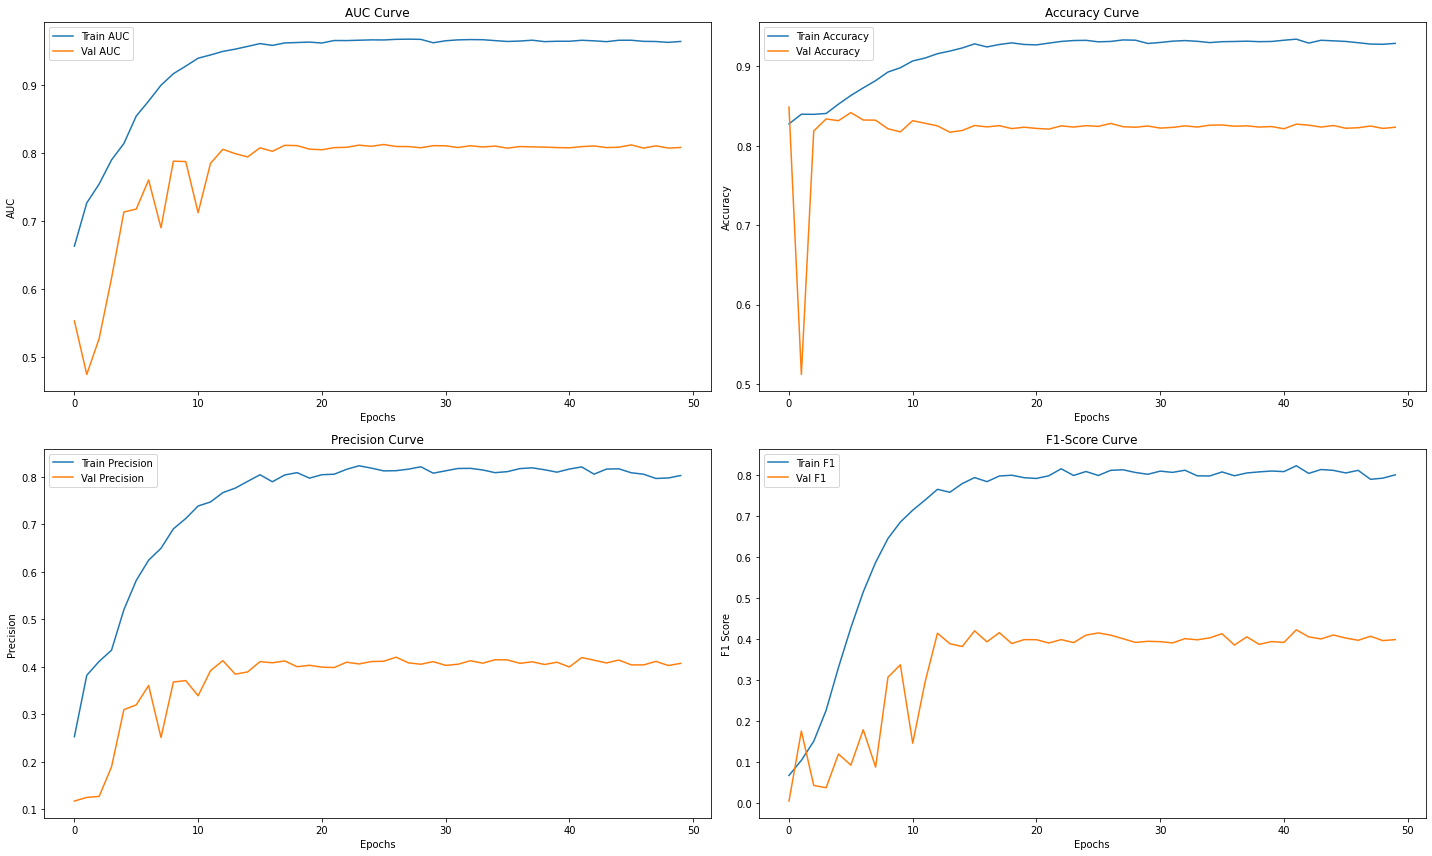

37/37 [==============================] - 8s 52ms/step

Classification Report:
              precision    recall  f1-score   support

           N       0.38      0.26      0.31       223
           D       0.20      0.29      0.24       103
           G       0.04      0.06      0.05        36
           C       0.00      0.00      0.00        36
           A       0.05      0.03      0.03        40
           H       0.05      0.06      0.06        17
           M       0.11      0.05      0.07        41
           O       0.34      0.46      0.39       189

   micro avg       0.26      0.26      0.26       685
   macro avg       0.15      0.15      0.14       685
weighted avg       0.26      0.26      0.25       685
 samples avg       0.22      0.26      0.23       685



/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


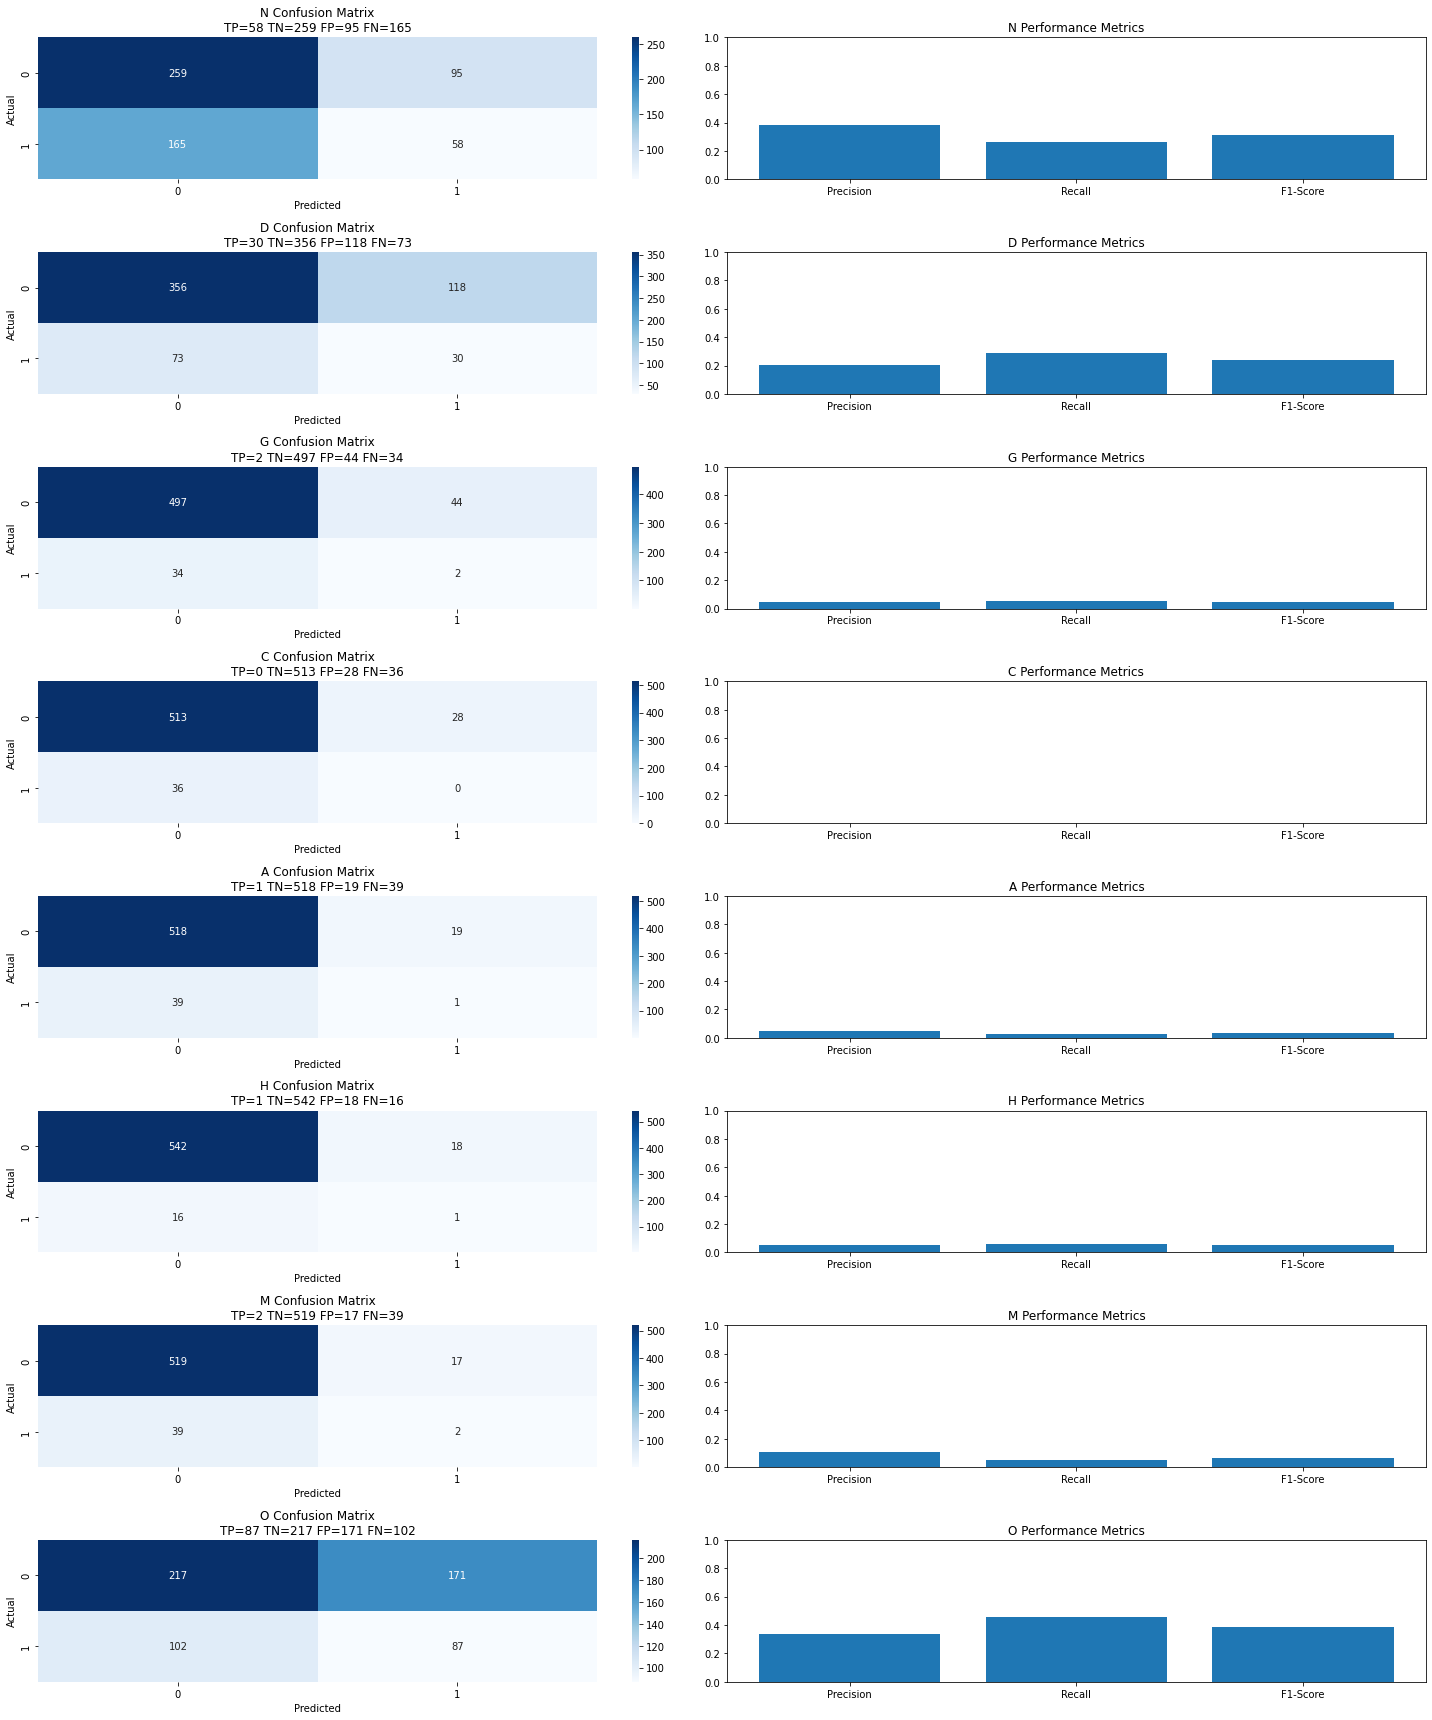

In [2]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os


# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (300, 300)
# IMAGE_SIZE = (512, 512)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
# SAVE_DIR = "saved_models_1"
SAVE_DIR = "saved_models_300*300"
os.makedirs(SAVE_DIR, exist_ok=True)
# 增强型图像预处理
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # 调整尺寸和增强
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    # 创建TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构
def build_siamese_network():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力机制
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 特征融合
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 修改模型编译部分
def train_model():
    # ... [保持数据加载和划分部分不变] ...
        # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分训练验证集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 构建模型
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        # 计算加权损失
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 修改后的评估指标
    metrics = [
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), 
                          average='macro', 
                          threshold=0.5,
                          name='f1_score')
    ]
    # 评价指标，为每个标签单独计算精确率和召回率
    # metrics = [
    # tf.keras.metrics.AUC(name='auc', multi_label=True),
    # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    # *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)],
    # *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
    #   for i, cls in enumerate(CLASS_NAMES)]
    # ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
      # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3)
    ]
    
    
    # 执行训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 新增可视化分析
    
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 新增训练指标可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(20, 12))
    
    # AUC曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 精确率曲线
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.title('Precision Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    
    # F1-Score曲线
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1-Score Curve')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# 新增性能分析函数
def analyze_performance(model, val_ds, class_names):
    # 收集真实标签和预测结果
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    # 生成分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    # 生成多标签混淆矩阵
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*3))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 计算指标
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # 绘制指标
        plt.subplot(len(class_names), 2, 2*i+2)
        plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

# 执行训练
model, history = train_model()

模型双目2

Epoch 1/50
145/145 [==============================] - 79s 377ms/step - loss: 0.9652 - auc: 0.5356 - accuracy: 0.8205 - precision_N: 0.4146 - precision_D: 0.1955 - precision_G: 0.0930 - precision_C: 0.0882 - precision_A: 0.0000e+00 - precision_H: 0.0294 - precision_M: 0.1406 - precision_O: 0.3394 - recall_N: 0.0372 - recall_D: 0.1445 - recall_G: 0.0223 - recall_C: 0.0171 - recall_A: 0.0000e+00 - recall_H: 0.0167 - recall_M: 0.0677 - recall_O: 0.2155 - val_loss: 1.0865 - val_auc: 0.5177 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
145

INFO:tensorflow:Assets written to: saved_models_3/final_model/assets


INFO:tensorflow:Assets written to: saved_models_3/final_model/assets


KeyError: 'precision'

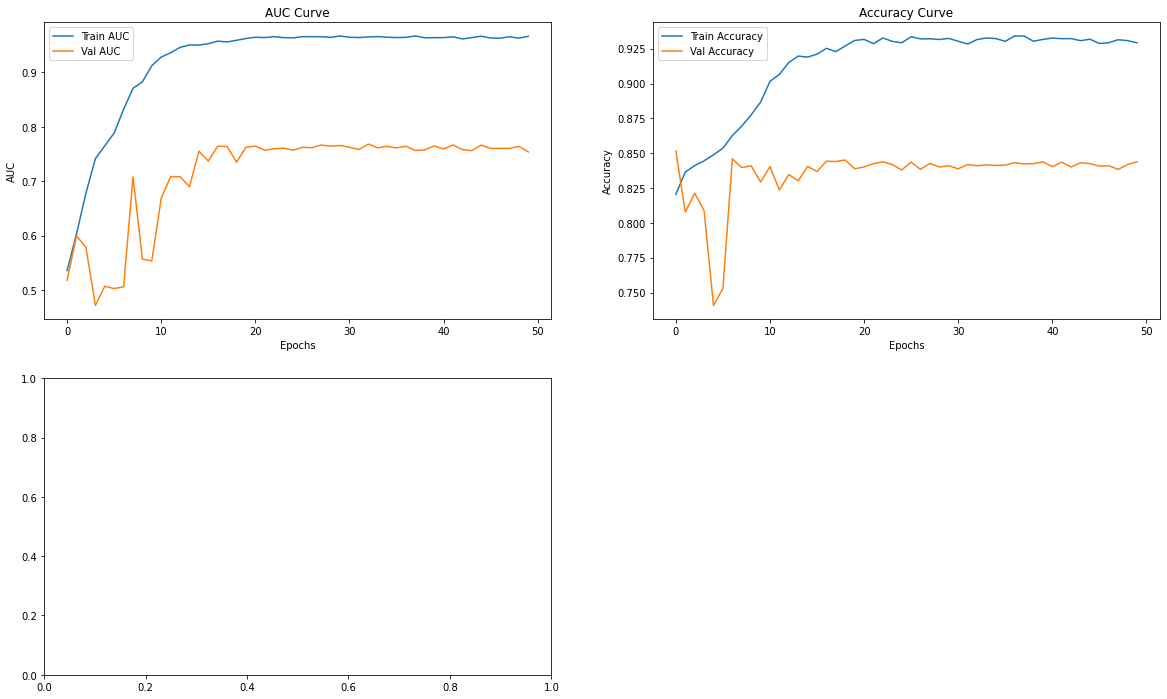

In [3]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns

import os

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models_3"
# 增强型图像预处理
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # 调整尺寸和增强
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    # 创建TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构
def build_siamese_network():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力机制
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 特征融合
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 修改模型编译部分
def train_model():
    # ... [保持数据加载和划分部分不变] ...
        # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分训练验证集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 构建模型
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        # 计算加权损失
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # # 修改后的评估指标
    # metrics = [
    #     tf.keras.metrics.AUC(name='auc'),
    #     tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    #     tf.keras.metrics.Precision(name='precision'),
    #     tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), 
    #                       average='macro', 
    #                       threshold=0.5,
    #                       name='f1_score')
    # ]
    # 评价指标，为每个标签单独计算精确率和召回率
    metrics = [
    tf.keras.metrics.AUC(name='auc', multi_label=True),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
      for i, cls in enumerate(CLASS_NAMES)],
    *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
      for i, cls in enumerate(CLASS_NAMES)]
    ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
      # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3)
    ]
    
    
    # 执行训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 新增可视化分析
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 新增训练指标可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(20, 12))
    
    # AUC曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 精确率曲线
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.title('Precision Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    
    # F1-Score曲线
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1-Score Curve')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# 新增性能分析函数
def analyze_performance(model, val_ds, class_names):
    # 收集真实标签和预测结果
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    # 生成分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    # 生成多标签混淆矩阵
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*3))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 计算指标
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # 绘制指标
        plt.subplot(len(class_names), 2, 2*i+2)
        plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')
    plt.show()

# 执行训练
model, history = train_model()


In [ ]:
# model.save('my_model.h5')
model.save("my_model.h5")

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 8

CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models_2"
os.makedirs(SAVE_DIR, exist_ok=True)

# 增强型图像预处理
class FundusPreprocessor:
    def __init__(self, augment=True):
        self.augment = augment
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
            layers.RandomFlip("horizontal")
        ])
        
    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        
        # 条件增强
        if self.augment:
            img = self.aug(img)
            
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df, augment=True):
    preprocessor = FundusPreprocessor(augment)
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构
def build_siamese_network():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        x = layers.Dense(512, activation='swish')(x)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力机制
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 特征融合
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(256, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 训练流程
def train_model():
    # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分数据集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_ds = create_dataset(train_df, augment=True)
    val_ds = create_dataset(val_df, augment=False)
    
    # 构建模型
    model = build_siamese_network()
    
    # 加权损失函数
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    def weighted_bce(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 评估指标
    metrics = [
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)],
        *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)]
    ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
    
    # 回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model.h5'),
            save_best_only=True,
            monitor='val_auc',
            mode='max',
            save_weights_only=False
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=8,
            mode='max',
            restore_best_weights=True
        )
    ]
    
    # 训练模型
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # 保存最终模型
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 可视化与评估
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(25, 20))
    
    # 宏观指标
    plt.subplot(3, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('Macro AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    # 类别级精确率
    plt.subplot(3, 2, 3)
    for cls in CLASS_NAMES:
        plt.plot(history.history[f'precision_{cls}'], 
                label=f'{cls}', alpha=0.8, linewidth=2)
    plt.title('Training Precision by Class')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 类别级验证精确率
    plt.subplot(3, 2, 4)
    for cls in CLASS_NAMES:
        plt.plot(history.history[f'val_precision_{cls}'], 
                label=f'{cls}', alpha=0.8, linewidth=2)
    plt.title('Validation Precision by Class')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 类别级召回率
    plt.subplot(3, 2, 5)
    for cls in CLASS_NAMES:
        plt.plot(history.history[f'recall_{cls}'], 
                label=f'{cls}', alpha=0.8, linewidth=2)
    plt.title('Training Recall by Class')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 类别级验证召回率
    plt.subplot(3, 2, 6)
    for cls in CLASS_NAMES:
        plt.plot(history.history[f'val_recall_{cls}'], 
                label=f'{cls}', alpha=0.8, linewidth=2)
    plt.title('Validation Recall by Class')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'training_metrics.png'), bbox_inches='tight')
    plt.close()

# 性能分析
def analyze_performance(model, val_ds, class_names):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    # 分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, 
                                target_names=class_names,
                                zero_division=0,
                                digits=3))
    
    # 混淆矩阵
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*3))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        # 混淆矩阵
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{cls} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 性能指标
        plt.subplot(len(class_names), 2, 2*i+2)
        tn, fp, fn, tp = matrix.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        plt.barh(['Precision', 'Recall', 'F1'], [precision, recall, f1], color='teal')
        plt.xlim(0, 1)
        plt.title(f'{cls} Performance Metrics')
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'confusion_matrices.png'))
    plt.close()

# 执行训练
if __name__ == "__main__":
    model, history = train_model()

2025-04-09 10:34:16.861576: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above

Epoch 1/50


2025-04-09 10:34:53.884370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 594 of 1000
2025-04-09 10:34:56.576163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2025-04-09 10:34:58.826487: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-04-09 10:34:59.745135: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-04-09 10:34:59.745162: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2025-04-09 10:34:59.745258: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-04-09 10:35:00.756184: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786]

289/289 [==============================] - ETA: 0s - loss: 0.9595 - auc: 0.4861 - accuracy: 0.8325 - precision_N: 0.3438 - precision_D: 0.2345 - precision_G: 0.0455 - precision_C: 0.1250 - precision_A: 0.1250 - precision_H: 0.0769 - precision_M: 0.0625 - precision_O: 0.3453 - recall_N: 0.0120 - recall_D: 0.1256 - recall_G: 0.0056 - recall_C: 0.0057 - recall_A: 0.0165 - recall_H: 0.0167 - recall_M: 0.0075 - recall_O: 0.1742

2025-04-09 10:36:23.421320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 281 of 1000
2025-04-09 10:36:24.233445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 124s 308ms/step - loss: 0.9595 - auc: 0.4861 - accuracy: 0.8325 - precision_N: 0.3438 - precision_D: 0.2345 - precision_G: 0.0455 - precision_C: 0.1250 - precision_A: 0.1250 - precision_H: 0.0769 - precision_M: 0.0625 - precision_O: 0.3453 - recall_N: 0.0120 - recall_D: 0.1256 - recall_G: 0.0056 - recall_C: 0.0057 - recall_A: 0.0165 - recall_H: 0.0167 - recall_M: 0.0075 - recall_O: 0.1742 - val_loss: 1.1610 - val_auc: 0.4957 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.5000 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0053 - lr: 1.0000e-04
Epoch 2/50


2025-04-09 10:36:40.783391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 892 of 1000
2025-04-09 10:36:41.521663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - ETA: 0s - loss: 0.9252 - auc: 0.4936 - accuracy: 0.8395 - precision_N: 0.5000 - precision_D: 0.1544 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.3546 - recall_N: 0.0011 - recall_D: 0.0498 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.1432

2025-04-09 10:37:59.077930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 311 of 1000
2025-04-09 10:37:59.692304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 95s 289ms/step - loss: 0.9252 - auc: 0.4936 - accuracy: 0.8395 - precision_N: 0.5000 - precision_D: 0.1544 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.3546 - recall_N: 0.0011 - recall_D: 0.0498 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.1432 - val_loss: 0.9073 - val_auc: 0.5246 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 1.00

2025-04-09 10:39:43.181267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 971 of 1000
2025-04-09 10:39:43.485463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - ETA: 0s - loss: 0.9027 - auc: 0.5408 - accuracy: 0.8407 - precision_N: 0.0000e+00 - precision_D: 0.2158 - precision_G: 0.0000e+00 - precision_C: 1.0000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.3688 - recall_N: 0.0000e+00 - recall_D: 0.0711 - recall_G: 0.0000e+00 - recall_C: 0.0114 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.1432
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
289/289 [==============================] - 87s 263ms/step - loss: 0.9027 - auc: 0.5408 - accuracy: 0.8407 - precision_N: 0.0000e+00 - precision_D: 0.2158 - precision_G: 0.0000e+00 - precision_C: 1.0000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.3688 - recall_N: 0.0000e+00 - recall_D: 0.0711 - recall_G: 0.0000e+00 - recall_C: 0.0114 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - 

2025-04-09 10:41:10.181611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 868 of 1000
2025-04-09 10:41:11.088702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 87s 261ms/step - loss: 0.8916 - auc: 0.5540 - accuracy: 0.8421 - precision_N: 0.0000e+00 - precision_D: 0.2198 - precision_G: 0.0000e+00 - precision_C: 1.0000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.4393 - recall_N: 0.0000e+00 - recall_D: 0.0948 - recall_G: 0.0000e+00 - recall_C: 0.0057 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.1729 - val_loss: 0.8755 - val_auc: 0.6011 - val_accuracy: 0.8523 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 1.0000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.5000 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0833 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0053 - lr: 5.0000e-05
Epoch 6/5

2025-04-09 10:42:37.081670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 954 of 1000
2025-04-09 10:42:37.082047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 87s 263ms/step - loss: 0.8744 - auc: 0.5894 - accuracy: 0.8404 - precision_N: 0.0000e+00 - precision_D: 0.2346 - precision_G: 0.0000e+00 - precision_C: 0.5625 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.3820 - recall_N: 0.0000e+00 - recall_D: 0.0995 - recall_G: 0.0000e+00 - recall_C: 0.0514 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.1587 - val_loss: 0.8760 - val_auc: 0.6318 - val_accuracy: 0.8505 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.5000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.4000 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0212 - lr: 5.0000e-05
Epoch 7/5

2025-04-09 10:45:30.582756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 826 of 1000
2025-04-09 10:45:31.185618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 80s 236ms/step - loss: 0.8428 - auc: 0.6522 - accuracy: 0.8435 - precision_N: 0.5000 - precision_D: 0.2812 - precision_G: 0.0000e+00 - precision_C: 0.5455 - precision_A: 0.0000e+00 - precision_H: 0.7500 - precision_M: 0.0000e+00 - precision_O: 0.4695 - recall_N: 0.0055 - recall_D: 0.1493 - recall_G: 0.0000e+00 - recall_C: 0.1714 - recall_A: 0.0000e+00 - recall_H: 0.0500 - recall_M: 0.0000e+00 - recall_O: 0.1884 - val_loss: 0.9262 - val_auc: 0.6048 - val_accuracy: 0.8518 - val_precision_N: 0.0000e+00 - val_precision_D: 0.5000 - val_precision_G: 0.0000e+00 - val_precision_C: 1.0000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0097 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 2.5000e-05
Epoch 9/50


2025-04-09 10:46:50.583951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 979 of 1000
2025-04-09 10:46:50.584364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 80s 239ms/step - loss: 0.8340 - auc: 0.6704 - accuracy: 0.8448 - precision_N: 0.5714 - precision_D: 0.3350 - precision_G: 0.0000e+00 - precision_C: 0.5747 - precision_A: 0.0000e+00 - precision_H: 0.7500 - precision_M: 0.0000e+00 - precision_O: 0.4301 - recall_N: 0.0044 - recall_D: 0.1564 - recall_G: 0.0000e+00 - recall_C: 0.2857 - recall_A: 0.0000e+00 - recall_H: 0.0500 - recall_M: 0.0000e+00 - recall_O: 0.1548 - val_loss: 0.8536 - val_auc: 0.6845 - val_accuracy: 0.8488 - val_precision_N: 0.0000e+00 - val_precision_D: 0.3750 - val_precision_G: 0.0000e+00 - val_precision_C: 0.5238 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2000 - val_precision_M: 0.0000e+00 - val_precision_O: 0.4000 - val_recall_N: 0.0000e+00 - val_recall_D: 0.1456 - val_recall_G: 0.0000e+00 - val_recall_C: 0.3056 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0588 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0106 - lr: 2.5000e-05
Epoch 10/50
289/289 [====================

2025-04-09 10:49:30.688005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 954 of 1000
2025-04-09 10:49:31.380013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 82s 246ms/step - loss: 0.8156 - auc: 0.7081 - accuracy: 0.8442 - precision_N: 0.5294 - precision_D: 0.3289 - precision_G: 0.0000e+00 - precision_C: 0.6887 - precision_A: 0.0000e+00 - precision_H: 0.1000 - precision_M: 0.0000e+00 - precision_O: 0.4555 - recall_N: 0.0099 - recall_D: 0.2322 - recall_G: 0.0000e+00 - recall_C: 0.4171 - recall_A: 0.0000e+00 - recall_H: 0.0167 - recall_M: 0.0000e+00 - recall_O: 0.1716 - val_loss: 0.8418 - val_auc: 0.6949 - val_accuracy: 0.8486 - val_precision_N: 0.0000e+00 - val_precision_D: 0.4211 - val_precision_G: 0.0000e+00 - val_precision_C: 0.4444 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.4348 - val_recall_N: 0.0000e+00 - val_recall_D: 0.1553 - val_recall_G: 0.0000e+00 - val_recall_C: 0.5556 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0529 - lr: 1.2500e-05
Epoch 12/50


2025-04-09 10:50:52.976171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 824 of 1000
2025-04-09 10:50:54.489231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 80s 237ms/step - loss: 0.8023 - auc: 0.7232 - accuracy: 0.8471 - precision_N: 0.6667 - precision_D: 0.3705 - precision_G: 0.0000e+00 - precision_C: 0.7130 - precision_A: 0.0000e+00 - precision_H: 0.3636 - precision_M: 0.0000e+00 - precision_O: 0.4864 - recall_N: 0.0131 - recall_D: 0.2915 - recall_G: 0.0000e+00 - recall_C: 0.4686 - recall_A: 0.0000e+00 - recall_H: 0.0667 - recall_M: 0.0000e+00 - recall_O: 0.2529 - val_loss: 0.8890 - val_auc: 0.6397 - val_accuracy: 0.8488 - val_precision_N: 0.0000e+00 - val_precision_D: 0.3750 - val_precision_G: 0.0000e+00 - val_precision_C: 0.4048 - val_precision_A: 0.0000e+00 - val_precision_H: 1.0000 - val_precision_M: 0.0000e+00 - val_precision_O: 0.3333 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0583 - val_recall_G: 0.0000e+00 - val_recall_C: 0.4722 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0588 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0106 - lr: 1.2500e-05
Epoch 13/50


2025-04-09 10:52:13.782861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 906 of 1000
2025-04-09 10:52:14.483049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - ETA: 0s - loss: 0.8022 - auc: 0.7122 - accuracy: 0.8500 - precision_N: 0.6216 - precision_D: 0.3883 - precision_G: 0.0000e+00 - precision_C: 0.7246 - precision_A: 0.0000e+00 - precision_H: 0.5238 - precision_M: 0.0000e+00 - precision_O: 0.4986 - recall_N: 0.0252 - recall_D: 0.2512 - recall_G: 0.0000e+00 - recall_C: 0.5714 - recall_A: 0.0000e+00 - recall_H: 0.1833 - recall_M: 0.0000e+00 - recall_O: 0.2310
Epoch 13: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
289/289 [==============================] - 86s 258ms/step - loss: 0.8022 - auc: 0.7122 - accuracy: 0.8500 - precision_N: 0.6216 - precision_D: 0.3883 - precision_G: 0.0000e+00 - precision_C: 0.7246 - precision_A: 0.0000e+00 - precision_H: 0.5238 - precision_M: 0.0000e+00 - precision_O: 0.4986 - recall_N: 0.0252 - recall_D: 0.2512 - recall_G: 0.0000e+00 - recall_C: 0.5714 - recall_A: 0.0000e+00 - recall_H: 0.1833 - recall_M: 0.0000e+00 - recall_O: 0.2310 - val_loss: 0.8

2025-04-09 10:55:04.882444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 954 of 1000
2025-04-09 10:55:04.882827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 84s 253ms/step - loss: 0.8020 - auc: 0.7182 - accuracy: 0.8472 - precision_N: 0.6429 - precision_D: 0.3549 - precision_G: 0.2000 - precision_C: 0.7109 - precision_A: 0.0000e+00 - precision_H: 0.5385 - precision_M: 0.0000e+00 - precision_O: 0.4698 - recall_N: 0.0296 - recall_D: 0.2464 - recall_G: 0.0056 - recall_C: 0.5200 - recall_A: 0.0000e+00 - recall_H: 0.1167 - recall_M: 0.0000e+00 - recall_O: 0.2206 - val_loss: 0.8292 - val_auc: 0.7214 - val_accuracy: 0.8323 - val_precision_N: 1.0000 - val_precision_D: 0.3000 - val_precision_G: 0.0000e+00 - val_precision_C: 0.4576 - val_precision_A: 0.0000e+00 - val_precision_H: 0.4000 - val_precision_M: 0.0000e+00 - val_precision_O: 0.4100 - val_recall_N: 0.0045 - val_recall_D: 0.4660 - val_recall_G: 0.0000e+00 - val_recall_C: 0.7500 - val_recall_A: 0.0000e+00 - val_recall_H: 0.2353 - val_recall_M: 0.0000e+00 - val_recall_O: 0.2169 - lr: 6.2500e-06
Epoch 16/50
289/289 [==============================] - ET

2025-04-09 10:59:14.776386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 996 of 1000
2025-04-09 10:59:14.776512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 85s 255ms/step - loss: 0.7890 - auc: 0.7358 - accuracy: 0.8494 - precision_N: 0.6667 - precision_D: 0.3779 - precision_G: 0.1429 - precision_C: 0.7059 - precision_A: 0.0000e+00 - precision_H: 0.5385 - precision_M: 0.6667 - precision_O: 0.4958 - recall_N: 0.0329 - recall_D: 0.2749 - recall_G: 0.0056 - recall_C: 0.6171 - recall_A: 0.0000e+00 - recall_H: 0.1167 - recall_M: 0.0150 - recall_O: 0.2284 - val_loss: 0.8187 - val_auc: 0.7418 - val_accuracy: 0.8360 - val_precision_N: 0.7500 - val_precision_D: 0.2764 - val_precision_G: 0.0000e+00 - val_precision_C: 0.5778 - val_precision_A: 0.0000e+00 - val_precision_H: 0.1739 - val_precision_M: 0.0000e+00 - val_precision_O: 0.4468 - val_recall_N: 0.0135 - val_recall_D: 0.3301 - val_recall_G: 0.0000e+00 - val_recall_C: 0.7222 - val_recall_A: 0.0000e+00 - val_recall_H: 0.2353 - val_recall_M: 0.0000e+00 - val_recall_O: 0.2222 - lr: 3.1250e-06
Epoch 19/50
289/289 [==============================] - ETA: 0s - 

2025-04-09 11:02:02.385258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 929 of 1000
2025-04-09 11:02:02.577536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


289/289 [==============================] - 84s 253ms/step - loss: 0.7949 - auc: 0.7303 - accuracy: 0.8509 - precision_N: 0.5957 - precision_D: 0.4224 - precision_G: 0.1429 - precision_C: 0.6538 - precision_A: 0.0000e+00 - precision_H: 0.5385 - precision_M: 1.0000 - precision_O: 0.5183 - recall_N: 0.0307 - recall_D: 0.3033 - recall_G: 0.0056 - recall_C: 0.5829 - recall_A: 0.0000e+00 - recall_H: 0.1167 - recall_M: 0.0451 - recall_O: 0.2374 - val_loss: 0.8089 - val_auc: 0.7410 - val_accuracy: 0.8325 - val_precision_N: 1.0000 - val_precision_D: 0.2721 - val_precision_G: 0.0000e+00 - val_precision_C: 0.5455 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2000 - val_precision_M: 0.0000e+00 - val_precision_O: 0.4423 - val_recall_N: 0.0135 - val_recall_D: 0.3883 - val_recall_G: 0.0000e+00 - val_recall_C: 0.6667 - val_recall_A: 0.0000e+00 - val_recall_H: 0.2941 - val_recall_M: 0.0000e+00 - val_recall_O: 0.2434 - lr: 1.5625e-06
Epoch 21/50
289/289 [==============================] - 80s 245ms/

INFO:tensorflow:Assets written to: saved_models_2/final_model/assets


INFO:tensorflow:Assets written to: saved_models_2/final_model/assets


73/73 [==============================] - 9s 43ms/step

Classification Report:
              precision    recall  f1-score   support

           N      0.600     0.013     0.026       223
           D      0.189     0.272     0.223       103
           G      0.000     0.000     0.000        36
           C      0.048     0.056     0.051        36
           A      0.000     0.000     0.000        40
           H      0.080     0.118     0.095        17
           M      0.000     0.000     0.000        41
           O      0.349     0.196     0.251       189

   micro avg      0.221     0.105     0.142       685
   macro avg      0.158     0.082     0.081       685
weighted avg      0.325     0.105     0.116       685
 samples avg      0.081     0.092     0.081       685



使用改进的医学处理模块的模型

In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "improved_models"

# 改进的医学图像预处理模块
class MedicalPreprocessor:
    def __init__(self, apply_aug=True):
        self.apply_aug = apply_aug
        
        # CLAHE配置
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
        # 数据增强
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])

    def _apply_clahe(self, img):
        """应用CLAHE对比度增强"""
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_yuv[:,:,0] = self.clahe.apply(img_yuv[:,:,0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    def preprocess(self, img_path):
        """完整的预处理流程"""
        # 读取图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # OpenCV处理需要numpy转换
        img = tf.py_function(
            lambda x: cv2.medianBlur(self._apply_clahe(x.numpy()), 3),
            [img],
            Tout=tf.uint8
        )
        
        # TensorFlow处理流程
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        
        # 数据增强
        if self.apply_aug:
            img = self.aug(img)
            
        return img

# CBAM注意力模块
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=8):
        super().__init__()
        self.channel_axis = -1
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # 通道注意力
        self.channel_attention = tf.keras.Sequential([
            layers.GlobalAvgPool2D(),
            layers.Dense(units=input_shape[-1]//self.reduction_ratio,
                        activation='relu'),
            layers.Dense(units=input_shape[-1], activation='sigmoid')
        ])
        
        # 空间注意力
        self.spatial_attention = tf.keras.Sequential([
            layers.Conv2D(1, 7, padding='same', activation='sigmoid'),
            layers.MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')
        ])
        super().build(input_shape)

    def call(self, inputs):
        # 通道注意力
        channel_att = self.channel_attention(inputs)
        channel_out = inputs * channel_att
        
        # 空间注意力
        spatial_avg = tf.reduce_mean(channel_out, axis=self.channel_axis, keepdims=True)
        spatial_max = tf.reduce_max(channel_out, axis=self.channel_axis, keepdims=True)
        spatial_concat = tf.concat([spatial_avg, spatial_max], axis=self.channel_axis)
        spatial_att = self.spatial_attention(spatial_concat)
        
        return channel_out * spatial_att

# 改进的SE块模块
class SEBlock(layers.Layer):
    def __init__(self, ratio=8):
        super().__init__()
        self.ratio = ratio

    def build(self, input_shape):
        self.se = tf.keras.Sequential([
            layers.GlobalAvgPool2D(),
            layers.Dense(units=input_shape[-1]//self.ratio, activation='relu'),
            layers.Dense(units=input_shape[-1], activation='sigmoid')
        ])
        super().build(input_shape)

    def call(self, inputs):
        se_weight = self.se(inputs)
        return inputs * se_weight

# 改进的双流网络架构
def build_enhanced_model():
    # 共享特征提取器
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = base.output
        x = CBAM()(x)  # 添加CBAM注意力
        x = layers.GlobalAveragePooling2D()(x)
        return Model(base.input, x)
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 特征提取
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 差异特征与注意力
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 改进的特征融合
    merged = layers.Concatenate()([diff, attention])
    merged = SEBlock()(merged)  # SE通道加权
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 改进的Focal Loss
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        ce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = (1.0 - p_t) ** self.gamma
        return tf.reduce_sum(alpha_factor * modulating_factor * ce_loss, axis=-1)

# 数据管道构建
def create_dataset(df, is_train=True):
    preprocessor = MedicalPreprocessor(apply_aug=is_train)
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000 if is_train else 0) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 训练流程
def train_enhanced_model():
    # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分数据集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df, is_train=True)
    val_ds = create_dataset(val_df, is_train=False)
    
    # 构建模型
    model = build_enhanced_model()
    
    # 计算类别权重
    y_labels = df[CLASS_NAMES].values
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(len(CLASS_NAMES)),
        y=y_labels
    )
    
    # 编译配置
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=FocalLoss(gamma=2.0),
        metrics=[
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
              for i, cls in enumerate(CLASS_NAMES)],
            *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
              for i, cls in enumerate(CLASS_NAMES)]
        ]
    )
    
    # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model.h5'),
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=8,
            mode='max',
            restore_best_weights=True
        )
    ]
    
    # 执行训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # 保存模型
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    return model, history

# 启动训练
if __name__ == "__main__":
    os.makedirs(SAVE_DIR, exist_ok=True)
    model, history = train_enhanced_model()

医学图像预处理优化、CBAM注意力机制、SENet特征融合和Focal Loss：

In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (224, 224)  # HRNet推荐尺寸
BATCH_SIZE = 8
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "improved_models"

# 改进的医学图像预处理
class MedicalPreprocessor:
    def __init__(self):
        self.clip_limit = 2.0
        self.grid_size = (8, 8)
        
    def _clahe_opencv(self, img):
        """使用OpenCV实现CLAHE"""
        img = img.numpy().astype(np.uint8)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.grid_size)
        l = clahe.apply(l)
        lab = cv2.merge([l, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    def preprocess(self, img_path):
        # 读取并解码图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # 调整尺寸
        img = tf.image.resize(img, IMAGE_SIZE)
        
        # 使用PyFunction进行CLAHE处理
        img = tf.py_function(self._clahe_opencv, [img], Tout=tf.uint8)
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        
        # 中值滤波
        img = tfa.image.median_filter2d(img, filter_shape=3)
        
        # 数据增强
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# CBAM注意力模块
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=8):
        super().__init__()
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        channels = input_shape[-1]
        
        # 通道注意力
        self.channel_avg = layers.GlobalAveragePooling2D()
        self.channel_max = layers.GlobalMaxPooling2D()
        self.channel_fc = tf.keras.Sequential([
            layers.Dense(channels//self.reduction_ratio, activation='relu'),
            layers.Dense(channels, activation='sigmoid')
        ])
        
        # 空间注意力
        self.spatial_conv = layers.Conv2D(1, 7, padding='same', activation='sigmoid')
        
    def call(self, inputs):
        # 通道注意力
        avg_out = self.channel_fc(self.channel_avg(inputs))
        max_out = self.channel_fc(self.channel_max(inputs))
        channel_out = avg_out + max_out
        channel_out = layers.Reshape((1, 1, -1))(channel_out)
        channel_out = layers.Multiply()([inputs, channel_out])
        
        # 空间注意力
        spatial_out = self.spatial_conv(channel_out)
        return layers.Multiply()([channel_out, spatial_out])

# 改进的双流网络架构
def build_improved_model():
    # 共享特征提取器（使用HRNet结构）
    def hrnet_block(inputs, filters):
        # 高分辨率分支
        x1 = layers.Conv2D(filters, 3, padding='same')(inputs)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.ReLU()(x1)
        
        # 低分辨率分支
        x2 = layers.AveragePooling2D(pool_size=2)(inputs)
        x2 = layers.Conv2D(filters, 3, padding='same')(x2)
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.ReLU()(x2)
        x2 = layers.UpSampling2D()(x2)
        
        # 特征融合
        return layers.Concatenate()([x1, x2])
    
    # 双输入流
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # 共享HRNet骨干网络
    def build_hrnet():
        inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
        x = layers.Conv2D(32, 3, padding='same')(inputs)
        x = hrnet_block(x, 32)  # Stage 1
        x = hrnet_block(x, 64)  # Stage 2
        x = hrnet_block(x, 128) # Stage 3
        x = CBAM()(x)           # 加入CBAM注意力
        x = layers.GlobalAveragePooling2D()(x)
        return Model(inputs, x)
    
    base_network = build_hrnet()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 改进的特征融合
    def senet_fusion(features):
        """SENet风格特征融合"""
        x = layers.Dense(features.shape[-1]//8, activation='relu')(features)
        x = layers.Dense(features.shape[-1], activation='sigmoid')(x)
        return layers.Multiply()([features, x])
    
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    # 拼接后加入SENet融合
    merged = layers.Concatenate()([diff, attention])
    merged = senet_fusion(merged)
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 改进的损失函数（Focal Loss）
class MultiLabelFocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        focal_weight = self.alpha * tf.pow(1 - y_pred, self.gamma) * y_true + \
                      (1 - self.alpha) * tf.pow(y_pred, self.gamma) * (1 - y_true)
        return tf.reduce_mean(focal_weight * cross_entropy, axis=-1)

# 改进的训练流程
def train_improved_model():
    # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 划分数据集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    preprocessor = MedicalPreprocessor()
    def create_ds(df):
        return tf.data.Dataset.from_tensor_slices((
            df['left_path'].values,
            df['right_path'].values,
            df[CLASS_NAMES].values.astype(np.float32)
        )).map(
            lambda l,r,y: ((preprocessor.preprocess(l), preprocessor.preprocess(r)), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    train_ds = create_ds(train_df)
    val_ds = create_ds(val_df)
    
    # 构建模型
    model = build_improved_model()
    
    # 优化器配置
    optimizer = tfa.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5,
        beta_1=0.9,
        beta_2=0.999
    )
    
    # 编译模型
    model.compile(
        optimizer=optimizer,
        loss=MultiLabelFocalLoss(alpha=0.25, gamma=2.0),
        metrics=[
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), average='macro', threshold=0.5),
            tf.keras.metrics.Precision(name='precision', thresholds=0.5),
            tf.keras.metrics.Recall(name='recall', thresholds=0.5),
            tf.keras.metrics.BinaryAccuracy(name='accuracy') 
        ]
    )
    
    # 回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model.h5'),
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max'
        )
    ]
    
    # 执行训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # 保存最终模型
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    
    # 可视化训练过程
    # 修改后的可视化部分
    plt.figure(figsize=(20, 8))
    plt.subplot(131)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.subplot(133)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.savefig(os.path.join(SAVE_DIR, 'training_curves.png'))

    return model, history

if __name__ == "__main__":
    os.makedirs(SAVE_DIR, exist_ok=True)
    model, history = train_improved_model()

In [ ]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os
import textwrap

# 配置参数
# DATA_DIR = "Training_Dataset"
# CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "improved_models"

# CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
# DATA_DIR = "OIA-ODIR/Training Set/Images"
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"

# 改进的医学图像预处理
class MedicalPreprocessor:
    def __init__(self):
        self.clip_limit = 2.0
        self.grid_size = (8, 8)
        
    def _clahe_opencv(self, img):
        img = img.numpy().astype(np.uint8)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.grid_size)
        l = clahe.apply(l)
        lab = cv2.merge([l, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.py_function(self._clahe_opencv, [img], Tout=tf.uint8)
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        img = tfa.image.median_filter2d(img, filter_shape=3)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        return tf.cast(img, tf.float32) / 255.0

# 修复后的CBAM注意力模块
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        channels = input_shape[-1]
        
        # 通道注意力
        self.channel_avg = layers.GlobalAveragePooling2D()
        self.channel_max = layers.GlobalMaxPooling2D()
        self.channel_fc = tf.keras.Sequential([
            layers.Dense(channels//self.reduction_ratio, activation='relu'),
            layers.Dense(channels, activation='sigmoid')
        ])
        
        # 空间注意力
        self.spatial_conv = layers.Conv2D(1, 7, padding='same', activation='sigmoid')
        
    def call(self, inputs):
        avg_out = self.channel_fc(self.channel_avg(inputs))
        max_out = self.channel_fc(self.channel_max(inputs))
        channel_out = avg_out + max_out
        channel_out = layers.Reshape((1, 1, -1))(channel_out)
        channel_out = layers.Multiply()([inputs, channel_out])
        
        spatial_out = self.spatial_conv(channel_out)
        return layers.Multiply()([channel_out, spatial_out])
    
    def get_config(self):
        config = super().get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config

# 改进的双流网络架构
def build_improved_model():
    def hrnet_block(inputs, filters):
        x1 = layers.Conv2D(filters, 3, padding='same')(inputs)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.ReLU()(x1)
        
        x2 = layers.AveragePooling2D(pool_size=2)(inputs)
        x2 = layers.Conv2D(filters, 3, padding='same')(x2)
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.ReLU()(x2)
        x2 = layers.UpSampling2D()(x2)
        return layers.Concatenate()([x1, x2])
    
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    def build_hrnet():
        inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
        x = layers.Conv2D(32, 3, padding='same')(inputs)
        x = hrnet_block(x, 32)
        x = hrnet_block(x, 64)
        x = hrnet_block(x, 128)
        x = CBAM()(x)
        x = layers.GlobalAveragePooling2D()(x)
        return Model(inputs, x)
    
    base_network = build_hrnet()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    def senet_fusion(features):
        x = layers.Dense(features.shape[-1]//8, activation='relu')(features)
        x = layers.Dense(features.shape[-1], activation='sigmoid')(x)
        return layers.Multiply()([features, x])
    
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    merged = layers.Concatenate()([diff, attention])
    merged = senet_fusion(merged)
    
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 改进的损失函数
class MultiLabelFocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, name="multi_label_focal_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
        
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        focal_weight = self.alpha * tf.pow(1 - y_pred, self.gamma) * y_true + \
                      (1 - self.alpha) * tf.pow(y_pred, self.gamma) * (1 - y_true)
        return tf.reduce_mean(focal_weight * cross_entropy, axis=-1)
    
    def get_config(self):
        return {"alpha": self.alpha, "gamma": self.gamma}

# 增强的可视化函数
def plot_training_history(history):
    plt.figure(figsize=(20, 12))
    
    # AUC曲线
    plt.subplot(2, 3, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    
    # F1分数曲线
    plt.subplot(2, 3, 3)
    plt.plot(history.history['f1_score'], label='Train F1')
    plt.plot(history.history['val_f1_score'], label='Val F1')
    plt.title('F1 Score Curve')
    plt.legend()
    
    # 损失曲线
    plt.subplot(2, 3, 4)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    # 精确率-召回率曲线
    plt.subplot(2, 3, 5)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Precision-Recall Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'training_metrics.png'))
    plt.close()

# 改进的训练流程
def train_improved_model():
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    preprocessor = MedicalPreprocessor()
    def create_ds(df):
        return tf.data.Dataset.from_tensor_slices((
            df['left_path'].values,
            df['right_path'].values,
            df[CLASS_NAMES].values.astype(np.float32)
        )).map(
            lambda l,r,y: ((preprocessor.preprocess(l), preprocessor.preprocess(r)), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    train_ds = create_ds(train_df)
    val_ds = create_ds(val_df)
    
    model = build_improved_model()
    
    optimizer = tfa.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5,
        beta_1=0.9,
        beta_2=0.999
    )
    
    model.compile(
        optimizer=optimizer,
        loss=MultiLabelFocalLoss(alpha=0.25, gamma=2.0),
        metrics=[
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            tfa.metrics.F1Score(num_classes=len(CLASS_NAMES), average='macro', threshold=0.5, name='f1_score'),
            tf.keras.metrics.Precision(name='precision', thresholds=0.5),
            tf.keras.metrics.Recall(name='recall', thresholds=0.5),
            tf.keras.metrics.BinaryAccuracy(name='accuracy')
        ]
    )
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model'),
            save_best_only=True,
            monitor='val_auc',
            mode='max',
            save_format='tf'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max'
        )
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    plot_training_history(history)
    
    return model, history

if __name__ == "__main__":
    os.makedirs(SAVE_DIR, exist_ok=True)
    model, history = train_improved_model()

In [7]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# 配置参数
# CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
# DATA_DIR = "OIA-ODIR/Training Set/Images"


DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"

IMAGE_SIZE = (244, 244)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "improved_models_1"

# 改进的医学图像预处理
class MedicalPreprocessor:
    def __init__(self):
        self.clip_limit = 2.0
        self.grid_size = (8, 8)
        
    def _clahe_opencv(self, img):
        img = img.numpy().astype(np.uint8)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.grid_size)
        l = clahe.apply(l)
        lab = cv2.merge([l, a, b])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.py_function(self._clahe_opencv, [img], Tout=tf.uint8)
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        img = tfa.image.median_filter2d(img, filter_shape=3)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        return tf.cast(img, tf.float32) / 255.0

# 数据统计和权重计算
def calculate_class_weights(df):
    class_counts = df[CLASS_NAMES].sum(axis=0).values
    total_samples = len(df)
    
    # 计算类别权重（使用逆频率加权）
    class_weights = total_samples / (len(CLASS_NAMES) * (class_counts + 1e-6))
    
    # 归一化权重
    class_weights = class_weights / class_weights.min()
    return tf.constant(class_weights, dtype=tf.float32)

# 加权二元交叉熵损失
def weighted_bce(class_weights):
    def _weighted_bce(y_true, y_pred):
        # 计算样本权重
        sample_weights = tf.reduce_sum(class_weights * y_true, axis=1)
        
        # 计算基础损失
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        
        # 应用权重
        weighted_loss = bce * sample_weights
        return tf.reduce_mean(weighted_loss)
    return _weighted_bce

# 修复后的CBAM注意力模块
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        channels = input_shape[-1]
        
        # 通道注意力
        self.channel_avg = layers.GlobalAveragePooling2D()
        self.channel_max = layers.GlobalMaxPooling2D()
        self.channel_fc = tf.keras.Sequential([
            layers.Dense(channels//self.reduction_ratio, activation='relu'),
            layers.Dense(channels, activation='sigmoid')
        ])
        
        # 空间注意力
        self.spatial_conv = layers.Conv2D(1, 7, padding='same', activation='sigmoid')
        
    def call(self, inputs):
        avg_out = self.channel_fc(self.channel_avg(inputs))
        max_out = self.channel_fc(self.channel_max(inputs))
        channel_out = avg_out + max_out
        channel_out = layers.Reshape((1, 1, -1))(channel_out)
        channel_out = layers.Multiply()([inputs, channel_out])
        
        spatial_out = self.spatial_conv(channel_out)
        return layers.Multiply()([channel_out, spatial_out])
    
    def get_config(self):
        config = super().get_config()
        config.update({"reduction_ratio": self.reduction_ratio})
        return config

# 改进的双流网络架构
def build_improved_model():
    def hrnet_block(inputs, filters):
        x1 = layers.Conv2D(filters, 3, padding='same')(inputs)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.ReLU()(x1)
        
        x2 = layers.AveragePooling2D(pool_size=2)(inputs)
        x2 = layers.Conv2D(filters, 3, padding='same')(x2)
        x2 = layers.BatchNormalization()(x2)
        x2 = layers.ReLU()(x2)
        x2 = layers.UpSampling2D()(x2)
        return layers.Concatenate()([x1, x2])
    
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    def build_hrnet():
        inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
        x = layers.Conv2D(32, 3, padding='same')(inputs)
        x = hrnet_block(x, 32)
        x = hrnet_block(x, 64)
        x = hrnet_block(x, 128)
        x = CBAM()(x)
        x = layers.GlobalAveragePooling2D()(x)
        return Model(inputs, x)
    
    base_network = build_hrnet()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    def senet_fusion(features):
        x = layers.Dense(features.shape[-1]//8, activation='relu')(features)
        x = layers.Dense(features.shape[-1], activation='sigmoid')(x)
        return layers.Multiply()([features, x])
    
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    merged = layers.Concatenate()([diff, attention])
    merged = senet_fusion(merged)
    
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 增强的可视化函数
def plot_training_history(history):
    plt.figure(figsize=(20, 12))
    
    # AUC曲线
    plt.subplot(2, 3, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve')
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    
    # 损失曲线
    plt.subplot(2, 3, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    # 精确率曲线
    plt.subplot(2, 3, 4)
    for cls in CLASS_NAMES:
        plt.plot(history.history[f'precision_{cls}'], label=f'Train {cls}')
    plt.title('Class-wise Precision')
    plt.legend()
    
    # 召回率曲线
    plt.subplot(2, 3, 5)
    for cls in CLASS_NAMES:
        plt.plot(history.history[f'recall_{cls}'], label=f'Train {cls}')
    plt.title('Class-wise Recall')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'training_metrics.png'))
    plt.close()

# 改进的训练流程
def train_improved_model():
    # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 计算类别权重
    class_weights = calculate_class_weights(df)
    print(f"Calculated class weights: {class_weights.numpy()}")
    
    # 划分数据集
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 数据预处理
    preprocessor = MedicalPreprocessor()
    def create_ds(df):
        return tf.data.Dataset.from_tensor_slices((
            df['left_path'].values,
            df['right_path'].values,
            df[CLASS_NAMES].values.astype(np.float32)
        )).map(
            lambda l,r,y: ((preprocessor.preprocess(l), preprocessor.preprocess(r)), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    train_ds = create_ds(train_df)
    val_ds = create_ds(val_df)
    
    # 构建模型
    model = build_improved_model()
    
    # 定义评估指标
    metrics = [
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)],
        *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)]
    ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(
            learning_rate=1e-4,
            weight_decay=1e-5,
            beta_1=0.9,
            beta_2=0.999
        ),
        loss=weighted_bce(class_weights),
        metrics=metrics
    )
    
    # 回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join(SAVE_DIR, 'best_model'),
            save_best_only=True,
            monitor='val_auc',
            mode='max',
            save_format='tf'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1,
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max'
        )
    ]
    
    # 训练模型
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # 保存和可视化
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    plot_training_history(history)
    
    return model, history

if __name__ == "__main__":
    os.makedirs(SAVE_DIR, exist_ok=True)
    model, history = train_improved_model()

Calculated class weights: [ 1.         2.1638095  5.283721   5.3838863  7.0559006 14.753246
  6.5287356  1.1784233]
Epoch 1/50


2025-04-09 14:30:52.786498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 209 of 1000
2025-04-09 14:30:58.979923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 425 of 1000
2025-04-09 14:31:08.183841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 664 of 1000
2025-04-09 14:31:17.178581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.5464 - auc: 0.4907 - accuracy: 0.8339 - precision_N: 0.3504 - precision_D: 0.2324 - precision_G: 0.0769 - precision_C: 0.1739 - precision_A: 0.0462 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2429 - recall_N: 0.0526 - recall_D: 0.1019 - recall_G: 0.0056 - recall_C: 0.0229 - recall_A: 0.0248 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0219

2025-04-09 14:32:34.375906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 203 of 1000
2025-04-09 14:32:44.684893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 468 of 1000
2025-04-09 14:32:45.285935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 139s 644ms/step - loss: 1.5464 - auc: 0.4907 - accuracy: 0.8339 - precision_N: 0.3504 - precision_D: 0.2324 - precision_G: 0.0769 - precision_C: 0.1739 - precision_A: 0.0462 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2429 - recall_N: 0.0526 - recall_D: 0.1019 - recall_G: 0.0056 - recall_C: 0.0229 - recall_A: 0.0248 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0219 - val_loss: 1.8175 - val_auc: 0.5061 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50


2025-04-09 14:33:03.987085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 218 of 1000
2025-04-09 14:33:16.376937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 482 of 1000
2025-04-09 14:33:24.482310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 713 of 1000
2025-04-09 14:33:32.175972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4776 - auc: 0.4997 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.4118 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0090

2025-04-09 14:34:48.586149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 212 of 1000
2025-04-09 14:34:55.792941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 414 of 1000
2025-04-09 14:34:56.333895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 126s 594ms/step - loss: 1.4776 - auc: 0.4997 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.4118 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0090 - val_loss: 1.5479 - val_auc: 0.5003 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 14:35:12.583000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 206 of 1000
2025-04-09 14:35:21.385172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2025-04-09 14:35:30.284850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 665 of 1000
2025-04-09 14:35:37.677828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4537 - auc: 0.5088 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2222 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026

2025-04-09 14:36:54.976173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 213 of 1000
2025-04-09 14:37:02.376816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 436 of 1000
2025-04-09 14:37:02.497363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 126s 584ms/step - loss: 1.4537 - auc: 0.5088 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2222 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026 - val_loss: 1.4855 - val_auc: 0.4978 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 14:37:17.279087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 200 of 1000
2025-04-09 14:37:26.280663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 464 of 1000
2025-04-09 14:37:37.177384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 694 of 1000
2025-04-09 14:37:44.282753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4413 - auc: 0.5371 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0052

2025-04-09 14:38:58.081502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 208 of 1000
2025-04-09 14:39:07.992928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 509 of 1000
2025-04-09 14:39:08.042841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 130s 621ms/step - loss: 1.4413 - auc: 0.5371 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0052 - val_loss: 1.4752 - val_auc: 0.5401 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 14:39:27.080650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 211 of 1000
2025-04-09 14:39:38.083459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 479 of 1000
2025-04-09 14:39:46.878820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 730 of 1000
2025-04-09 14:39:55.578441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4357 - auc: 0.5409 - accuracy: 0.8487 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2917 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0090

2025-04-09 14:41:10.176639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 211 of 1000
2025-04-09 14:41:18.682074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 420 of 1000
2025-04-09 14:41:19.274776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 132s 632ms/step - loss: 1.4357 - auc: 0.5409 - accuracy: 0.8487 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2917 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0090 - val_loss: 1.4737 - val_auc: 0.5458 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 14:41:38.884346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 197 of 1000
2025-04-09 14:41:49.783221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 414 of 1000
2025-04-09 14:41:59.494231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 685 of 1000
2025-04-09 14:42:07.086582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4287 - auc: 0.5516 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 1.0000 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0024 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 14:43:21.179465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 219 of 1000
2025-04-09 14:43:31.376995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2025-04-09 14:43:32.235816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 127s 595ms/step - loss: 1.4287 - auc: 0.5516 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 1.0000 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0024 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4770 - val_auc: 0.5234 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 14:43:45.682421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-09 14:43:56.391452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 428 of 1000
2025-04-09 14:44:05.782802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 761 of 1000
2025-04-09 14:44:13.202651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4277 - auc: 0.5622 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5714 - precision_C: 0.2500 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.4000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0223 - recall_C: 0.0057 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026

2025-04-09 14:45:27.481054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 196 of 1000
2025-04-09 14:45:36.986694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 433 of 1000
2025-04-09 14:45:37.318192: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 130s 618ms/step - loss: 1.4277 - auc: 0.5622 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5714 - precision_C: 0.2500 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.4000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0223 - recall_C: 0.0057 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026 - val_loss: 1.4641 - val_auc: 0.5473 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 1.0

2025-04-09 14:45:57.085573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 198 of 1000
2025-04-09 14:46:05.981811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 434 of 1000
2025-04-09 14:46:15.793771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 713 of 1000
2025-04-09 14:46:23.979062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4290 - auc: 0.5608 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5714 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.3333 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0223 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013

2025-04-09 14:47:40.287514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2025-04-09 14:47:48.305429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2025-04-09 14:47:48.563048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 132s 632ms/step - loss: 1.4290 - auc: 0.5608 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5714 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.3333 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0223 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013 - val_loss: 1.4506 - val_auc: 0.5745 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 -

2025-04-09 14:48:10.482611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 202 of 1000
2025-04-09 14:48:19.394779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 401 of 1000
2025-04-09 14:48:29.695287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 1000
2025-04-09 14:48:35.881272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4310 - auc: 0.5535 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.5000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.6667 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0057 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026

2025-04-09 14:49:51.582669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 208 of 1000
2025-04-09 14:50:01.019088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 453 of 1000
2025-04-09 14:50:01.180928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 126s 586ms/step - loss: 1.4310 - auc: 0.5535 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.5000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.6667 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0057 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026 - val_loss: 1.4640 - val_auc: 0.5501 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 -

2025-04-09 14:50:16.179201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2025-04-09 14:50:24.684424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 424 of 1000
2025-04-09 14:50:35.078205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 686 of 1000
2025-04-09 14:50:43.279839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4283 - auc: 0.5533 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.4286 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0171 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 14:52:00.486888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2025-04-09 14:52:07.887224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 405 of 1000
2025-04-09 14:52:08.479008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 127s 589ms/step - loss: 1.4283 - auc: 0.5533 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.4286 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0171 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4748 - val_auc: 0.5401 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 14:52:26.290907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000
2025-04-09 14:52:32.782875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 461 of 1000
2025-04-09 14:52:41.881240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 695 of 1000
2025-04-09 14:52:49.676817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4236 - auc: 0.5610 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.4286 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0039

2025-04-09 14:54:03.876440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 217 of 1000
2025-04-09 14:54:13.796774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 481 of 1000
2025-04-09 14:54:13.935921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
145/145 [==============================] - 125s 586ms/step - loss: 1.4236 - auc: 0.5610 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.4286 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0039 - val_loss: 1.4626 - val_auc: 0.5589 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e

2025-04-09 14:54:27.886790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 200 of 1000
2025-04-09 14:54:37.376896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 446 of 1000
2025-04-09 14:54:48.282666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 706 of 1000
2025-04-09 14:54:57.085309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4163 - auc: 0.5717 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026

2025-04-09 14:56:10.576367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2025-04-09 14:56:19.782787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 454 of 1000
2025-04-09 14:56:19.950970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 131s 620ms/step - loss: 1.4163 - auc: 0.5717 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0026 - val_loss: 1.4588 - val_auc: 0.5799 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 14:56:41.076885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000
2025-04-09 14:56:48.577184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 452 of 1000
2025-04-09 14:56:58.589666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 697 of 1000
2025-04-09 14:57:07.288546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4159 - auc: 0.5650 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 14:58:23.885023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 209 of 1000
2025-04-09 14:58:31.069039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 126s 583ms/step - loss: 1.4159 - auc: 0.5650 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.0000e+00 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0000e+00 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4618 - val_auc: 0.5643 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall

2025-04-09 14:58:48.177294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2025-04-09 14:58:55.684449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 418 of 1000
2025-04-09 14:59:04.780390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 825 of 1000
2025-04-09 14:59:12.577526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4085 - auc: 0.5868 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.5556 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0286 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:00:29.687284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2025-04-09 15:00:35.896451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 472 of 1000
2025-04-09 15:00:36.064872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 584ms/step - loss: 1.4085 - auc: 0.5868 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.5556 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0286 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4511 - val_auc: 0.5675 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.00

2025-04-09 15:00:53.486843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2025-04-09 15:01:00.078163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 406 of 1000
2025-04-09 15:01:09.980496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 847 of 1000
2025-04-09 15:01:15.378618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4125 - auc: 0.5807 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2000 - precision_C: 0.3750 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0171 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:02:31.275896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 200 of 1000
2025-04-09 15:02:40.789506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 438 of 1000
2025-04-09 15:02:41.262287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 130s 622ms/step - loss: 1.4125 - auc: 0.5807 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2000 - precision_C: 0.3750 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0171 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4698 - val_auc: 0.5852 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.5000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 5.0

2025-04-09 15:02:59.981941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 228 of 1000
2025-04-09 15:03:13.280308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 485 of 1000
2025-04-09 15:03:20.099591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 688 of 1000
2025-04-09 15:03:27.682872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4105 - auc: 0.5804 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5000 - precision_C: 0.2857 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0229 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:04:42.285201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2025-04-09 15:04:51.566559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 580ms/step - loss: 1.4105 - auc: 0.5804 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5000 - precision_C: 0.2857 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0229 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4601 - val_auc: 0.5608 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 -

2025-04-09 15:05:04.889224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 203 of 1000
2025-04-09 15:05:15.681922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 428 of 1000
2025-04-09 15:05:24.979312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 678 of 1000
2025-04-09 15:05:34.281189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4103 - auc: 0.5841 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5000 - precision_C: 0.4615 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2500 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0343 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013

2025-04-09 15:06:48.376078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2025-04-09 15:06:57.981129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 443 of 1000
2025-04-09 15:06:58.373285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 127s 586ms/step - loss: 1.4103 - auc: 0.5841 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5000 - precision_C: 0.4615 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.2500 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0343 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013 - val_loss: 1.4571 - val_auc: 0.5549 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 5.0

2025-04-09 15:07:13.084209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2025-04-09 15:07:22.080867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 456 of 1000
2025-04-09 15:07:31.885577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 678 of 1000
2025-04-09 15:07:41.476729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.4077 - auc: 0.5819 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.3333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 1.0000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0114 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013

2025-04-09 15:08:54.383436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 223 of 1000
2025-04-09 15:09:04.289200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 463 of 1000
2025-04-09 15:09:04.581797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
145/145 [==============================] - 126s 582ms/step - loss: 1.4077 - auc: 0.5819 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.3333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 1.0000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0114 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013 - val_loss: 1.5113 - val_auc: 0.5416 - val_accuracy: 0.8471 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0435 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall

2025-04-09 15:09:19.579720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 211 of 1000
2025-04-09 15:09:29.184024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2025-04-09 15:09:37.780180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 652 of 1000
2025-04-09 15:09:45.481912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3924 - auc: 0.5954 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 1.0000 - precision_C: 0.5333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013

2025-04-09 15:11:03.081227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 202 of 1000
2025-04-09 15:11:11.288519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2025-04-09 15:11:11.360452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 127s 598ms/step - loss: 1.3924 - auc: 0.5954 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 1.0000 - precision_C: 0.5333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013 - val_loss: 1.4683 - val_auc: 0.5646 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.3333 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 2.5000e-05


2025-04-09 15:11:25.475848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2025-04-09 15:11:36.576601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 464 of 1000
2025-04-09 15:11:45.487233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 724 of 1000
2025-04-09 15:11:54.279132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3948 - auc: 0.6039 - accuracy: 0.8497 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5000 - precision_C: 0.6923 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0514 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:13:07.878406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 201 of 1000
2025-04-09 15:13:17.780544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2025-04-09 15:13:18.272793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 132s 626ms/step - loss: 1.3948 - auc: 0.6039 - accuracy: 0.8497 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.5000 - precision_C: 0.6923 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0514 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4421 - val_auc: 0.5979 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 -

2025-04-09 15:13:37.277016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 201 of 1000
2025-04-09 15:13:46.984767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 426 of 1000
2025-04-09 15:14:01.881425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 822 of 1000
2025-04-09 15:14:02.881424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3937 - auc: 0.5927 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.4444 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0229 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:15:20.375974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 217 of 1000
2025-04-09 15:15:29.700375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2025-04-09 15:15:29.781077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 126s 588ms/step - loss: 1.3937 - auc: 0.5927 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.4444 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0229 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4590 - val_auc: 0.5783 - val_accuracy: 0.8494 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0909 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0000e+00 - lr: 2.5

2025-04-09 15:15:43.377553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 245 of 1000
2025-04-09 15:15:54.687007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 449 of 1000
2025-04-09 15:16:03.285305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 842 of 1000
2025-04-09 15:16:10.578875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3950 - auc: 0.5911 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2000 - precision_C: 0.6250 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0571 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:17:28.483836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 1000
2025-04-09 15:17:34.216694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2025-04-09 15:17:34.352039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 124s 579ms/step - loss: 1.3950 - auc: 0.5911 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2000 - precision_C: 0.6250 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0571 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4466 - val_auc: 0.5792 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 1.0000 - val_precision_C: 0.2500 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.5000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0278 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 2.5000e-05
Epoch 23

2025-04-09 15:17:47.577794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2025-04-09 15:17:59.579678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2025-04-09 15:18:07.600527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 660 of 1000
2025-04-09 15:18:14.880132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3930 - auc: 0.5969 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1667 - precision_C: 0.5556 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.6667 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0286 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0150 - recall_O: 0.0013

2025-04-09 15:19:32.186197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 214 of 1000
2025-04-09 15:19:39.841602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 512 of 1000
2025-04-09 15:19:39.842478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 23: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
145/145 [==============================] - 125s 584ms/step - loss: 1.3930 - auc: 0.5969 - accuracy: 0.8494 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1667 - precision_C: 0.5556 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.6667 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0286 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0150 - recall_O: 0.0013 - val_loss: 1.4495 - val_auc: 0.5712 - val_accuracy: 0.8512 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 1.0000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+

2025-04-09 15:19:54.377204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 231 of 1000
2025-04-09 15:20:03.781623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 496 of 1000
2025-04-09 15:20:14.385742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 781 of 1000
2025-04-09 15:20:22.075964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3866 - auc: 0.6059 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1667 - precision_C: 0.5385 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:21:38.476790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2025-04-09 15:21:44.916242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2025-04-09 15:21:44.990546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 584ms/step - loss: 1.3866 - auc: 0.6059 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1667 - precision_C: 0.5385 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4538 - val_auc: 0.5784 - val_accuracy: 0.8512 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.5000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 1.2

2025-04-09 15:22:02.392425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 227 of 1000
2025-04-09 15:22:09.088481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 425 of 1000
2025-04-09 15:22:19.083496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 733 of 1000
2025-04-09 15:22:26.931834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3987 - auc: 0.5954 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2000 - precision_C: 0.5333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:23:40.482335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 211 of 1000
2025-04-09 15:23:50.305277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 461 of 1000
2025-04-09 15:23:50.372050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 582ms/step - loss: 1.3987 - auc: 0.5954 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2000 - precision_C: 0.5333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4566 - val_auc: 0.5722 - val_accuracy: 0.8510 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.3333 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.3333 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 1.2500e-05


2025-04-09 15:24:05.685443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-09 15:24:15.676117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 438 of 1000
2025-04-09 15:24:24.279922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 736 of 1000
2025-04-09 15:24:33.776820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 980 of 1000
2025-04-09 15:24:33.777105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3945 - auc: 0.5986 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2222 - precision_C: 0.5333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 1.0000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013

2025-04-09 15:25:46.381139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 197 of 1000
2025-04-09 15:25:56.386399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 433 of 1000
2025-04-09 15:25:56.869336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 26: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
145/145 [==============================] - 126s 586ms/step - loss: 1.3945 - auc: 0.5986 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.2222 - precision_C: 0.5333 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 1.0000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013 - val_loss: 1.4334 - val_auc: 0.5967 - val_accuracy: 0.8512 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_

2025-04-09 15:26:12.583949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2025-04-09 15:26:20.282396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 458 of 1000
2025-04-09 15:26:30.084048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 685 of 1000
2025-04-09 15:26:38.084393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3923 - auc: 0.6026 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.7000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:27:51.980383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 207 of 1000
2025-04-09 15:28:01.490178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 455 of 1000
2025-04-09 15:28:01.658400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 580ms/step - loss: 1.3923 - auc: 0.6026 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.7000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4511 - val_auc: 0.5736 - val_accuracy: 0.8505 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.3333 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 6.2

2025-04-09 15:28:17.277294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 208 of 1000
2025-04-09 15:28:25.885640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 461 of 1000
2025-04-09 15:28:35.076737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 721 of 1000
2025-04-09 15:28:42.793867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3863 - auc: 0.6142 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.5714 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.5000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00

2025-04-09 15:29:57.283076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-09 15:30:05.321590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2025-04-09 15:30:05.458818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 124s 579ms/step - loss: 1.3863 - auc: 0.6142 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.5714 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.5000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00 - val_loss: 1.4409 - val_auc: 0.5721 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 1.0000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.5000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 6.2500e-06
Epoch 29

2025-04-09 15:30:19.381975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 201 of 1000
2025-04-09 15:30:28.978999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2025-04-09 15:30:39.879054: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 733 of 1000
2025-04-09 15:30:48.091660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3802 - auc: 0.6100 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1429 - precision_C: 0.6316 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0686 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:32:02.675924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 201 of 1000
2025-04-09 15:32:10.890824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 437 of 1000
2025-04-09 15:32:11.435575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


INFO:tensorflow:Assets written to: improved_models_1/best_model/assets


145/145 [==============================] - 132s 632ms/step - loss: 1.3802 - auc: 0.6100 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1429 - precision_C: 0.6316 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0686 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4268 - val_auc: 0.6140 - val_accuracy: 0.8518 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.5000 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.6667 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0278 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0488 - val_recall_O: 0.0000e+00 - lr: 6.2500e-06


2025-04-09 15:32:32.584604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 234 of 1000
2025-04-09 15:32:40.983808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 473 of 1000
2025-04-09 15:32:50.985025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 696 of 1000
2025-04-09 15:33:00.180720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3863 - auc: 0.6074 - accuracy: 0.8491 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3846 - precision_C: 0.3750 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.4000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0279 - recall_C: 0.0343 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0150 - recall_O: 0.0000e+00

2025-04-09 15:34:13.682782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 197 of 1000
2025-04-09 15:34:22.887558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 453 of 1000
2025-04-09 15:34:22.967586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 586ms/step - loss: 1.3863 - auc: 0.6074 - accuracy: 0.8491 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3846 - precision_C: 0.3750 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.4000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0279 - recall_C: 0.0343 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0150 - recall_O: 0.0000e+00 - val_loss: 1.4449 - val_auc: 0.5829 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.5000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.5000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 6.2500e-06
Epoch 31

2025-04-09 15:34:36.277520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2025-04-09 15:34:47.777090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 425 of 1000
2025-04-09 15:34:56.183480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 629 of 1000
2025-04-09 15:35:06.389981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 949 of 1000
2025-04-09 15:35:06.390375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3884 - auc: 0.6091 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1111 - precision_C: 0.6364 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.2000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00

2025-04-09 15:36:21.476974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 200 of 1000
2025-04-09 15:36:31.814576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2025-04-09 15:36:31.860603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 129s 586ms/step - loss: 1.3884 - auc: 0.6091 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1111 - precision_C: 0.6364 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.2000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00 - val_loss: 1.4533 - val_auc: 0.5670 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 1.0000 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.5000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0278 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 6.2500e-06
Epoch 32

2025-04-09 15:36:49.486020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 199 of 1000
2025-04-09 15:36:56.839294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 392 of 1000
2025-04-09 15:37:05.587204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 795 of 1000
2025-04-09 15:37:13.186313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3928 - auc: 0.6063 - accuracy: 0.8490 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.6000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.1429 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0514 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00

2025-04-09 15:38:28.085305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 210 of 1000
2025-04-09 15:38:38.321527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 448 of 1000
2025-04-09 15:38:38.377521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 32: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
145/145 [==============================] - 126s 582ms/step - loss: 1.3928 - auc: 0.6063 - accuracy: 0.8490 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.6000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.1429 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0514 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00 - val_loss: 1.4323 - val_auc: 0.5975 - val_accuracy: 0.8520 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 1.0000 - val_precision_C: 1.0000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.5000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0278 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+0

2025-04-09 15:38:55.776168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 242 of 1000
2025-04-09 15:39:01.783281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2025-04-09 15:39:11.580183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 771 of 1000
2025-04-09 15:39:19.280572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3868 - auc: 0.6120 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.4167 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0286 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013

2025-04-09 15:40:33.577003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 218 of 1000
2025-04-09 15:40:42.881486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 457 of 1000
2025-04-09 15:40:43.009549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 584ms/step - loss: 1.3868 - auc: 0.6120 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.4167 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.5000 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0286 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0013 - val_loss: 1.4492 - val_auc: 0.5858 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.5000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 3.1

2025-04-09 15:40:58.585128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 220 of 1000
2025-04-09 15:41:06.479548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 425 of 1000
2025-04-09 15:41:21.591241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 845 of 1000
2025-04-09 15:41:22.695541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3893 - auc: 0.6044 - accuracy: 0.8490 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.5000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:42:39.377937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 203 of 1000
2025-04-09 15:42:47.796215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 440 of 1000
2025-04-09 15:42:47.987280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 581ms/step - loss: 1.3893 - auc: 0.6044 - accuracy: 0.8490 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.0000e+00 - precision_C: 0.5000 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0000e+00 - recall_C: 0.0400 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4425 - val_auc: 0.5937 - val_accuracy: 0.8512 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 1.0000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 -

2025-04-09 15:43:01.880264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 212 of 1000
2025-04-09 15:43:13.482424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 477 of 1000
2025-04-09 15:43:21.375967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 781 of 1000
2025-04-09 15:43:28.038223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3849 - auc: 0.6062 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1111 - precision_C: 0.5500 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 1.0000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0629 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00

2025-04-09 15:44:45.995514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 200 of 1000
2025-04-09 15:44:52.377785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2025-04-09 15:44:52.806353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 35: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
145/145 [==============================] - 125s 586ms/step - loss: 1.3849 - auc: 0.6062 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1111 - precision_C: 0.5500 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 1.0000 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0629 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0075 - recall_O: 0.0000e+00 - val_loss: 1.4469 - val_auc: 0.5802 - val_accuracy: 0.8514 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 1.0000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0

2025-04-09 15:45:08.676185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 197 of 1000
2025-04-09 15:45:16.780898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 422 of 1000
2025-04-09 15:45:27.179370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 846 of 1000
2025-04-09 15:45:33.084225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3915 - auc: 0.6008 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1429 - precision_C: 0.5714 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:46:47.585673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2025-04-09 15:46:57.070232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 124s 576ms/step - loss: 1.3915 - auc: 0.6008 - accuracy: 0.8492 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.1429 - precision_C: 0.5714 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0056 - recall_C: 0.0457 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4321 - val_auc: 0.5908 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 1.0000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 1.5

2025-04-09 15:47:12.780338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 208 of 1000
2025-04-09 15:47:20.282281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 472 of 1000
2025-04-09 15:47:30.382168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 802 of 1000
2025-04-09 15:47:36.676550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3801 - auc: 0.6209 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.5238 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0168 - recall_C: 0.0629 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:48:52.491511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 204 of 1000
2025-04-09 15:48:59.278651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 404 of 1000
2025-04-09 15:48:59.752184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 123s 579ms/step - loss: 1.3801 - auc: 0.6209 - accuracy: 0.8493 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.3333 - precision_C: 0.5238 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0168 - recall_C: 0.0629 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4378 - val_auc: 0.5874 - val_accuracy: 0.8516 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 1.0000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0244 - val_recall_O: 0.0000e+00 - lr: 1.5

2025-04-09 15:49:16.180391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 215 of 1000
2025-04-09 15:49:23.784487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 460 of 1000
2025-04-09 15:49:33.695133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 695 of 1000
2025-04-09 15:49:40.719793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3778 - auc: 0.6214 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.4000 - precision_C: 0.5556 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0571 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:50:55.875956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2025-04-09 15:51:05.576105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2025-04-09 15:51:06.084515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 38: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
145/145 [==============================] - 126s 584ms/step - loss: 1.3778 - auc: 0.6214 - accuracy: 0.8495 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.4000 - precision_C: 0.5556 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0112 - recall_C: 0.0571 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4412 - val_auc: 0.5963 - val_accuracy: 0.8512 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 1.0000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_rec

2025-04-09 15:51:23.186543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 237 of 1000
2025-04-09 15:51:31.284429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 447 of 1000
2025-04-09 15:51:39.882652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 744 of 1000
2025-04-09 15:51:48.578179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.3872 - auc: 0.6128 - accuracy: 0.8496 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.7500 - precision_C: 0.5294 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0168 - recall_C: 0.0514 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00

2025-04-09 15:53:02.478108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 205 of 1000
2025-04-09 15:53:11.483957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 415 of 1000
2025-04-09 15:53:11.556677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 125s 586ms/step - loss: 1.3872 - auc: 0.6128 - accuracy: 0.8496 - precision_N: 0.0000e+00 - precision_D: 0.0000e+00 - precision_G: 0.7500 - precision_C: 0.5294 - precision_A: 0.0000e+00 - precision_H: 0.0000e+00 - precision_M: 0.0000e+00 - precision_O: 0.0000e+00 - recall_N: 0.0000e+00 - recall_D: 0.0000e+00 - recall_G: 0.0168 - recall_C: 0.0514 - recall_A: 0.0000e+00 - recall_H: 0.0000e+00 - recall_M: 0.0000e+00 - recall_O: 0.0000e+00 - val_loss: 1.4304 - val_auc: 0.5923 - val_accuracy: 0.8520 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.5000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 1.0000 - val_precision_O: 0.0000e+00 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0278 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0488 - val_recall_O: 0.0000e+00 - lr: 7.8125e-07


INFO:tensorflow:Assets written to: improved_models_1/final_model/assets


INFO:tensorflow:Assets written to: improved_models_1/final_model/assets


In [ ]:
改进方法，模型没有提升，使用原来的处理方法，更改注意力机制，模型提升大，特征融合机制提升高。

数据集更改模型model 3,保存为model4

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os

# 配置参数
CSV_PATH = "OIA-ODIR/Training Set/Annotation/training annotation (English).xlsx"
DATA_DIR = "OIA-ODIR/Training Set/Images"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models_4"

# 自定义宏平均指标（修正形状问题）
class MacroPrecision(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='macro_precision', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precisions = [tf.keras.metrics.Precision(thresholds=[0.5]) for _ in range(num_classes)]
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        for i, p in enumerate(self.precisions):
            p.update_state(y_true[:, i], y_pred[:, i])
            
    def result(self):
        return tf.reduce_mean([p.result() for p in self.precisions])

class MacroRecall(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='macro_recall', **kwargs):
        super().__init__(name=name, **kwargs)
        self.recalls = [tf.keras.metrics.Recall(thresholds=[0.5]) for _ in range(num_classes)]
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        for i, r in enumerate(self.recalls):
            r.update_state(y_true[:, i], y_pred[:, i])
            
    def result(self):
        return tf.reduce_mean([r.result() for r in self.recalls])

# 图像预处理类
class FundusPreprocessor:
    def __init__(self):
        self.aug = tf.keras.Sequential([
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.1),
            layers.RandomBrightness(0.1),
        ])
        
    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = self.aug(img)
        return tf.cast(img, tf.float32) / 255.0

# 数据管道
def create_dataset(df):
    preprocessor = FundusPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 模型架构
def build_siamese_network():
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    merged = layers.Concatenate()([diff, attention])
    
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

def train_model():
    # 数据加载
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 数据集划分
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 模型构建
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    # 自定义加权损失
    def weighted_bce(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 修正后的评估指标（解决形状兼容性）
    metrics = [
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tfa.metrics.F1Score(
            num_classes=len(CLASS_NAMES),
            average='macro',
            threshold=0.5,
            name='macro_f1'
        ),
        MacroPrecision(num_classes=len(CLASS_NAMES), name='macro_precision'),
        MacroRecall(num_classes=len(CLASS_NAMES), name='macro_recall'),
        *[tf.keras.metrics.Precision(thresholds=[0.5], name=f'precision_{cls}') for cls in CLASS_NAMES],
        *[tf.keras.metrics.Recall(thresholds=[0.5], name=f'recall_{cls}') for cls in CLASS_NAMES]
    ]
    
    # 模型编译
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
    
    # 训练回调
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5', 
            save_best_only=True,
            monitor='val_macro_f1',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_macro_f1',
            factor=0.5,
            patience=3,
            mode='max'
        )
    ]
    
    # 模型训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # 模型保存
    # os.makedirs(SAVE_DIR, exist_ok=True)
    # model.save(os.path.join(SAVE_DIR, 'final_model'))
    # model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 结果可视化
    plot_global_metrics(history)
    plot_class_metrics(history, CLASS_NAMES)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 可视化函数
def plot_global_metrics(history):
    plt.figure(figsize=(18, 12))
    
    metrics_map = {
        'auc': 'AUC',
        'accuracy': 'Accuracy',
        'macro_precision': 'Macro Precision',
        'macro_recall': 'Macro Recall',
        'macro_f1': 'Macro F1-Score'
    }
    
    for idx, (metric, title) in enumerate(metrics_map.items(), 1):
        plt.subplot(2, 3, idx)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(f'{title} Curve')
        plt.xlabel('Epochs')
        plt.ylabel(title)
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('global_metrics.png', dpi=300)
    plt.show()

def plot_class_metrics(history, class_names):
    plt.figure(figsize=(20, 5 * len(class_names)))
    
    for idx, cls in enumerate(class_names, 1):
        # 精确率
        plt.subplot(len(class_names), 2, 2*idx-1)
        plt.plot(history.history[f'precision_{cls}'], 
                label='Train Precision', 
                color='#1f77b4',
                linewidth=2)
        plt.plot(history.history[f'val_precision_{cls}'], 
                label='Val Precision', 
                color='#ff7f0e',
                linestyle='--',
                linewidth=2)
        plt.title(f'{cls} - Precision', fontsize=12)
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        if idx == 1:
            plt.legend()
        
        # 召回率
        plt.subplot(len(class_names), 2, 2*idx)
        plt.plot(history.history[f'recall_{cls}'], 
                label='Train Recall', 
                color='#2ca02c',
                linewidth=2)
        plt.plot(history.history[f'val_recall_{cls}'], 
                label='Val Recall', 
                color='#d62728',
                linestyle='--',
                linewidth=2)
        plt.title(f'{cls} - Recall', fontsize=12)
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        if idx == 1:
            plt.legend()
    
    plt.tight_layout()
    plt.savefig('class_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# 性能分析
def analyze_performance(model, val_ds, class_names):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    # 混淆矩阵可视化
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, 3 * len(class_names)))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}', fontsize=10)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # 指标计算
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # 指标可视化
        plt.subplot(len(class_names), 2, 2*i+2)
        bars = plt.bar(['Precision', 'Recall', 'F1'], [precision, recall, f1], 
                      color=['#1f77b4', '#2ca02c', '#d62728'])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # 添加数值标签
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.2f}',
                    ha='center', va='bottom',
                    fontsize=9)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300)
    plt.show()

# 执行训练
if __name__ == "__main__":
    model, history = train_model()

特征强化后的模型

2025-04-10 10:30:40.256561: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above

Epoch 1/50


2025-04-10 10:31:17.594464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 181 of 1000
2025-04-10 10:31:28.420697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 387 of 1000
2025-04-10 10:31:37.780628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 585 of 1000
2025-04-10 10:31:48.181048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 794 of 1000
2025-04-10 10:31:55.208673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2025-04-10 10:31:56.755637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-04-10 10:31:57.816059: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-04-10 10:31:57.81608

145/145 [==============================] - ETA: 0s - loss: 0.9625 - auc: 0.5305 - accuracy: 0.8239 - precision_N: 0.4343 - precision_D: 0.2327 - precision_G: 0.0577 - precision_C: 0.1842 - precision_A: 0.0400 - precision_H: 0.0385 - precision_M: 0.0000e+00 - precision_O: 0.3563 - recall_N: 0.0471 - recall_D: 0.1517 - recall_G: 0.0168 - recall_C: 0.0400 - recall_A: 0.0165 - recall_H: 0.0167 - recall_M: 0.0000e+00 - recall_O: 0.2400

2025-04-10 10:33:16.882694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 1000
2025-04-10 10:33:26.089007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 316 of 1000
2025-04-10 10:33:32.189835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 166s 665ms/step - loss: 0.9625 - auc: 0.5305 - accuracy: 0.8239 - precision_N: 0.4343 - precision_D: 0.2327 - precision_G: 0.0577 - precision_C: 0.1842 - precision_A: 0.0400 - precision_H: 0.0385 - precision_M: 0.0000e+00 - precision_O: 0.3563 - recall_N: 0.0471 - recall_D: 0.1517 - recall_G: 0.0168 - recall_C: 0.0400 - recall_A: 0.0165 - recall_H: 0.0167 - recall_M: 0.0000e+00 - recall_O: 0.2400 - val_loss: 0.9757 - val_auc: 0.4906 - val_accuracy: 0.8477 - val_precision_N: 0.0000e+00 - val_precision_D: 0.0000e+00 - val_precision_G: 0.0000e+00 - val_precision_C: 0.0000e+00 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.3077 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0000e+00 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0000e+00 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.0423 - lr: 1.0000e-04
Epoch 2/50


2025-04-10 10:33:45.877736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:33:56.379660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 397 of 1000
2025-04-10 10:34:06.676078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 629 of 1000
2025-04-10 10:34:15.403837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 857 of 1000
2025-04-10 10:34:17.710304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.8860 - auc: 0.6077 - accuracy: 0.8310 - precision_N: 0.5238 - precision_D: 0.2056 - precision_G: 0.2000 - precision_C: 0.5614 - precision_A: 0.0000e+00 - precision_H: 0.2500 - precision_M: 1.0000 - precision_O: 0.3676 - recall_N: 0.0120 - recall_D: 0.1754 - recall_G: 0.0056 - recall_C: 0.3657 - recall_A: 0.0000e+00 - recall_H: 0.0167 - recall_M: 0.0075 - recall_O: 0.2490

2025-04-10 10:35:38.401708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2025-04-10 10:35:46.828297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 206 of 1000
2025-04-10 10:35:54.315369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 142s 664ms/step - loss: 0.8860 - auc: 0.6077 - accuracy: 0.8310 - precision_N: 0.5238 - precision_D: 0.2056 - precision_G: 0.2000 - precision_C: 0.5614 - precision_A: 0.0000e+00 - precision_H: 0.2500 - precision_M: 1.0000 - precision_O: 0.3676 - recall_N: 0.0120 - recall_D: 0.1754 - recall_G: 0.0056 - recall_C: 0.3657 - recall_A: 0.0000e+00 - recall_H: 0.0167 - recall_M: 0.0075 - recall_O: 0.2490 - val_loss: 0.9728 - val_auc: 0.5470 - val_accuracy: 0.8436 - val_precision_N: 0.0000e+00 - val_precision_D: 1.0000 - val_precision_G: 0.0000e+00 - val_precision_C: 0.2222 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.3182 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0097 - val_recall_G: 0.0000e+00 - val_recall_C: 0.0556 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.1481 - lr: 1.0000e-04
Epoch 3/50


2025-04-10 10:36:09.785357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 10:36:18.307403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 393 of 1000
2025-04-10 10:36:27.702935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 624 of 1000
2025-04-10 10:36:37.686752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 885 of 1000
2025-04-10 10:36:41.593785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.8738 - auc: 0.6272 - accuracy: 0.8332 - precision_N: 0.2353 - precision_D: 0.2432 - precision_G: 0.3158 - precision_C: 0.5175 - precision_A: 0.0000e+00 - precision_H: 0.6000 - precision_M: 0.0000e+00 - precision_O: 0.3922 - recall_N: 0.0044 - recall_D: 0.2133 - recall_G: 0.0335 - recall_C: 0.3371 - recall_A: 0.0000e+00 - recall_H: 0.0500 - recall_M: 0.0000e+00 - recall_O: 0.2323

2025-04-10 10:38:00.033450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:38:10.346426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 10:38:12.828874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 138s 638ms/step - loss: 0.8738 - auc: 0.6272 - accuracy: 0.8332 - precision_N: 0.2353 - precision_D: 0.2432 - precision_G: 0.3158 - precision_C: 0.5175 - precision_A: 0.0000e+00 - precision_H: 0.6000 - precision_M: 0.0000e+00 - precision_O: 0.3922 - recall_N: 0.0044 - recall_D: 0.2133 - recall_G: 0.0335 - recall_C: 0.3371 - recall_A: 0.0000e+00 - recall_H: 0.0500 - recall_M: 0.0000e+00 - recall_O: 0.2323 - val_loss: 0.9342 - val_auc: 0.6063 - val_accuracy: 0.8291 - val_precision_N: 0.0000e+00 - val_precision_D: 0.1500 - val_precision_G: 0.0000e+00 - val_precision_C: 0.4286 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.0000e+00 - val_precision_O: 0.3662 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0874 - val_recall_G: 0.0000e+00 - val_recall_C: 0.3333 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.0000e+00 - val_recall_O: 0.4127 - lr: 1.0000e-04
Epoch 4/50


2025-04-10 10:38:26.086088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:38:36.809406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 389 of 1000
2025-04-10 10:38:46.503696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 643 of 1000
2025-04-10 10:38:56.188627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 900 of 1000
2025-04-10 10:39:00.124494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.8488 - auc: 0.6554 - accuracy: 0.8358 - precision_N: 0.4286 - precision_D: 0.2330 - precision_G: 0.4444 - precision_C: 0.6504 - precision_A: 0.0000e+00 - precision_H: 0.4000 - precision_M: 0.3333 - precision_O: 0.4091 - recall_N: 0.0131 - recall_D: 0.1943 - recall_G: 0.0447 - recall_C: 0.4571 - recall_A: 0.0000e+00 - recall_H: 0.0667 - recall_M: 0.0075 - recall_O: 0.2671    

2025-04-10 10:40:25.477622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:40:35.512842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 10:40:38.542141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
145/145 [==============================] - 145s 688ms/step - loss: 0.8488 - auc: 0.6554 - accuracy: 0.8358 - precision_N: 0.4286 - precision_D: 0.2330 - precision_G: 0.4444 - precision_C: 0.6504 - precision_A: 0.0000e+00 - precision_H: 0.4000 - precision_M: 0.3333 - precision_O: 0.4091 - recall_N: 0.0131 - recall_D: 0.1943 - recall_G: 0.0447 - recall_C: 0.4571 - recall_A: 0.0000e+00 - recall_H: 0.0667 - recall_M: 0.0075 - recall_O: 0.2671 - val_loss: 1.2133 - val_auc: 0.5724 - val_accuracy: 0.7608 - val_precision_N: 0.0000e+00 - val_precision_D: 0.1860 - val_precision_G: 0.0620 - val_precision_C: 0.1593 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.1750 - val_precision_O: 0.3784 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0777 - val_recall_G: 0.4444 - val_recall_C: 0.8056 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.1707 - val_recall_O: 0.0741 - lr

2025-04-10 10:40:51.986257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 114 of 1000
2025-04-10 10:41:01.907757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 386 of 1000
2025-04-10 10:41:12.395809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 584 of 1000
2025-04-10 10:41:22.517181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 791 of 1000
2025-04-10 10:41:30.379928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.8223 - auc: 0.6915 - accuracy: 0.8399 - precision_N: 0.6667 - precision_D: 0.2945 - precision_G: 0.4138 - precision_C: 0.6183 - precision_A: 0.3333 - precision_H: 0.7778 - precision_M: 0.6923 - precision_O: 0.4252 - recall_N: 0.0219 - recall_D: 0.2393 - recall_G: 0.0670 - recall_C: 0.4629 - recall_A: 0.0083 - recall_H: 0.1167 - recall_M: 0.0677 - recall_O: 0.3045

2025-04-10 10:42:54.124969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 1000
2025-04-10 10:43:04.104006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 377 of 1000
2025-04-10 10:43:10.216466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 152s 693ms/step - loss: 0.8223 - auc: 0.6915 - accuracy: 0.8399 - precision_N: 0.6667 - precision_D: 0.2945 - precision_G: 0.4138 - precision_C: 0.6183 - precision_A: 0.3333 - precision_H: 0.7778 - precision_M: 0.6923 - precision_O: 0.4252 - recall_N: 0.0219 - recall_D: 0.2393 - recall_G: 0.0670 - recall_C: 0.4629 - recall_A: 0.0083 - recall_H: 0.1167 - recall_M: 0.0677 - recall_O: 0.3045 - val_loss: 0.9268 - val_auc: 0.6275 - val_accuracy: 0.8386 - val_precision_N: 0.0000e+00 - val_precision_D: 0.1190 - val_precision_G: 0.0000e+00 - val_precision_C: 0.6471 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.6364 - val_precision_O: 0.4060 - val_recall_N: 0.0000e+00 - val_recall_D: 0.0485 - val_recall_G: 0.0000e+00 - val_recall_C: 0.3056 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.1707 - val_recall_O: 0.2857 - lr: 5.0000e-05
Epoch 6/50


2025-04-10 10:43:24.141818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 124 of 1000
2025-04-10 10:43:35.810137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 387 of 1000
2025-04-10 10:43:43.831148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 597 of 1000
2025-04-10 10:43:53.808841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 846 of 1000
2025-04-10 10:43:57.987953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.8062 - auc: 0.7057 - accuracy: 0.8415 - precision_N: 0.5938 - precision_D: 0.2936 - precision_G: 0.2800 - precision_C: 0.6765 - precision_A: 0.0000e+00 - precision_H: 0.3846 - precision_M: 0.7200 - precision_O: 0.4529 - recall_N: 0.0208 - recall_D: 0.2275 - recall_G: 0.0782 - recall_C: 0.5257 - recall_A: 0.0000e+00 - recall_H: 0.0833 - recall_M: 0.1353 - recall_O: 0.3290

2025-04-10 10:45:25.367368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 1000
2025-04-10 10:45:35.101106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 377 of 1000
2025-04-10 10:45:40.569146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 151s 726ms/step - loss: 0.8062 - auc: 0.7057 - accuracy: 0.8415 - precision_N: 0.5938 - precision_D: 0.2936 - precision_G: 0.2800 - precision_C: 0.6765 - precision_A: 0.0000e+00 - precision_H: 0.3846 - precision_M: 0.7200 - precision_O: 0.4529 - recall_N: 0.0208 - recall_D: 0.2275 - recall_G: 0.0782 - recall_C: 0.5257 - recall_A: 0.0000e+00 - recall_H: 0.0833 - recall_M: 0.1353 - recall_O: 0.3290 - val_loss: 0.8840 - val_auc: 0.6564 - val_accuracy: 0.8159 - val_precision_N: 0.0000e+00 - val_precision_D: 0.1667 - val_precision_G: 0.0000e+00 - val_precision_C: 0.3418 - val_precision_A: 0.0000e+00 - val_precision_H: 0.0000e+00 - val_precision_M: 0.8333 - val_precision_O: 0.3769 - val_recall_N: 0.0000e+00 - val_recall_D: 0.1845 - val_recall_G: 0.0000e+00 - val_recall_C: 0.7500 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0000e+00 - val_recall_M: 0.1220 - val_recall_O: 0.5344 - lr: 5.0000e-05
Epoch 7/50


2025-04-10 10:45:57.214667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:46:08.244636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 386 of 1000
2025-04-10 10:46:16.410547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 580 of 1000
2025-04-10 10:46:25.825670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 782 of 1000
2025-04-10 10:46:33.612714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7955 - auc: 0.7250 - accuracy: 0.8403 - precision_N: 0.5676 - precision_D: 0.2789 - precision_G: 0.3810 - precision_C: 0.6320 - precision_A: 0.0000e+00 - precision_H: 0.5385 - precision_M: 0.6986 - precision_O: 0.4481 - recall_N: 0.0230 - recall_D: 0.2512 - recall_G: 0.0894 - recall_C: 0.4514 - recall_A: 0.0000e+00 - recall_H: 0.1167 - recall_M: 0.3835 - recall_O: 0.3174

2025-04-10 10:47:56.794301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:48:08.889887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 394 of 1000
2025-04-10 10:48:09.920800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
145/145 [==============================] - 148s 672ms/step - loss: 0.7955 - auc: 0.7250 - accuracy: 0.8403 - precision_N: 0.5676 - precision_D: 0.2789 - precision_G: 0.3810 - precision_C: 0.6320 - precision_A: 0.0000e+00 - precision_H: 0.5385 - precision_M: 0.6986 - precision_O: 0.4481 - recall_N: 0.0230 - recall_D: 0.2512 - recall_G: 0.0894 - recall_C: 0.4514 - recall_A: 0.0000e+00 - recall_H: 0.1167 - recall_M: 0.3835 - recall_O: 0.3174 - val_loss: 0.9599 - val_auc: 0.6423 - val_accuracy: 0.8065 - val_precision_N: 0.1000 - val_precision_D: 0.2281 - val_precision_G: 0.1176 - val_precision_C: 0.2889 - val_precision_A: 0.0556 - val_precision_H: 0.1304 - val_precision_M: 0.3333 - val_precision_O: 0.3708 - val_recall_N: 0.0045 - val_recall_D: 0.1262 - val_recall_G: 0.1111 - val_recall_C: 0.3611 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.5366 - val_recall_O: 0.5238 - lr: 5.0000e-05
Epoch 8/50


2025-04-10 10:48:24.490375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 10:48:33.112368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 393 of 1000
2025-04-10 10:48:44.482222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 646 of 1000
2025-04-10 10:48:53.123024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 904 of 1000
2025-04-10 10:48:57.286817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7726 - auc: 0.7430 - accuracy: 0.8444 - precision_N: 0.5714 - precision_D: 0.3042 - precision_G: 0.2857 - precision_C: 0.6276 - precision_A: 0.6250 - precision_H: 0.4375 - precision_M: 0.7051 - precision_O: 0.4796 - recall_N: 0.0307 - recall_D: 0.2393 - recall_G: 0.0670 - recall_C: 0.5200 - recall_A: 0.0413 - recall_H: 0.1167 - recall_M: 0.4135 - recall_O: 0.3484

2025-04-10 10:50:18.691863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 147 of 1000
2025-04-10 10:50:29.328946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 386 of 1000
2025-04-10 10:50:32.634467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 144s 676ms/step - loss: 0.7726 - auc: 0.7430 - accuracy: 0.8444 - precision_N: 0.5714 - precision_D: 0.3042 - precision_G: 0.2857 - precision_C: 0.6276 - precision_A: 0.6250 - precision_H: 0.4375 - precision_M: 0.7051 - precision_O: 0.4796 - recall_N: 0.0307 - recall_D: 0.2393 - recall_G: 0.0670 - recall_C: 0.5200 - recall_A: 0.0413 - recall_H: 0.1167 - recall_M: 0.4135 - recall_O: 0.3484 - val_loss: 0.8250 - val_auc: 0.6865 - val_accuracy: 0.8492 - val_precision_N: 0.6000 - val_precision_D: 0.1200 - val_precision_G: 0.3636 - val_precision_C: 0.7353 - val_precision_A: 0.0000e+00 - val_precision_H: 0.6667 - val_precision_M: 0.7500 - val_precision_O: 0.3467 - val_recall_N: 0.0269 - val_recall_D: 0.0291 - val_recall_G: 0.1111 - val_recall_C: 0.6944 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1176 - val_recall_M: 0.5854 - val_recall_O: 0.1376 - lr: 2.5000e-05
Epoch 9/50


2025-04-10 10:50:47.114695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:50:57.785746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 387 of 1000
2025-04-10 10:51:08.313356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 591 of 1000
2025-04-10 10:51:18.084048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 849 of 1000
2025-04-10 10:51:24.183000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7659 - auc: 0.7473 - accuracy: 0.8441 - precision_N: 0.5306 - precision_D: 0.2727 - precision_G: 0.4865 - precision_C: 0.7798 - precision_A: 0.4000 - precision_H: 0.6250 - precision_M: 0.6800 - precision_O: 0.4770 - recall_N: 0.0285 - recall_D: 0.2417 - recall_G: 0.2011 - recall_C: 0.4857 - recall_A: 0.0165 - recall_H: 0.1667 - recall_M: 0.3835 - recall_O: 0.2942

2025-04-10 10:52:48.497079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:52:58.680168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 387 of 1000
2025-04-10 10:53:01.163577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 148s 690ms/step - loss: 0.7659 - auc: 0.7473 - accuracy: 0.8441 - precision_N: 0.5306 - precision_D: 0.2727 - precision_G: 0.4865 - precision_C: 0.7798 - precision_A: 0.4000 - precision_H: 0.6250 - precision_M: 0.6800 - precision_O: 0.4770 - recall_N: 0.0285 - recall_D: 0.2417 - recall_G: 0.2011 - recall_C: 0.4857 - recall_A: 0.0165 - recall_H: 0.1667 - recall_M: 0.3835 - recall_O: 0.2942 - val_loss: 0.8481 - val_auc: 0.6897 - val_accuracy: 0.8390 - val_precision_N: 0.2000 - val_precision_D: 0.2000 - val_precision_G: 0.2500 - val_precision_C: 0.5676 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3333 - val_precision_M: 0.9091 - val_precision_O: 0.4302 - val_recall_N: 0.0045 - val_recall_D: 0.1359 - val_recall_G: 0.1389 - val_recall_C: 0.5833 - val_recall_A: 0.0000e+00 - val_recall_H: 0.0588 - val_recall_M: 0.4878 - val_recall_O: 0.4074 - lr: 2.5000e-05
Epoch 10/50


2025-04-10 10:53:15.780278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:53:26.452125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 10:53:35.494917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 602 of 1000
2025-04-10 10:53:45.999324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 811 of 1000
2025-04-10 10:53:51.036443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7502 - auc: 0.7629 - accuracy: 0.8483 - precision_N: 0.6818 - precision_D: 0.3540 - precision_G: 0.4767 - precision_C: 0.6977 - precision_A: 0.3333 - precision_H: 0.5333 - precision_M: 0.7191 - precision_O: 0.4729 - recall_N: 0.0329 - recall_D: 0.2701 - recall_G: 0.2291 - recall_C: 0.5143 - recall_A: 0.0165 - recall_H: 0.1333 - recall_M: 0.4812 - recall_O: 0.3381

2025-04-10 10:55:14.103118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 10:55:21.596023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 438 of 1000
2025-04-10 10:55:22.008739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
145/145 [==============================] - 139s 628ms/step - loss: 0.7502 - auc: 0.7629 - accuracy: 0.8483 - precision_N: 0.6818 - precision_D: 0.3540 - precision_G: 0.4767 - precision_C: 0.6977 - precision_A: 0.3333 - precision_H: 0.5333 - precision_M: 0.7191 - precision_O: 0.4729 - recall_N: 0.0329 - recall_D: 0.2701 - recall_G: 0.2291 - recall_C: 0.5143 - recall_A: 0.0165 - recall_H: 0.1333 - recall_M: 0.4812 - recall_O: 0.3381 - val_loss: 0.8532 - val_auc: 0.6895 - val_accuracy: 0.8440 - val_precision_N: 1.0000 - val_precision_D: 0.2500 - val_precision_G: 0.1923 - val_precision_C: 0.5909 - val_precision_A: 0.5000 - val_precision_H: 0.0000e+00 - val_precision_M: 0.8235 - val_precision_O: 0.3768 - val_recall_N: 0.0090 - val_recall_D: 0.0874 - val_recall_G: 0.1389 - val_recall_C: 0.3611 - val_recall_A: 0.0250 - val_recall_H: 0.0000e+00 - val_recall_M: 0.3415 - val_recall_O: 0.1376 - lr: 2.5000e-05
Epoch 11/5

2025-04-10 10:55:36.388316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 10:55:44.795132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 391 of 1000
2025-04-10 10:55:55.027450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 716 of 1000
2025-04-10 10:56:04.980493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 989 of 1000
2025-04-10 10:56:05.735004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7333 - auc: 0.7793 - accuracy: 0.8487 - precision_N: 0.7000 - precision_D: 0.3442 - precision_G: 0.4231 - precision_C: 0.7299 - precision_A: 0.5000 - precision_H: 0.6471 - precision_M: 0.7671 - precision_O: 0.4895 - recall_N: 0.0307 - recall_D: 0.3009 - recall_G: 0.1844 - recall_C: 0.5714 - recall_A: 0.0331 - recall_H: 0.1833 - recall_M: 0.4211 - recall_O: 0.3626

2025-04-10 10:57:25.490653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:57:34.555271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 134s 625ms/step - loss: 0.7333 - auc: 0.7793 - accuracy: 0.8487 - precision_N: 0.7000 - precision_D: 0.3442 - precision_G: 0.4231 - precision_C: 0.7299 - precision_A: 0.5000 - precision_H: 0.6471 - precision_M: 0.7671 - precision_O: 0.4895 - recall_N: 0.0307 - recall_D: 0.3009 - recall_G: 0.1844 - recall_C: 0.5714 - recall_A: 0.0331 - recall_H: 0.1833 - recall_M: 0.4211 - recall_O: 0.3626 - val_loss: 0.8166 - val_auc: 0.7147 - val_accuracy: 0.8429 - val_precision_N: 0.5833 - val_precision_D: 0.2424 - val_precision_G: 0.2273 - val_precision_C: 0.6857 - val_precision_A: 0.5000 - val_precision_H: 0.3333 - val_precision_M: 0.6087 - val_precision_O: 0.4370 - val_recall_N: 0.0314 - val_recall_D: 0.1553 - val_recall_G: 0.1389 - val_recall_C: 0.6667 - val_recall_A: 0.0250 - val_recall_H: 0.2353 - val_recall_M: 0.6829 - val_recall_O: 0.2751 - lr: 1.2500e-05
Epoch 12/50


2025-04-10 10:57:50.966891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 10:58:01.598917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 387 of 1000
2025-04-10 10:58:09.505406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 581 of 1000
2025-04-10 10:58:19.122608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 799 of 1000
2025-04-10 10:58:25.995460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7359 - auc: 0.7730 - accuracy: 0.8485 - precision_N: 0.7069 - precision_D: 0.3287 - precision_G: 0.4130 - precision_C: 0.7561 - precision_A: 0.2500 - precision_H: 0.5238 - precision_M: 0.7468 - precision_O: 0.4973 - recall_N: 0.0449 - recall_D: 0.2820 - recall_G: 0.2123 - recall_C: 0.5314 - recall_A: 0.0165 - recall_H: 0.1833 - recall_M: 0.4436 - recall_O: 0.3613

2025-04-10 10:59:46.130999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 10:59:55.683869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 441 of 1000
2025-04-10 10:59:55.761833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 139s 628ms/step - loss: 0.7359 - auc: 0.7730 - accuracy: 0.8485 - precision_N: 0.7069 - precision_D: 0.3287 - precision_G: 0.4130 - precision_C: 0.7561 - precision_A: 0.2500 - precision_H: 0.5238 - precision_M: 0.7468 - precision_O: 0.4973 - recall_N: 0.0449 - recall_D: 0.2820 - recall_G: 0.2123 - recall_C: 0.5314 - recall_A: 0.0165 - recall_H: 0.1833 - recall_M: 0.4436 - recall_O: 0.3613 - val_loss: 0.8312 - val_auc: 0.6938 - val_accuracy: 0.8386 - val_precision_N: 0.2500 - val_precision_D: 0.2400 - val_precision_G: 0.2353 - val_precision_C: 0.5227 - val_precision_A: 0.5000 - val_precision_H: 0.4286 - val_precision_M: 0.7368 - val_precision_O: 0.3972 - val_recall_N: 0.0045 - val_recall_D: 0.1748 - val_recall_G: 0.1111 - val_recall_C: 0.6389 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6829 - val_recall_O: 0.2963 - lr: 1.2500e-05
Epoch 13/50


2025-04-10 11:00:08.382597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:00:17.900341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 463 of 1000
2025-04-10 11:00:28.289333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 786 of 1000
2025-04-10 11:00:36.125360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7304 - auc: 0.7811 - accuracy: 0.8493 - precision_N: 0.7368 - precision_D: 0.3201 - precision_G: 0.3763 - precision_C: 0.7279 - precision_A: 0.6250 - precision_H: 0.4500 - precision_M: 0.7473 - precision_O: 0.5109 - recall_N: 0.0460 - recall_D: 0.2678 - recall_G: 0.1955 - recall_C: 0.5657 - recall_A: 0.0413 - recall_H: 0.1500 - recall_M: 0.5113 - recall_O: 0.3626

2025-04-10 11:01:56.598971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:02:06.197791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 13: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
145/145 [==============================] - 131s 626ms/step - loss: 0.7304 - auc: 0.7811 - accuracy: 0.8493 - precision_N: 0.7368 - precision_D: 0.3201 - precision_G: 0.3763 - precision_C: 0.7279 - precision_A: 0.6250 - precision_H: 0.4500 - precision_M: 0.7473 - precision_O: 0.5109 - recall_N: 0.0460 - recall_D: 0.2678 - recall_G: 0.1955 - recall_C: 0.5657 - recall_A: 0.0413 - recall_H: 0.1500 - recall_M: 0.5113 - recall_O: 0.3626 - val_loss: 0.8217 - val_auc: 0.7122 - val_accuracy: 0.8397 - val_precision_N: 0.6000 - val_precision_D: 0.2812 - val_precision_G: 0.2188 - val_precision_C: 0.5897 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2727 - val_precision_M: 0.7879 - val_precision_O: 0.3826 - val_recall_N: 0.0404 - val_recall_D: 0.1748 - val_recall_G: 0.1944 - val_recall_C: 0.6389 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6341 - val_recall_O: 0.2328 - lr: 1.2500e-05
Epoch 14/50

2025-04-10 11:02:20.830659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:02:29.279007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 403 of 1000
2025-04-10 11:02:39.680043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 776 of 1000
2025-04-10 11:02:48.786995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 985 of 1000
2025-04-10 11:02:49.590565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7254 - auc: 0.7821 - accuracy: 0.8499 - precision_N: 0.5932 - precision_D: 0.3467 - precision_G: 0.4719 - precision_C: 0.7153 - precision_A: 0.4000 - precision_H: 0.4000 - precision_M: 0.7412 - precision_O: 0.5233 - recall_N: 0.0383 - recall_D: 0.3270 - recall_G: 0.2346 - recall_C: 0.5886 - recall_A: 0.0331 - recall_H: 0.1333 - recall_M: 0.4737 - recall_O: 0.3768

2025-04-10 11:04:12.694419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:04:20.798659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 495 of 1000
2025-04-10 11:04:20.893675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 136s 652ms/step - loss: 0.7254 - auc: 0.7821 - accuracy: 0.8499 - precision_N: 0.5932 - precision_D: 0.3467 - precision_G: 0.4719 - precision_C: 0.7153 - precision_A: 0.4000 - precision_H: 0.4000 - precision_M: 0.7412 - precision_O: 0.5233 - recall_N: 0.0383 - recall_D: 0.3270 - recall_G: 0.2346 - recall_C: 0.5886 - recall_A: 0.0331 - recall_H: 0.1333 - recall_M: 0.4737 - recall_O: 0.3768 - val_loss: 0.8154 - val_auc: 0.7257 - val_accuracy: 0.8328 - val_precision_N: 0.3529 - val_precision_D: 0.2308 - val_precision_G: 0.1765 - val_precision_C: 0.7250 - val_precision_A: 0.5000 - val_precision_H: 0.1818 - val_precision_M: 0.6500 - val_precision_O: 0.4094 - val_recall_N: 0.0269 - val_recall_D: 0.2621 - val_recall_G: 0.0833 - val_recall_C: 0.8056 - val_recall_A: 0.0500 - val_recall_H: 0.1176 - val_recall_M: 0.6341 - val_recall_O: 0.3704 - lr: 6.2500e-06
Epoch 15/50


2025-04-10 11:04:36.332585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:04:45.152532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 392 of 1000
2025-04-10 11:04:55.250626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 618 of 1000
2025-04-10 11:05:05.084934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 980 of 1000
2025-04-10 11:05:07.977227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7233 - auc: 0.7867 - accuracy: 0.8519 - precision_N: 0.7170 - precision_D: 0.3406 - precision_G: 0.4766 - precision_C: 0.7413 - precision_A: 0.3000 - precision_H: 0.5333 - precision_M: 0.8400 - precision_O: 0.5230 - recall_N: 0.0416 - recall_D: 0.2962 - recall_G: 0.2849 - recall_C: 0.6057 - recall_A: 0.0248 - recall_H: 0.1333 - recall_M: 0.4737 - recall_O: 0.3665

2025-04-10 11:06:28.980337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:06:37.689107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 473 of 1000
2025-04-10 11:06:37.746190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 137s 630ms/step - loss: 0.7233 - auc: 0.7867 - accuracy: 0.8519 - precision_N: 0.7170 - precision_D: 0.3406 - precision_G: 0.4766 - precision_C: 0.7413 - precision_A: 0.3000 - precision_H: 0.5333 - precision_M: 0.8400 - precision_O: 0.5230 - recall_N: 0.0416 - recall_D: 0.2962 - recall_G: 0.2849 - recall_C: 0.6057 - recall_A: 0.0248 - recall_H: 0.1333 - recall_M: 0.4737 - recall_O: 0.3665 - val_loss: 0.8066 - val_auc: 0.7380 - val_accuracy: 0.8356 - val_precision_N: 0.4444 - val_precision_D: 0.2766 - val_precision_G: 0.1471 - val_precision_C: 0.7576 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3333 - val_precision_M: 0.7368 - val_precision_O: 0.3830 - val_recall_N: 0.0179 - val_recall_D: 0.2524 - val_recall_G: 0.1389 - val_recall_C: 0.6944 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6829 - val_recall_O: 0.2857 - lr: 6.2500e-06
Epoch 16/50


2025-04-10 11:06:53.593475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:07:02.298663: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 403 of 1000
2025-04-10 11:07:11.639720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 779 of 1000
2025-04-10 11:07:21.888001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 988 of 1000
2025-04-10 11:07:22.181012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7143 - auc: 0.7916 - accuracy: 0.8482 - precision_N: 0.5574 - precision_D: 0.3386 - precision_G: 0.3701 - precision_C: 0.7899 - precision_A: 0.5714 - precision_H: 0.6471 - precision_M: 0.6729 - precision_O: 0.4991 - recall_N: 0.0372 - recall_D: 0.3033 - recall_G: 0.2626 - recall_C: 0.6229 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.5414 - recall_O: 0.3665

2025-04-10 11:08:37.941404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:08:46.891319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 464 of 1000
2025-04-10 11:08:46.975272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 16: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
145/145 [==============================] - 127s 590ms/step - loss: 0.7143 - auc: 0.7916 - accuracy: 0.8482 - precision_N: 0.5574 - precision_D: 0.3386 - precision_G: 0.3701 - precision_C: 0.7899 - precision_A: 0.5714 - precision_H: 0.6471 - precision_M: 0.6729 - precision_O: 0.4991 - recall_N: 0.0372 - recall_D: 0.3033 - recall_G: 0.2626 - recall_C: 0.6229 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.5414 - recall_O: 0.3665 - val_loss: 0.8226 - val_auc: 0.7162 - val_accuracy: 0.8362 - val_precision_N: 0.7143 - val_precision_D: 0.2500 - val_precision_G: 0.1852 - val_precision_C: 0.6744 - val_precision_A: 0.1429 - val_precision_H: 0.3000 - val_precision_M: 0.6667 - val_precision_O: 0.3830 - val_recall_N: 0.0224 - val_recall_D: 0.2136 - val_recall_G: 0.1389 - val_recall_C: 0.8056 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6829 - val_recall_O: 0.2857 - lr: 6.2500e-06
Epoch 17/50


2025-04-10 11:08:59.318381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:09:08.995058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 417 of 1000
2025-04-10 11:09:18.996341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 794 of 1000
2025-04-10 11:09:27.286773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7232 - auc: 0.7899 - accuracy: 0.8503 - precision_N: 0.6607 - precision_D: 0.3556 - precision_G: 0.4583 - precision_C: 0.7357 - precision_A: 0.3684 - precision_H: 0.5455 - precision_M: 0.7763 - precision_O: 0.5062 - recall_N: 0.0405 - recall_D: 0.3152 - recall_G: 0.2458 - recall_C: 0.5886 - recall_A: 0.0579 - recall_H: 0.2000 - recall_M: 0.4436 - recall_O: 0.3665

2025-04-10 11:10:45.505573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:10:53.488253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 127s 592ms/step - loss: 0.7232 - auc: 0.7899 - accuracy: 0.8503 - precision_N: 0.6607 - precision_D: 0.3556 - precision_G: 0.4583 - precision_C: 0.7357 - precision_A: 0.3684 - precision_H: 0.5455 - precision_M: 0.7763 - precision_O: 0.5062 - recall_N: 0.0405 - recall_D: 0.3152 - recall_G: 0.2458 - recall_C: 0.5886 - recall_A: 0.0579 - recall_H: 0.2000 - recall_M: 0.4436 - recall_O: 0.3665 - val_loss: 0.8204 - val_auc: 0.7207 - val_accuracy: 0.8362 - val_precision_N: 0.4167 - val_precision_D: 0.2391 - val_precision_G: 0.2333 - val_precision_C: 0.5814 - val_precision_A: 0.2000 - val_precision_H: 0.3333 - val_precision_M: 0.7500 - val_precision_O: 0.4104 - val_recall_N: 0.0224 - val_recall_D: 0.2136 - val_recall_G: 0.1944 - val_recall_C: 0.6944 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.2910 - lr: 3.1250e-06
Epoch 18/50


2025-04-10 11:11:07.585941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:11:15.678680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 412 of 1000
2025-04-10 11:11:26.099601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 778 of 1000
2025-04-10 11:11:33.405059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7232 - auc: 0.7845 - accuracy: 0.8492 - precision_N: 0.6136 - precision_D: 0.3317 - precision_G: 0.4425 - precision_C: 0.7415 - precision_A: 0.4118 - precision_H: 0.4375 - precision_M: 0.7955 - precision_O: 0.5165 - recall_N: 0.0296 - recall_D: 0.3270 - recall_G: 0.2793 - recall_C: 0.6229 - recall_A: 0.0579 - recall_H: 0.1167 - recall_M: 0.5263 - recall_O: 0.3845

2025-04-10 11:12:49.578083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:12:57.061398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 123s 578ms/step - loss: 0.7232 - auc: 0.7845 - accuracy: 0.8492 - precision_N: 0.6136 - precision_D: 0.3317 - precision_G: 0.4425 - precision_C: 0.7415 - precision_A: 0.4118 - precision_H: 0.4375 - precision_M: 0.7955 - precision_O: 0.5165 - recall_N: 0.0296 - recall_D: 0.3270 - recall_G: 0.2793 - recall_C: 0.6229 - recall_A: 0.0579 - recall_H: 0.1167 - recall_M: 0.5263 - recall_O: 0.3845 - val_loss: 0.8100 - val_auc: 0.7290 - val_accuracy: 0.8347 - val_precision_N: 0.4167 - val_precision_D: 0.2571 - val_precision_G: 0.1379 - val_precision_C: 0.7027 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2308 - val_precision_M: 0.8667 - val_precision_O: 0.3973 - val_recall_N: 0.0224 - val_recall_D: 0.2621 - val_recall_G: 0.1111 - val_recall_C: 0.7222 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6341 - val_recall_O: 0.3069 - lr: 3.1250e-06
Epoch 19/50


2025-04-10 11:13:10.596688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:13:19.821060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 439 of 1000
2025-04-10 11:13:29.287401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 752 of 1000
2025-04-10 11:13:39.233419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 982 of 1000
2025-04-10 11:13:39.480336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7121 - auc: 0.7968 - accuracy: 0.8516 - precision_N: 0.7719 - precision_D: 0.3505 - precision_G: 0.4876 - precision_C: 0.7887 - precision_A: 0.4444 - precision_H: 0.5000 - precision_M: 0.8000 - precision_O: 0.4930 - recall_N: 0.0482 - recall_D: 0.3057 - recall_G: 0.3296 - recall_C: 0.6400 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.4812 - recall_O: 0.3639

2025-04-10 11:14:53.291410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:15:01.860359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 497 of 1000
2025-04-10 11:15:01.868627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 19: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
145/145 [==============================] - 125s 577ms/step - loss: 0.7121 - auc: 0.7968 - accuracy: 0.8516 - precision_N: 0.7719 - precision_D: 0.3505 - precision_G: 0.4876 - precision_C: 0.7887 - precision_A: 0.4444 - precision_H: 0.5000 - precision_M: 0.8000 - precision_O: 0.4930 - recall_N: 0.0482 - recall_D: 0.3057 - recall_G: 0.3296 - recall_C: 0.6400 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.4812 - recall_O: 0.3639 - val_loss: 0.8204 - val_auc: 0.7140 - val_accuracy: 0.8291 - val_precision_N: 0.4000 - val_precision_D: 0.2333 - val_precision_G: 0.2258 - val_precision_C: 0.6512 - val_precision_A: 0.2500 - val_precision_H: 0.2727 - val_precision_M: 0.6944 - val_precision_O: 0.3851 - val_recall_N: 0.0269 - val_recall_D: 0.2718 - val_recall_G: 0.1944 - val_recall_C: 0.7778 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6098 - val_recall_O: 0.3545 - lr: 3.1250e-06
Epoch 20/50


2025-04-10 11:15:14.823585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 195 of 1000
2025-04-10 11:15:24.137453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 427 of 1000
2025-04-10 11:15:34.182956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 780 of 1000
2025-04-10 11:15:43.678887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7103 - auc: 0.7985 - accuracy: 0.8500 - precision_N: 0.6029 - precision_D: 0.3360 - precision_G: 0.4673 - precision_C: 0.7000 - precision_A: 0.7059 - precision_H: 0.5000 - precision_M: 0.7727 - precision_O: 0.5083 - recall_N: 0.0449 - recall_D: 0.2986 - recall_G: 0.2793 - recall_C: 0.6000 - recall_A: 0.0992 - recall_H: 0.1333 - recall_M: 0.5113 - recall_O: 0.3561

2025-04-10 11:17:05.438507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:17:14.175959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 133s 631ms/step - loss: 0.7103 - auc: 0.7985 - accuracy: 0.8500 - precision_N: 0.6029 - precision_D: 0.3360 - precision_G: 0.4673 - precision_C: 0.7000 - precision_A: 0.7059 - precision_H: 0.5000 - precision_M: 0.7727 - precision_O: 0.5083 - recall_N: 0.0449 - recall_D: 0.2986 - recall_G: 0.2793 - recall_C: 0.6000 - recall_A: 0.0992 - recall_H: 0.1333 - recall_M: 0.5113 - recall_O: 0.3561 - val_loss: 0.8067 - val_auc: 0.7257 - val_accuracy: 0.8364 - val_precision_N: 0.7143 - val_precision_D: 0.2404 - val_precision_G: 0.2500 - val_precision_C: 0.6829 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3000 - val_precision_M: 0.6410 - val_precision_O: 0.4113 - val_recall_N: 0.0224 - val_recall_D: 0.2427 - val_recall_G: 0.1667 - val_recall_C: 0.7778 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6098 - val_recall_O: 0.3069 - lr: 1.5625e-06
Epoch 21/50


2025-04-10 11:17:28.398848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:17:37.019641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 444 of 1000
2025-04-10 11:17:46.634849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 787 of 1000
2025-04-10 11:17:54.830788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7156 - auc: 0.7910 - accuracy: 0.8495 - precision_N: 0.7391 - precision_D: 0.3387 - precision_G: 0.4526 - precision_C: 0.7450 - precision_A: 0.4706 - precision_H: 0.5238 - precision_M: 0.7711 - precision_O: 0.4913 - recall_N: 0.0372 - recall_D: 0.3009 - recall_G: 0.2402 - recall_C: 0.6343 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.4812 - recall_O: 0.3652

2025-04-10 11:19:08.002551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 195 of 1000
2025-04-10 11:19:15.731689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 121s 556ms/step - loss: 0.7156 - auc: 0.7910 - accuracy: 0.8495 - precision_N: 0.7391 - precision_D: 0.3387 - precision_G: 0.4526 - precision_C: 0.7450 - precision_A: 0.4706 - precision_H: 0.5238 - precision_M: 0.7711 - precision_O: 0.4913 - recall_N: 0.0372 - recall_D: 0.3009 - recall_G: 0.2402 - recall_C: 0.6343 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.4812 - recall_O: 0.3652 - val_loss: 0.8048 - val_auc: 0.7361 - val_accuracy: 0.8382 - val_precision_N: 0.2857 - val_precision_D: 0.2710 - val_precision_G: 0.3077 - val_precision_C: 0.7073 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3750 - val_precision_M: 0.6750 - val_precision_O: 0.4058 - val_recall_N: 0.0090 - val_recall_D: 0.2816 - val_recall_G: 0.2222 - val_recall_C: 0.8056 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.2963 - lr: 1.5625e-06
Epoch 22/50


2025-04-10 11:19:28.101961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:19:37.983162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 583 of 1000
2025-04-10 11:19:47.924889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 792 of 1000
2025-04-10 11:19:55.091705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7080 - auc: 0.8002 - accuracy: 0.8512 - precision_N: 0.6842 - precision_D: 0.3577 - precision_G: 0.4255 - precision_C: 0.7419 - precision_A: 0.5000 - precision_H: 0.4348 - precision_M: 0.7805 - precision_O: 0.5126 - recall_N: 0.0427 - recall_D: 0.3246 - recall_G: 0.2235 - recall_C: 0.6571 - recall_A: 0.0661 - recall_H: 0.1667 - recall_M: 0.4812 - recall_O: 0.3677

2025-04-10 11:21:06.206319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:21:15.161963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 22: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
145/145 [==============================] - 119s 557ms/step - loss: 0.7080 - auc: 0.8002 - accuracy: 0.8512 - precision_N: 0.6842 - precision_D: 0.3577 - precision_G: 0.4255 - precision_C: 0.7419 - precision_A: 0.5000 - precision_H: 0.4348 - precision_M: 0.7805 - precision_O: 0.5126 - recall_N: 0.0427 - recall_D: 0.3246 - recall_G: 0.2235 - recall_C: 0.6571 - recall_A: 0.0661 - recall_H: 0.1667 - recall_M: 0.4812 - recall_O: 0.3677 - val_loss: 0.8040 - val_auc: 0.7249 - val_accuracy: 0.8371 - val_precision_N: 0.3333 - val_precision_D: 0.2079 - val_precision_G: 0.1852 - val_precision_C: 0.7317 - val_precision_A: 0.1667 - val_precision_H: 0.2727 - val_precision_M: 0.7500 - val_precision_O: 0.4333 - val_recall_N: 0.0045 - val_recall_D: 0.2039 - val_recall_G: 0.1389 - val_recall_C: 0.8333 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.7317 - val_recall_O: 0.3439 - lr: 1.5625e-06
Epoch 23/50


2025-04-10 11:21:28.297097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 196 of 1000
2025-04-10 11:21:37.407631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 503 of 1000
2025-04-10 11:21:47.196284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 786 of 1000
2025-04-10 11:21:54.702388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7073 - auc: 0.8016 - accuracy: 0.8505 - precision_N: 0.6415 - precision_D: 0.3668 - precision_G: 0.4951 - precision_C: 0.6667 - precision_A: 0.4118 - precision_H: 0.5556 - precision_M: 0.7976 - precision_O: 0.5052 - recall_N: 0.0372 - recall_D: 0.3460 - recall_G: 0.2849 - recall_C: 0.6286 - recall_A: 0.0579 - recall_H: 0.1667 - recall_M: 0.5038 - recall_O: 0.3781

2025-04-10 11:23:07.326461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:23:15.953208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 121s 566ms/step - loss: 0.7073 - auc: 0.8016 - accuracy: 0.8505 - precision_N: 0.6415 - precision_D: 0.3668 - precision_G: 0.4951 - precision_C: 0.6667 - precision_A: 0.4118 - precision_H: 0.5556 - precision_M: 0.7976 - precision_O: 0.5052 - recall_N: 0.0372 - recall_D: 0.3460 - recall_G: 0.2849 - recall_C: 0.6286 - recall_A: 0.0579 - recall_H: 0.1667 - recall_M: 0.5038 - recall_O: 0.3781 - val_loss: 0.8100 - val_auc: 0.7286 - val_accuracy: 0.8325 - val_precision_N: 0.6000 - val_precision_D: 0.2424 - val_precision_G: 0.0909 - val_precision_C: 0.6562 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2000 - val_precision_M: 0.6923 - val_precision_O: 0.3816 - val_recall_N: 0.0269 - val_recall_D: 0.2330 - val_recall_G: 0.0556 - val_recall_C: 0.5833 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1176 - val_recall_M: 0.6585 - val_recall_O: 0.3069 - lr: 7.8125e-07
Epoch 24/50


2025-04-10 11:23:28.889800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 195 of 1000
2025-04-10 11:23:38.289992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 531 of 1000
2025-04-10 11:23:48.015724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 783 of 1000
2025-04-10 11:23:55.460475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7102 - auc: 0.7913 - accuracy: 0.8523 - precision_N: 0.6792 - precision_D: 0.3846 - precision_G: 0.4118 - precision_C: 0.7383 - precision_A: 0.4706 - precision_H: 0.6471 - precision_M: 0.7368 - precision_O: 0.5134 - recall_N: 0.0394 - recall_D: 0.3318 - recall_G: 0.2737 - recall_C: 0.6286 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.5263 - recall_O: 0.3961

2025-04-10 11:25:11.000188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:25:17.788630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 122s 569ms/step - loss: 0.7102 - auc: 0.7913 - accuracy: 0.8523 - precision_N: 0.6792 - precision_D: 0.3846 - precision_G: 0.4118 - precision_C: 0.7383 - precision_A: 0.4706 - precision_H: 0.6471 - precision_M: 0.7368 - precision_O: 0.5134 - recall_N: 0.0394 - recall_D: 0.3318 - recall_G: 0.2737 - recall_C: 0.6286 - recall_A: 0.0661 - recall_H: 0.1833 - recall_M: 0.5263 - recall_O: 0.3961 - val_loss: 0.8051 - val_auc: 0.7372 - val_accuracy: 0.8395 - val_precision_N: 0.6667 - val_precision_D: 0.3204 - val_precision_G: 0.2857 - val_precision_C: 0.6444 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3077 - val_precision_M: 0.6667 - val_precision_O: 0.3986 - val_recall_N: 0.0179 - val_recall_D: 0.3204 - val_recall_G: 0.1667 - val_recall_C: 0.8056 - val_recall_A: 0.0000e+00 - val_recall_H: 0.2353 - val_recall_M: 0.6341 - val_recall_O: 0.3016 - lr: 7.8125e-07
Epoch 25/50


2025-04-10 11:25:30.907728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 196 of 1000
2025-04-10 11:25:39.891986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 447 of 1000
2025-04-10 11:25:50.591554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 794 of 1000
2025-04-10 11:25:58.184588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7059 - auc: 0.7988 - accuracy: 0.8526 - precision_N: 0.6719 - precision_D: 0.3747 - precision_G: 0.4694 - precision_C: 0.7214 - precision_A: 0.6429 - precision_H: 0.5000 - precision_M: 0.7558 - precision_O: 0.5182 - recall_N: 0.0471 - recall_D: 0.3223 - recall_G: 0.2570 - recall_C: 0.5771 - recall_A: 0.0744 - recall_H: 0.1833 - recall_M: 0.4887 - recall_O: 0.4052

2025-04-10 11:27:10.322211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:27:19.764238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 25: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
145/145 [==============================] - 122s 569ms/step - loss: 0.7059 - auc: 0.7988 - accuracy: 0.8526 - precision_N: 0.6719 - precision_D: 0.3747 - precision_G: 0.4694 - precision_C: 0.7214 - precision_A: 0.6429 - precision_H: 0.5000 - precision_M: 0.7558 - precision_O: 0.5182 - recall_N: 0.0471 - recall_D: 0.3223 - recall_G: 0.2570 - recall_C: 0.5771 - recall_A: 0.0744 - recall_H: 0.1833 - recall_M: 0.4887 - recall_O: 0.4052 - val_loss: 0.8181 - val_auc: 0.7295 - val_accuracy: 0.8334 - val_precision_N: 0.5000 - val_precision_D: 0.2300 - val_precision_G: 0.2222 - val_precision_C: 0.6512 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2727 - val_precision_M: 0.6667 - val_precision_O: 0.3973 - val_recall_N: 0.0224 - val_recall_D: 0.2233 - val_recall_G: 0.1667 - val_recall_C: 0.7778 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.5854 - val_recall_O: 0.3069 - lr: 7.8125e-07
Epoch 26/5

2025-04-10 11:27:33.378748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:27:42.082683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 417 of 1000
2025-04-10 11:27:52.305509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 777 of 1000
2025-04-10 11:28:01.394174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7067 - auc: 0.8021 - accuracy: 0.8526 - precision_N: 0.6923 - precision_D: 0.3683 - precision_G: 0.4865 - precision_C: 0.7881 - precision_A: 0.6471 - precision_H: 0.6842 - precision_M: 0.6832 - precision_O: 0.5017 - recall_N: 0.0394 - recall_D: 0.3246 - recall_G: 0.3017 - recall_C: 0.6800 - recall_A: 0.0909 - recall_H: 0.2167 - recall_M: 0.5188 - recall_O: 0.3742

2025-04-10 11:29:14.895238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:29:23.681087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 124s 570ms/step - loss: 0.7067 - auc: 0.8021 - accuracy: 0.8526 - precision_N: 0.6923 - precision_D: 0.3683 - precision_G: 0.4865 - precision_C: 0.7881 - precision_A: 0.6471 - precision_H: 0.6842 - precision_M: 0.6832 - precision_O: 0.5017 - recall_N: 0.0394 - recall_D: 0.3246 - recall_G: 0.3017 - recall_C: 0.6800 - recall_A: 0.0909 - recall_H: 0.2167 - recall_M: 0.5188 - recall_O: 0.3742 - val_loss: 0.8068 - val_auc: 0.7342 - val_accuracy: 0.8367 - val_precision_N: 0.4000 - val_precision_D: 0.3011 - val_precision_G: 0.1154 - val_precision_C: 0.7500 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2727 - val_precision_M: 0.6765 - val_precision_O: 0.3846 - val_recall_N: 0.0090 - val_recall_D: 0.2718 - val_recall_G: 0.0833 - val_recall_C: 0.8333 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.5610 - val_recall_O: 0.2910 - lr: 3.9062e-07
Epoch 27/50


2025-04-10 11:29:36.052239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 195 of 1000
2025-04-10 11:29:45.976901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 513 of 1000
2025-04-10 11:29:55.822789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 784 of 1000
2025-04-10 11:30:05.192112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7072 - auc: 0.7976 - accuracy: 0.8506 - precision_N: 0.6977 - precision_D: 0.3568 - precision_G: 0.4818 - precision_C: 0.7303 - precision_A: 0.5625 - precision_H: 0.4800 - precision_M: 0.8000 - precision_O: 0.4991 - recall_N: 0.0329 - recall_D: 0.3365 - recall_G: 0.2961 - recall_C: 0.6343 - recall_A: 0.0744 - recall_H: 0.2000 - recall_M: 0.5113 - recall_O: 0.3665

2025-04-10 11:31:16.065376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 198 of 1000
2025-04-10 11:31:24.287072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 411 of 1000
2025-04-10 11:31:24.690691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 121s 558ms/step - loss: 0.7072 - auc: 0.7976 - accuracy: 0.8506 - precision_N: 0.6977 - precision_D: 0.3568 - precision_G: 0.4818 - precision_C: 0.7303 - precision_A: 0.5625 - precision_H: 0.4800 - precision_M: 0.8000 - precision_O: 0.4991 - recall_N: 0.0329 - recall_D: 0.3365 - recall_G: 0.2961 - recall_C: 0.6343 - recall_A: 0.0744 - recall_H: 0.2000 - recall_M: 0.5113 - recall_O: 0.3665 - val_loss: 0.8171 - val_auc: 0.7173 - val_accuracy: 0.8373 - val_precision_N: 0.7143 - val_precision_D: 0.2336 - val_precision_G: 0.2000 - val_precision_C: 0.7222 - val_precision_A: 0.2500 - val_precision_H: 0.2000 - val_precision_M: 0.6341 - val_precision_O: 0.4467 - val_recall_N: 0.0224 - val_recall_D: 0.2427 - val_recall_G: 0.1389 - val_recall_C: 0.7222 - val_recall_A: 0.0250 - val_recall_H: 0.1176 - val_recall_M: 0.6341 - val_recall_O: 0.3545 - lr: 3.9062e-07
Epoch 28/50


2025-04-10 11:31:36.888029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:31:47.810647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 592 of 1000
2025-04-10 11:31:56.895971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 792 of 1000
2025-04-10 11:32:03.677320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7078 - auc: 0.8005 - accuracy: 0.8545 - precision_N: 0.7183 - precision_D: 0.3810 - precision_G: 0.4937 - precision_C: 0.7568 - precision_A: 0.6250 - precision_H: 0.6500 - precision_M: 0.8211 - precision_O: 0.5044 - recall_N: 0.0559 - recall_D: 0.3412 - recall_G: 0.2179 - recall_C: 0.6400 - recall_A: 0.0826 - recall_H: 0.2167 - recall_M: 0.5865 - recall_O: 0.3729

2025-04-10 11:33:15.484835: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:33:23.468678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 28: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
145/145 [==============================] - 119s 552ms/step - loss: 0.7078 - auc: 0.8005 - accuracy: 0.8545 - precision_N: 0.7183 - precision_D: 0.3810 - precision_G: 0.4937 - precision_C: 0.7568 - precision_A: 0.6250 - precision_H: 0.6500 - precision_M: 0.8211 - precision_O: 0.5044 - recall_N: 0.0559 - recall_D: 0.3412 - recall_G: 0.2179 - recall_C: 0.6400 - recall_A: 0.0826 - recall_H: 0.2167 - recall_M: 0.5865 - recall_O: 0.3729 - val_loss: 0.8096 - val_auc: 0.7345 - val_accuracy: 0.8367 - val_precision_N: 0.6923 - val_precision_D: 0.2783 - val_precision_G: 0.2424 - val_precision_C: 0.6571 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2727 - val_precision_M: 0.7429 - val_precision_O: 0.4161 - val_recall_N: 0.0404 - val_recall_D: 0.3107 - val_recall_G: 0.2222 - val_recall_C: 0.6389 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6341 - val_recall_O: 0.3280 - lr: 3.9062e-07
Epoch 29/

2025-04-10 11:33:36.218732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 196 of 1000
2025-04-10 11:33:45.480878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 453 of 1000
2025-04-10 11:33:57.008959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 805 of 1000
2025-04-10 11:34:04.083400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7132 - auc: 0.7959 - accuracy: 0.8527 - precision_N: 0.6197 - precision_D: 0.3505 - precision_G: 0.5536 - precision_C: 0.6959 - precision_A: 0.5000 - precision_H: 0.6364 - precision_M: 0.7041 - precision_O: 0.5304 - recall_N: 0.0482 - recall_D: 0.3057 - recall_G: 0.3464 - recall_C: 0.5886 - recall_A: 0.0661 - recall_H: 0.2333 - recall_M: 0.5188 - recall_O: 0.4052

2025-04-10 11:35:19.682727: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 97 of 1000
2025-04-10 11:35:31.403132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 387 of 1000
2025-04-10 11:35:33.406371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 130s 622ms/step - loss: 0.7132 - auc: 0.7959 - accuracy: 0.8527 - precision_N: 0.6197 - precision_D: 0.3505 - precision_G: 0.5536 - precision_C: 0.6959 - precision_A: 0.5000 - precision_H: 0.6364 - precision_M: 0.7041 - precision_O: 0.5304 - recall_N: 0.0482 - recall_D: 0.3057 - recall_G: 0.3464 - recall_C: 0.5886 - recall_A: 0.0661 - recall_H: 0.2333 - recall_M: 0.5188 - recall_O: 0.4052 - val_loss: 0.8136 - val_auc: 0.7300 - val_accuracy: 0.8358 - val_precision_N: 0.6250 - val_precision_D: 0.2165 - val_precision_G: 0.1786 - val_precision_C: 0.6512 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2500 - val_precision_M: 0.6591 - val_precision_O: 0.4143 - val_recall_N: 0.0224 - val_recall_D: 0.2039 - val_recall_G: 0.1389 - val_recall_C: 0.7778 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1176 - val_recall_M: 0.7073 - val_recall_O: 0.3069 - lr: 1.9531e-07
Epoch 30/50


2025-04-10 11:35:45.897110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 137 of 1000
2025-04-10 11:35:55.576068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 11:36:05.682565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 600 of 1000
2025-04-10 11:36:16.797524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 820 of 1000
2025-04-10 11:36:18.077334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7145 - auc: 0.8027 - accuracy: 0.8512 - precision_N: 0.6970 - precision_D: 0.3315 - precision_G: 0.4568 - precision_C: 0.7181 - precision_A: 0.5000 - precision_H: 0.5455 - precision_M: 0.7609 - precision_O: 0.5149 - recall_N: 0.0504 - recall_D: 0.2820 - recall_G: 0.2067 - recall_C: 0.6114 - recall_A: 0.0744 - recall_H: 0.2000 - recall_M: 0.5263 - recall_O: 0.3781

2025-04-10 11:37:37.579030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:37:47.285910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 397 of 1000
2025-04-10 11:37:48.652490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 135s 594ms/step - loss: 0.7145 - auc: 0.8027 - accuracy: 0.8512 - precision_N: 0.6970 - precision_D: 0.3315 - precision_G: 0.4568 - precision_C: 0.7181 - precision_A: 0.5000 - precision_H: 0.5455 - precision_M: 0.7609 - precision_O: 0.5149 - recall_N: 0.0504 - recall_D: 0.2820 - recall_G: 0.2067 - recall_C: 0.6114 - recall_A: 0.0744 - recall_H: 0.2000 - recall_M: 0.5263 - recall_O: 0.3781 - val_loss: 0.8223 - val_auc: 0.7246 - val_accuracy: 0.8315 - val_precision_N: 0.5000 - val_precision_D: 0.2115 - val_precision_G: 0.2500 - val_precision_C: 0.6842 - val_precision_A: 0.3333 - val_precision_H: 0.2500 - val_precision_M: 0.7222 - val_precision_O: 0.3636 - val_recall_N: 0.0179 - val_recall_D: 0.2136 - val_recall_G: 0.2222 - val_recall_C: 0.7222 - val_recall_A: 0.0500 - val_recall_H: 0.1765 - val_recall_M: 0.6341 - val_recall_O: 0.2751 - lr: 1.9531e-07
Epoch 31/50


2025-04-10 11:38:02.376264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:38:11.190905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 406 of 1000
2025-04-10 11:38:20.905484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 658 of 1000
2025-04-10 11:38:31.397382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 984 of 1000
2025-04-10 11:38:33.312934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7164 - auc: 0.7942 - accuracy: 0.8517 - precision_N: 0.6575 - precision_D: 0.3723 - precision_G: 0.3830 - precision_C: 0.7468 - precision_A: 0.6000 - precision_H: 0.5000 - precision_M: 0.7059 - precision_O: 0.5120 - recall_N: 0.0526 - recall_D: 0.3318 - recall_G: 0.2011 - recall_C: 0.6571 - recall_A: 0.0496 - recall_H: 0.1500 - recall_M: 0.5414 - recall_O: 0.3858

2025-04-10 11:39:50.386147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:39:58.889672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 390 of 1000
2025-04-10 11:40:00.687685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 31: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.
145/145 [==============================] - 132s 604ms/step - loss: 0.7164 - auc: 0.7942 - accuracy: 0.8517 - precision_N: 0.6575 - precision_D: 0.3723 - precision_G: 0.3830 - precision_C: 0.7468 - precision_A: 0.6000 - precision_H: 0.5000 - precision_M: 0.7059 - precision_O: 0.5120 - recall_N: 0.0526 - recall_D: 0.3318 - recall_G: 0.2011 - recall_C: 0.6571 - recall_A: 0.0496 - recall_H: 0.1500 - recall_M: 0.5414 - recall_O: 0.3858 - val_loss: 0.8087 - val_auc: 0.7321 - val_accuracy: 0.8364 - val_precision_N: 0.4667 - val_precision_D: 0.2300 - val_precision_G: 0.1600 - val_precision_C: 0.7105 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2500 - val_precision_M: 0.6000 - val_precision_O: 0.4532 - val_recall_N: 0.0314 - val_recall_D: 0.2233 - val_recall_G: 0.1111 - val_recall_C: 0.7500 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.3333 - lr: 1.9531e-07
Epoch 32/5

2025-04-10 11:40:12.890919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 195 of 1000
2025-04-10 11:40:23.395363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 398 of 1000
2025-04-10 11:40:32.785247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 709 of 1000
2025-04-10 11:40:42.997999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 981 of 1000
2025-04-10 11:40:43.884285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7170 - auc: 0.7942 - accuracy: 0.8505 - precision_N: 0.7222 - precision_D: 0.3711 - precision_G: 0.4211 - precision_C: 0.6626 - precision_A: 0.4211 - precision_H: 0.5455 - precision_M: 0.7386 - precision_O: 0.5046 - recall_N: 0.0427 - recall_D: 0.3104 - recall_G: 0.2235 - recall_C: 0.6171 - recall_A: 0.0661 - recall_H: 0.2000 - recall_M: 0.4887 - recall_O: 0.3574

2025-04-10 11:42:00.681877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:42:10.704299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 394 of 1000
2025-04-10 11:42:12.832233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 132s 613ms/step - loss: 0.7170 - auc: 0.7942 - accuracy: 0.8505 - precision_N: 0.7222 - precision_D: 0.3711 - precision_G: 0.4211 - precision_C: 0.6626 - precision_A: 0.4211 - precision_H: 0.5455 - precision_M: 0.7386 - precision_O: 0.5046 - recall_N: 0.0427 - recall_D: 0.3104 - recall_G: 0.2235 - recall_C: 0.6171 - recall_A: 0.0661 - recall_H: 0.2000 - recall_M: 0.4887 - recall_O: 0.3574 - val_loss: 0.8051 - val_auc: 0.7351 - val_accuracy: 0.8384 - val_precision_N: 0.7273 - val_precision_D: 0.2500 - val_precision_G: 0.1875 - val_precision_C: 0.6585 - val_precision_A: 0.3333 - val_precision_H: 0.3000 - val_precision_M: 0.7381 - val_precision_O: 0.4130 - val_recall_N: 0.0359 - val_recall_D: 0.2427 - val_recall_G: 0.1667 - val_recall_C: 0.7500 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.7561 - val_recall_O: 0.3016 - lr: 9.7656e-08
Epoch 33/50


2025-04-10 11:42:27.585863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:42:35.380083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 392 of 1000
2025-04-10 11:42:45.088857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 653 of 1000
2025-04-10 11:42:55.977725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 977 of 1000
2025-04-10 11:42:56.593252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7097 - auc: 0.8000 - accuracy: 0.8533 - precision_N: 0.7246 - precision_D: 0.3972 - precision_G: 0.5091 - precision_C: 0.7397 - precision_A: 0.5556 - precision_H: 0.5500 - precision_M: 0.6809 - precision_O: 0.5027 - recall_N: 0.0548 - recall_D: 0.3389 - recall_G: 0.3128 - recall_C: 0.6171 - recall_A: 0.0826 - recall_H: 0.1833 - recall_M: 0.4812 - recall_O: 0.3639

2025-04-10 11:44:16.590088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:44:25.977555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 11:44:26.388028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 133s 624ms/step - loss: 0.7097 - auc: 0.8000 - accuracy: 0.8533 - precision_N: 0.7246 - precision_D: 0.3972 - precision_G: 0.5091 - precision_C: 0.7397 - precision_A: 0.5556 - precision_H: 0.5500 - precision_M: 0.6809 - precision_O: 0.5027 - recall_N: 0.0548 - recall_D: 0.3389 - recall_G: 0.3128 - recall_C: 0.6171 - recall_A: 0.0826 - recall_H: 0.1833 - recall_M: 0.4812 - recall_O: 0.3639 - val_loss: 0.8187 - val_auc: 0.7246 - val_accuracy: 0.8332 - val_precision_N: 0.5000 - val_precision_D: 0.2020 - val_precision_G: 0.0417 - val_precision_C: 0.6818 - val_precision_A: 0.0000e+00 - val_precision_H: 0.4000 - val_precision_M: 0.6279 - val_precision_O: 0.4172 - val_recall_N: 0.0224 - val_recall_D: 0.1942 - val_recall_G: 0.0278 - val_recall_C: 0.8333 - val_recall_A: 0.0000e+00 - val_recall_H: 0.2353 - val_recall_M: 0.6585 - val_recall_O: 0.3333 - lr: 9.7656e-08
Epoch 34/50


2025-04-10 11:44:40.038552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:44:48.507465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 398 of 1000
2025-04-10 11:44:58.585237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 641 of 1000
2025-04-10 11:45:08.506945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 964 of 1000
2025-04-10 11:45:11.593740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7079 - auc: 0.8042 - accuracy: 0.8560 - precision_N: 0.7059 - precision_D: 0.3714 - precision_G: 0.4690 - precision_C: 0.7347 - precision_A: 0.6667 - precision_H: 0.5200 - precision_M: 0.7778 - precision_O: 0.5632 - recall_N: 0.0394 - recall_D: 0.3318 - recall_G: 0.2961 - recall_C: 0.6171 - recall_A: 0.1157 - recall_H: 0.2167 - recall_M: 0.5263 - recall_O: 0.4310

2025-04-10 11:46:28.809195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:46:38.494339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 11:46:41.094829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 34: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
145/145 [==============================] - 136s 625ms/step - loss: 0.7079 - auc: 0.8042 - accuracy: 0.8560 - precision_N: 0.7059 - precision_D: 0.3714 - precision_G: 0.4690 - precision_C: 0.7347 - precision_A: 0.6667 - precision_H: 0.5200 - precision_M: 0.7778 - precision_O: 0.5632 - recall_N: 0.0394 - recall_D: 0.3318 - recall_G: 0.2961 - recall_C: 0.6171 - recall_A: 0.1157 - recall_H: 0.2167 - recall_M: 0.5263 - recall_O: 0.4310 - val_loss: 0.8037 - val_auc: 0.7386 - val_accuracy: 0.8388 - val_precision_N: 0.7143 - val_precision_D: 0.2336 - val_precision_G: 0.2143 - val_precision_C: 0.7179 - val_precision_A: 0.1429 - val_precision_H: 0.3333 - val_precision_M: 0.7297 - val_precision_O: 0.4510 - val_recall_N: 0.0224 - val_recall_D: 0.2427 - val_recall_G: 0.1667 - val_recall_C: 0.7778 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.3651 - lr: 9.7656e-08
Epoch 35/50


2025-04-10 11:46:54.389155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 189 of 1000
2025-04-10 11:47:04.878099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 11:47:14.580647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 608 of 1000
2025-04-10 11:47:24.116832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 917 of 1000
2025-04-10 11:47:27.787228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7065 - auc: 0.8094 - accuracy: 0.8541 - precision_N: 0.6842 - precision_D: 0.3554 - precision_G: 0.4854 - precision_C: 0.7329 - precision_A: 0.2000 - precision_H: 0.6842 - precision_M: 0.7789 - precision_O: 0.5458 - recall_N: 0.0427 - recall_D: 0.3175 - recall_G: 0.2793 - recall_C: 0.6743 - recall_A: 0.0331 - recall_H: 0.2167 - recall_M: 0.5564 - recall_O: 0.4000

2025-04-10 11:48:44.985095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:48:55.483130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 11:48:55.995720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 134s 612ms/step - loss: 0.7065 - auc: 0.8094 - accuracy: 0.8541 - precision_N: 0.6842 - precision_D: 0.3554 - precision_G: 0.4854 - precision_C: 0.7329 - precision_A: 0.2000 - precision_H: 0.6842 - precision_M: 0.7789 - precision_O: 0.5458 - recall_N: 0.0427 - recall_D: 0.3175 - recall_G: 0.2793 - recall_C: 0.6743 - recall_A: 0.0331 - recall_H: 0.2167 - recall_M: 0.5564 - recall_O: 0.4000 - val_loss: 0.8047 - val_auc: 0.7395 - val_accuracy: 0.8416 - val_precision_N: 0.7333 - val_precision_D: 0.2626 - val_precision_G: 0.3214 - val_precision_C: 0.7429 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2500 - val_precision_M: 0.7297 - val_precision_O: 0.4392 - val_recall_N: 0.0493 - val_recall_D: 0.2524 - val_recall_G: 0.2500 - val_recall_C: 0.7222 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.3439 - lr: 4.8828e-08
Epoch 36/50


2025-04-10 11:49:08.697990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:49:18.579749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 420 of 1000
2025-04-10 11:49:28.575911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 699 of 1000
2025-04-10 11:49:39.177952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 982 of 1000
2025-04-10 11:49:39.399454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7086 - auc: 0.8052 - accuracy: 0.8524 - precision_N: 0.6286 - precision_D: 0.3675 - precision_G: 0.4444 - precision_C: 0.7102 - precision_A: 0.4667 - precision_H: 0.5909 - precision_M: 0.7386 - precision_O: 0.5242 - recall_N: 0.0482 - recall_D: 0.3318 - recall_G: 0.2682 - recall_C: 0.7143 - recall_A: 0.0579 - recall_H: 0.2167 - recall_M: 0.4887 - recall_O: 0.3910

2025-04-10 11:50:57.499922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:51:04.476495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 410 of 1000
2025-04-10 11:51:05.182405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 129s 588ms/step - loss: 0.7086 - auc: 0.8052 - accuracy: 0.8524 - precision_N: 0.6286 - precision_D: 0.3675 - precision_G: 0.4444 - precision_C: 0.7102 - precision_A: 0.4667 - precision_H: 0.5909 - precision_M: 0.7386 - precision_O: 0.5242 - recall_N: 0.0482 - recall_D: 0.3318 - recall_G: 0.2682 - recall_C: 0.7143 - recall_A: 0.0579 - recall_H: 0.2167 - recall_M: 0.4887 - recall_O: 0.3910 - val_loss: 0.8251 - val_auc: 0.7127 - val_accuracy: 0.8356 - val_precision_N: 0.8182 - val_precision_D: 0.2130 - val_precision_G: 0.2143 - val_precision_C: 0.6765 - val_precision_A: 0.5000 - val_precision_H: 0.4000 - val_precision_M: 0.6750 - val_precision_O: 0.4106 - val_recall_N: 0.0404 - val_recall_D: 0.2233 - val_recall_G: 0.1667 - val_recall_C: 0.6389 - val_recall_A: 0.0250 - val_recall_H: 0.2353 - val_recall_M: 0.6585 - val_recall_O: 0.3280 - lr: 4.8828e-08
Epoch 37/50


2025-04-10 11:51:17.382847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 126 of 1000
2025-04-10 11:51:28.903091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 390 of 1000
2025-04-10 11:51:37.498777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 591 of 1000
2025-04-10 11:51:47.610586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 976 of 1000
2025-04-10 11:51:51.794210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7203 - auc: 0.8006 - accuracy: 0.8503 - precision_N: 0.7260 - precision_D: 0.3611 - precision_G: 0.4234 - precision_C: 0.7255 - precision_A: 0.4167 - precision_H: 0.4444 - precision_M: 0.7193 - precision_O: 0.4940 - recall_N: 0.0581 - recall_D: 0.3389 - recall_G: 0.2626 - recall_C: 0.6343 - recall_A: 0.0413 - recall_H: 0.1333 - recall_M: 0.6165 - recall_O: 0.3729

2025-04-10 11:53:06.307734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:53:15.715150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 418 of 1000
2025-04-10 11:53:16.005458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 37: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
145/145 [==============================] - 131s 585ms/step - loss: 0.7203 - auc: 0.8006 - accuracy: 0.8503 - precision_N: 0.7260 - precision_D: 0.3611 - precision_G: 0.4234 - precision_C: 0.7255 - precision_A: 0.4167 - precision_H: 0.4444 - precision_M: 0.7193 - precision_O: 0.4940 - recall_N: 0.0581 - recall_D: 0.3389 - recall_G: 0.2626 - recall_C: 0.6343 - recall_A: 0.0413 - recall_H: 0.1333 - recall_M: 0.6165 - recall_O: 0.3729 - val_loss: 0.8160 - val_auc: 0.7264 - val_accuracy: 0.8343 - val_precision_N: 0.7273 - val_precision_D: 0.2072 - val_precision_G: 0.2069 - val_precision_C: 0.6829 - val_precision_A: 0.2000 - val_precision_H: 0.2727 - val_precision_M: 0.7105 - val_precision_O: 0.4177 - val_recall_N: 0.0359 - val_recall_D: 0.2233 - val_recall_G: 0.1667 - val_recall_C: 0.7778 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.3492 - lr: 4.8828e-08
Epoch 38/50


2025-04-10 11:53:28.476461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:53:38.487884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 399 of 1000
2025-04-10 11:53:48.692654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 774 of 1000
2025-04-10 11:53:59.184507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 984 of 1000
2025-04-10 11:54:00.198030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7121 - auc: 0.7971 - accuracy: 0.8536 - precision_N: 0.7037 - precision_D: 0.3663 - precision_G: 0.4804 - precision_C: 0.7546 - precision_A: 0.4211 - precision_H: 0.5000 - precision_M: 0.7172 - precision_O: 0.5285 - recall_N: 0.0416 - recall_D: 0.3246 - recall_G: 0.2737 - recall_C: 0.7029 - recall_A: 0.0661 - recall_H: 0.1667 - recall_M: 0.5338 - recall_O: 0.3948

2025-04-10 11:55:17.012631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 11:55:24.779204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 399 of 1000
2025-04-10 11:55:26.286477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 130s 598ms/step - loss: 0.7121 - auc: 0.7971 - accuracy: 0.8536 - precision_N: 0.7037 - precision_D: 0.3663 - precision_G: 0.4804 - precision_C: 0.7546 - precision_A: 0.4211 - precision_H: 0.5000 - precision_M: 0.7172 - precision_O: 0.5285 - recall_N: 0.0416 - recall_D: 0.3246 - recall_G: 0.2737 - recall_C: 0.7029 - recall_A: 0.0661 - recall_H: 0.1667 - recall_M: 0.5338 - recall_O: 0.3948 - val_loss: 0.8064 - val_auc: 0.7384 - val_accuracy: 0.8319 - val_precision_N: 0.6111 - val_precision_D: 0.2376 - val_precision_G: 0.1875 - val_precision_C: 0.6500 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3333 - val_precision_M: 0.6829 - val_precision_O: 0.3684 - val_recall_N: 0.0493 - val_recall_D: 0.2330 - val_recall_G: 0.1667 - val_recall_C: 0.7222 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6829 - val_recall_O: 0.2963 - lr: 2.4414e-08
Epoch 39/50


2025-04-10 11:55:38.593289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:55:48.506045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 399 of 1000
2025-04-10 11:55:58.720551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 619 of 1000
2025-04-10 11:56:08.588592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 927 of 1000
2025-04-10 11:56:10.285336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7150 - auc: 0.7997 - accuracy: 0.8527 - precision_N: 0.7391 - precision_D: 0.3641 - precision_G: 0.4587 - precision_C: 0.7469 - precision_A: 0.4545 - precision_H: 0.5500 - precision_M: 0.7700 - precision_O: 0.5123 - recall_N: 0.0372 - recall_D: 0.3270 - recall_G: 0.2793 - recall_C: 0.6914 - recall_A: 0.0826 - recall_H: 0.1833 - recall_M: 0.5789 - recall_O: 0.3755

2025-04-10 11:57:28.676815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:57:36.614225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 11:57:39.175815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 133s 599ms/step - loss: 0.7150 - auc: 0.7997 - accuracy: 0.8527 - precision_N: 0.7391 - precision_D: 0.3641 - precision_G: 0.4587 - precision_C: 0.7469 - precision_A: 0.4545 - precision_H: 0.5500 - precision_M: 0.7700 - precision_O: 0.5123 - recall_N: 0.0372 - recall_D: 0.3270 - recall_G: 0.2793 - recall_C: 0.6914 - recall_A: 0.0826 - recall_H: 0.1833 - recall_M: 0.5789 - recall_O: 0.3755 - val_loss: 0.8171 - val_auc: 0.7298 - val_accuracy: 0.8323 - val_precision_N: 0.5556 - val_precision_D: 0.2300 - val_precision_G: 0.1935 - val_precision_C: 0.6222 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3000 - val_precision_M: 0.6667 - val_precision_O: 0.3830 - val_recall_N: 0.0224 - val_recall_D: 0.2233 - val_recall_G: 0.1667 - val_recall_C: 0.7778 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6829 - val_recall_O: 0.2857 - lr: 2.4414e-08
Epoch 40/50


2025-04-10 11:57:51.782171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:58:01.427276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 401 of 1000
2025-04-10 11:58:11.782776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 701 of 1000
2025-04-10 11:58:21.296294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 985 of 1000
2025-04-10 11:58:23.492191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7164 - auc: 0.7982 - accuracy: 0.8526 - precision_N: 0.6250 - precision_D: 0.3720 - precision_G: 0.4037 - precision_C: 0.7365 - precision_A: 0.4444 - precision_H: 0.5455 - precision_M: 0.7075 - precision_O: 0.5303 - recall_N: 0.0383 - recall_D: 0.3270 - recall_G: 0.2458 - recall_C: 0.7029 - recall_A: 0.0661 - recall_H: 0.2000 - recall_M: 0.5639 - recall_O: 0.3948

2025-04-10 11:59:39.791684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 11:59:47.282161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 396 of 1000
2025-04-10 11:59:48.817459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 40: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
145/145 [==============================] - 130s 597ms/step - loss: 0.7164 - auc: 0.7982 - accuracy: 0.8526 - precision_N: 0.6250 - precision_D: 0.3720 - precision_G: 0.4037 - precision_C: 0.7365 - precision_A: 0.4444 - precision_H: 0.5455 - precision_M: 0.7075 - precision_O: 0.5303 - recall_N: 0.0383 - recall_D: 0.3270 - recall_G: 0.2458 - recall_C: 0.7029 - recall_A: 0.0661 - recall_H: 0.2000 - recall_M: 0.5639 - recall_O: 0.3948 - val_loss: 0.8181 - val_auc: 0.7152 - val_accuracy: 0.8362 - val_precision_N: 0.6000 - val_precision_D: 0.1919 - val_precision_G: 0.2222 - val_precision_C: 0.6842 - val_precision_A: 0.1429 - val_precision_H: 0.2500 - val_precision_M: 0.7179 - val_precision_O: 0.4268 - val_recall_N: 0.0404 - val_recall_D: 0.1845 - val_recall_G: 0.1111 - val_recall_C: 0.7222 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6829 - val_recall_O: 0.3545 - lr: 2.4414e-08
Epoch 41/50


2025-04-10 12:00:02.248162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:00:11.095614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 392 of 1000
2025-04-10 12:00:20.983002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 675 of 1000
2025-04-10 12:00:31.314808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 994 of 1000
2025-04-10 12:00:33.305481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7174 - auc: 0.8001 - accuracy: 0.8533 - precision_N: 0.6939 - precision_D: 0.3767 - precision_G: 0.5234 - precision_C: 0.6914 - precision_A: 0.4500 - precision_H: 0.5238 - precision_M: 0.7391 - precision_O: 0.5268 - recall_N: 0.0372 - recall_D: 0.3294 - recall_G: 0.3128 - recall_C: 0.6400 - recall_A: 0.0744 - recall_H: 0.1833 - recall_M: 0.5113 - recall_O: 0.4052

2025-04-10 12:01:50.510326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:01:58.085485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 390 of 1000
2025-04-10 12:01:59.977030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 131s 600ms/step - loss: 0.7174 - auc: 0.8001 - accuracy: 0.8533 - precision_N: 0.6939 - precision_D: 0.3767 - precision_G: 0.5234 - precision_C: 0.6914 - precision_A: 0.4500 - precision_H: 0.5238 - precision_M: 0.7391 - precision_O: 0.5268 - recall_N: 0.0372 - recall_D: 0.3294 - recall_G: 0.3128 - recall_C: 0.6400 - recall_A: 0.0744 - recall_H: 0.1833 - recall_M: 0.5113 - recall_O: 0.4052 - val_loss: 0.8075 - val_auc: 0.7281 - val_accuracy: 0.8371 - val_precision_N: 0.7000 - val_precision_D: 0.2883 - val_precision_G: 0.3571 - val_precision_C: 0.8000 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2353 - val_precision_M: 0.5952 - val_precision_O: 0.3803 - val_recall_N: 0.0314 - val_recall_D: 0.3107 - val_recall_G: 0.2778 - val_recall_C: 0.7778 - val_recall_A: 0.0000e+00 - val_recall_H: 0.2353 - val_recall_M: 0.6098 - val_recall_O: 0.2857 - lr: 1.2207e-08
Epoch 42/50


2025-04-10 12:02:14.179734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:02:22.089122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 405 of 1000
2025-04-10 12:02:32.285211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 648 of 1000
2025-04-10 12:02:41.901851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7118 - auc: 0.8030 - accuracy: 0.8519 - precision_N: 0.7463 - precision_D: 0.3430 - precision_G: 0.4375 - precision_C: 0.7516 - precision_A: 0.4167 - precision_H: 0.5000 - precision_M: 0.7019 - precision_O: 0.5187 - recall_N: 0.0548 - recall_D: 0.3081 - recall_G: 0.2737 - recall_C: 0.6914 - recall_A: 0.0413 - recall_H: 0.1833 - recall_M: 0.5489 - recall_O: 0.3935

2025-04-10 12:03:58.648547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:04:08.805016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 408 of 1000
2025-04-10 12:04:10.678088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 131s 597ms/step - loss: 0.7118 - auc: 0.8030 - accuracy: 0.8519 - precision_N: 0.7463 - precision_D: 0.3430 - precision_G: 0.4375 - precision_C: 0.7516 - precision_A: 0.4167 - precision_H: 0.5000 - precision_M: 0.7019 - precision_O: 0.5187 - recall_N: 0.0548 - recall_D: 0.3081 - recall_G: 0.2737 - recall_C: 0.6914 - recall_A: 0.0413 - recall_H: 0.1833 - recall_M: 0.5489 - recall_O: 0.3935 - val_loss: 0.8085 - val_auc: 0.7355 - val_accuracy: 0.8347 - val_precision_N: 0.5000 - val_precision_D: 0.2828 - val_precision_G: 0.2286 - val_precision_C: 0.6667 - val_precision_A: 0.2000 - val_precision_H: 0.2000 - val_precision_M: 0.7027 - val_precision_O: 0.3962 - val_recall_N: 0.0179 - val_recall_D: 0.2718 - val_recall_G: 0.2222 - val_recall_C: 0.7778 - val_recall_A: 0.0250 - val_recall_H: 0.1765 - val_recall_M: 0.6341 - val_recall_O: 0.3333 - lr: 1.2207e-08
Epoch 43/50


2025-04-10 12:04:23.997885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:04:32.976457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 404 of 1000
2025-04-10 12:04:43.487160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 732 of 1000
2025-04-10 12:04:53.388080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 988 of 1000
2025-04-10 12:04:54.806728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7165 - auc: 0.7984 - accuracy: 0.8523 - precision_N: 0.6800 - precision_D: 0.3595 - precision_G: 0.5253 - precision_C: 0.7410 - precision_A: 0.3333 - precision_H: 0.6500 - precision_M: 0.7228 - precision_O: 0.5238 - recall_N: 0.0372 - recall_D: 0.3365 - recall_G: 0.2905 - recall_C: 0.5886 - recall_A: 0.0496 - recall_H: 0.2167 - recall_M: 0.5489 - recall_O: 0.3832

2025-04-10 12:06:13.785922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:06:18.792636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 387 of 1000
2025-04-10 12:06:20.773274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 43: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
145/145 [==============================] - 130s 597ms/step - loss: 0.7165 - auc: 0.7984 - accuracy: 0.8523 - precision_N: 0.6800 - precision_D: 0.3595 - precision_G: 0.5253 - precision_C: 0.7410 - precision_A: 0.3333 - precision_H: 0.6500 - precision_M: 0.7228 - precision_O: 0.5238 - recall_N: 0.0372 - recall_D: 0.3365 - recall_G: 0.2905 - recall_C: 0.5886 - recall_A: 0.0496 - recall_H: 0.2167 - recall_M: 0.5489 - recall_O: 0.3832 - val_loss: 0.8020 - val_auc: 0.7367 - val_accuracy: 0.8364 - val_precision_N: 0.5556 - val_precision_D: 0.2973 - val_precision_G: 0.1429 - val_precision_C: 0.7105 - val_precision_A: 0.2000 - val_precision_H: 0.3077 - val_precision_M: 0.7000 - val_precision_O: 0.4204 - val_recall_N: 0.0224 - val_recall_D: 0.3204 - val_recall_G: 0.1389 - val_recall_C: 0.7500 - val_recall_A: 0.0250 - val_recall_H: 0.2353 - val_recall_M: 0.6829 - val_recall_O: 0.3492 - lr: 1.2207e-08
Epoch 44/50


2025-04-10 12:06:33.804226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:06:42.985387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 402 of 1000
2025-04-10 12:06:52.875875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 710 of 1000
2025-04-10 12:07:02.989096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 993 of 1000
2025-04-10 12:07:03.310532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7204 - auc: 0.7948 - accuracy: 0.8531 - precision_N: 0.6774 - precision_D: 0.3687 - precision_G: 0.4583 - precision_C: 0.7032 - precision_A: 0.5217 - precision_H: 0.5500 - precision_M: 0.7400 - precision_O: 0.5373 - recall_N: 0.0460 - recall_D: 0.3460 - recall_G: 0.3073 - recall_C: 0.6229 - recall_A: 0.0992 - recall_H: 0.1833 - recall_M: 0.5564 - recall_O: 0.4090

2025-04-10 12:08:21.394869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:08:29.184334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 392 of 1000
2025-04-10 12:08:29.861516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 130s 597ms/step - loss: 0.7204 - auc: 0.7948 - accuracy: 0.8531 - precision_N: 0.6774 - precision_D: 0.3687 - precision_G: 0.4583 - precision_C: 0.7032 - precision_A: 0.5217 - precision_H: 0.5500 - precision_M: 0.7400 - precision_O: 0.5373 - recall_N: 0.0460 - recall_D: 0.3460 - recall_G: 0.3073 - recall_C: 0.6229 - recall_A: 0.0992 - recall_H: 0.1833 - recall_M: 0.5564 - recall_O: 0.4090 - val_loss: 0.8034 - val_auc: 0.7399 - val_accuracy: 0.8375 - val_precision_N: 0.5000 - val_precision_D: 0.3010 - val_precision_G: 0.1765 - val_precision_C: 0.7143 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2727 - val_precision_M: 0.7143 - val_precision_O: 0.4079 - val_recall_N: 0.0314 - val_recall_D: 0.3010 - val_recall_G: 0.1667 - val_recall_C: 0.8333 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.7317 - val_recall_O: 0.3280 - lr: 6.1035e-09
Epoch 45/50


2025-04-10 12:08:45.293592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:08:52.788980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 411 of 1000
2025-04-10 12:09:02.892583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 756 of 1000
2025-04-10 12:09:12.990249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 976 of 1000
2025-04-10 12:09:13.596575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7166 - auc: 0.8061 - accuracy: 0.8547 - precision_N: 0.7910 - precision_D: 0.3832 - precision_G: 0.5044 - precision_C: 0.6899 - precision_A: 0.4615 - precision_H: 0.6111 - precision_M: 0.7172 - precision_O: 0.5329 - recall_N: 0.0581 - recall_D: 0.3460 - recall_G: 0.3184 - recall_C: 0.6229 - recall_A: 0.0496 - recall_H: 0.1833 - recall_M: 0.5338 - recall_O: 0.3974

2025-04-10 12:10:30.305198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:10:38.793752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 404 of 1000
2025-04-10 12:10:40.086490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 130s 604ms/step - loss: 0.7166 - auc: 0.8061 - accuracy: 0.8547 - precision_N: 0.7910 - precision_D: 0.3832 - precision_G: 0.5044 - precision_C: 0.6899 - precision_A: 0.4615 - precision_H: 0.6111 - precision_M: 0.7172 - precision_O: 0.5329 - recall_N: 0.0581 - recall_D: 0.3460 - recall_G: 0.3184 - recall_C: 0.6229 - recall_A: 0.0496 - recall_H: 0.1833 - recall_M: 0.5338 - recall_O: 0.3974 - val_loss: 0.8012 - val_auc: 0.7404 - val_accuracy: 0.8384 - val_precision_N: 0.6250 - val_precision_D: 0.2389 - val_precision_G: 0.2174 - val_precision_C: 0.6905 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2500 - val_precision_M: 0.7500 - val_precision_O: 0.4403 - val_recall_N: 0.0448 - val_recall_D: 0.2621 - val_recall_G: 0.1389 - val_recall_C: 0.8056 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.7317 - val_recall_O: 0.3704 - lr: 6.1035e-09
Epoch 46/50


2025-04-10 12:10:53.392278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:11:03.288279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 399 of 1000
2025-04-10 12:11:13.297958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 762 of 1000
2025-04-10 12:11:23.408561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 985 of 1000
2025-04-10 12:11:23.899227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7104 - auc: 0.8107 - accuracy: 0.8522 - precision_N: 0.7000 - precision_D: 0.3442 - precision_G: 0.4407 - precision_C: 0.7551 - precision_A: 0.4091 - precision_H: 0.5263 - precision_M: 0.7619 - precision_O: 0.5236 - recall_N: 0.0460 - recall_D: 0.3009 - recall_G: 0.2905 - recall_C: 0.6343 - recall_A: 0.0744 - recall_H: 0.1667 - recall_M: 0.6015 - recall_O: 0.3871

2025-04-10 12:12:38.097690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:12:47.694646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 390 of 1000
2025-04-10 12:12:50.663355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 46: ReduceLROnPlateau reducing learning rate to 3.051757735406113e-09.
145/145 [==============================] - 130s 603ms/step - loss: 0.7104 - auc: 0.8107 - accuracy: 0.8522 - precision_N: 0.7000 - precision_D: 0.3442 - precision_G: 0.4407 - precision_C: 0.7551 - precision_A: 0.4091 - precision_H: 0.5263 - precision_M: 0.7619 - precision_O: 0.5236 - recall_N: 0.0460 - recall_D: 0.3009 - recall_G: 0.2905 - recall_C: 0.6343 - recall_A: 0.0744 - recall_H: 0.1667 - recall_M: 0.6015 - recall_O: 0.3871 - val_loss: 0.8224 - val_auc: 0.7250 - val_accuracy: 0.8354 - val_precision_N: 0.4444 - val_precision_D: 0.2162 - val_precision_G: 0.2273 - val_precision_C: 0.7027 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2727 - val_precision_M: 0.6444 - val_precision_O: 0.4437 - val_recall_N: 0.0179 - val_recall_D: 0.2330 - val_recall_G: 0.1389 - val_recall_C: 0.7222 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.7073 - val_recall_O: 0.3757 - lr: 6.1035e-09
Epoch 47/5

2025-04-10 12:13:04.313358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:13:13.495549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 392 of 1000
2025-04-10 12:13:22.796800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 750 of 1000
2025-04-10 12:13:33.799206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 975 of 1000
2025-04-10 12:13:35.587345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7370 - auc: 0.7877 - accuracy: 0.8482 - precision_N: 0.7069 - precision_D: 0.3350 - precision_G: 0.4825 - precision_C: 0.6667 - precision_A: 0.4138 - precision_H: 0.4167 - precision_M: 0.7037 - precision_O: 0.4983 - recall_N: 0.0449 - recall_D: 0.3104 - recall_G: 0.3073 - recall_C: 0.5829 - recall_A: 0.0992 - recall_H: 0.1667 - recall_M: 0.5714 - recall_O: 0.3871

2025-04-10 12:14:51.009443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:15:00.053819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 461 of 1000
2025-04-10 12:15:00.086594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 129s 584ms/step - loss: 0.7370 - auc: 0.7877 - accuracy: 0.8482 - precision_N: 0.7069 - precision_D: 0.3350 - precision_G: 0.4825 - precision_C: 0.6667 - precision_A: 0.4138 - precision_H: 0.4167 - precision_M: 0.7037 - precision_O: 0.4983 - recall_N: 0.0449 - recall_D: 0.3104 - recall_G: 0.3073 - recall_C: 0.5829 - recall_A: 0.0992 - recall_H: 0.1667 - recall_M: 0.5714 - recall_O: 0.3871 - val_loss: 0.8173 - val_auc: 0.7313 - val_accuracy: 0.8330 - val_precision_N: 0.6250 - val_precision_D: 0.2545 - val_precision_G: 0.1795 - val_precision_C: 0.6923 - val_precision_A: 0.1667 - val_precision_H: 0.3000 - val_precision_M: 0.6585 - val_precision_O: 0.4118 - val_recall_N: 0.0448 - val_recall_D: 0.2718 - val_recall_G: 0.1944 - val_recall_C: 0.7500 - val_recall_A: 0.0500 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.3333 - lr: 3.0518e-09
Epoch 48/50


2025-04-10 12:15:12.783456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:15:22.483784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 408 of 1000
2025-04-10 12:15:32.393361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 722 of 1000
2025-04-10 12:15:42.399145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 981 of 1000
2025-04-10 12:15:43.580076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7196 - auc: 0.8018 - accuracy: 0.8514 - precision_N: 0.7097 - precision_D: 0.3639 - precision_G: 0.4370 - precision_C: 0.7500 - precision_A: 0.4783 - precision_H: 0.5600 - precision_M: 0.6875 - precision_O: 0.5144 - recall_N: 0.0482 - recall_D: 0.3483 - recall_G: 0.2905 - recall_C: 0.6857 - recall_A: 0.0909 - recall_H: 0.2333 - recall_M: 0.4962 - recall_O: 0.3690

2025-04-10 12:16:59.599001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:17:08.199188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 397 of 1000
2025-04-10 12:17:10.154304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 130s 598ms/step - loss: 0.7196 - auc: 0.8018 - accuracy: 0.8514 - precision_N: 0.7097 - precision_D: 0.3639 - precision_G: 0.4370 - precision_C: 0.7500 - precision_A: 0.4783 - precision_H: 0.5600 - precision_M: 0.6875 - precision_O: 0.5144 - recall_N: 0.0482 - recall_D: 0.3483 - recall_G: 0.2905 - recall_C: 0.6857 - recall_A: 0.0909 - recall_H: 0.2333 - recall_M: 0.4962 - recall_O: 0.3690 - val_loss: 0.8277 - val_auc: 0.7158 - val_accuracy: 0.8341 - val_precision_N: 0.7692 - val_precision_D: 0.2342 - val_precision_G: 0.2571 - val_precision_C: 0.7778 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3077 - val_precision_M: 0.6122 - val_precision_O: 0.3974 - val_recall_N: 0.0448 - val_recall_D: 0.2524 - val_recall_G: 0.2500 - val_recall_C: 0.7778 - val_recall_A: 0.0000e+00 - val_recall_H: 0.2353 - val_recall_M: 0.7317 - val_recall_O: 0.3175 - lr: 3.0518e-09
Epoch 49/50


2025-04-10 12:17:23.495262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:17:32.311827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 401 of 1000
2025-04-10 12:17:42.290035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 659 of 1000
2025-04-10 12:17:52.585716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 983 of 1000
2025-04-10 12:17:54.202514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7219 - auc: 0.8026 - accuracy: 0.8508 - precision_N: 0.6981 - precision_D: 0.3554 - precision_G: 0.3879 - precision_C: 0.7333 - precision_A: 0.4444 - precision_H: 0.5714 - precision_M: 0.7553 - precision_O: 0.5137 - recall_N: 0.0405 - recall_D: 0.3057 - recall_G: 0.2514 - recall_C: 0.6286 - recall_A: 0.0661 - recall_H: 0.2000 - recall_M: 0.5338 - recall_O: 0.3626

2025-04-10 12:19:09.878755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:19:18.779418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 422 of 1000
2025-04-10 12:19:18.998160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 49: ReduceLROnPlateau reducing learning rate to 1.5258788677030566e-09.
145/145 [==============================] - 129s 589ms/step - loss: 0.7219 - auc: 0.8026 - accuracy: 0.8508 - precision_N: 0.6981 - precision_D: 0.3554 - precision_G: 0.3879 - precision_C: 0.7333 - precision_A: 0.4444 - precision_H: 0.5714 - precision_M: 0.7553 - precision_O: 0.5137 - recall_N: 0.0405 - recall_D: 0.3057 - recall_G: 0.2514 - recall_C: 0.6286 - recall_A: 0.0661 - recall_H: 0.2000 - recall_M: 0.5338 - recall_O: 0.3626 - val_loss: 0.8119 - val_auc: 0.7287 - val_accuracy: 0.8351 - val_precision_N: 0.5714 - val_precision_D: 0.2787 - val_precision_G: 0.2903 - val_precision_C: 0.6087 - val_precision_A: 0.0000e+00 - val_precision_H: 0.2727 - val_precision_M: 0.6522 - val_precision_O: 0.4238 - val_recall_N: 0.0179 - val_recall_D: 0.3301 - val_recall_G: 0.2500 - val_recall_C: 0.7778 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.7317 - val_recall_O: 0.3386 - lr: 3.0518e-09
Epoch 50/

2025-04-10 12:19:33.406572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 194 of 1000
2025-04-10 12:19:41.196690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 396 of 1000
2025-04-10 12:19:51.478949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 700 of 1000
2025-04-10 12:20:01.303170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 984 of 1000
2025-04-10 12:20:01.303323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 0.7258 - auc: 0.7941 - accuracy: 0.8506 - precision_N: 0.6667 - precision_D: 0.3578 - precision_G: 0.4141 - precision_C: 0.6813 - precision_A: 0.5909 - precision_H: 0.5556 - precision_M: 0.7222 - precision_O: 0.5099 - recall_N: 0.0460 - recall_D: 0.3460 - recall_G: 0.2291 - recall_C: 0.7086 - recall_A: 0.1074 - recall_H: 0.1667 - recall_M: 0.5865 - recall_O: 0.3665

2025-04-10 12:21:16.583129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:21:25.610930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 394 of 1000
2025-04-10 12:21:27.212513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - 128s 592ms/step - loss: 0.7258 - auc: 0.7941 - accuracy: 0.8506 - precision_N: 0.6667 - precision_D: 0.3578 - precision_G: 0.4141 - precision_C: 0.6813 - precision_A: 0.5909 - precision_H: 0.5556 - precision_M: 0.7222 - precision_O: 0.5099 - recall_N: 0.0460 - recall_D: 0.3460 - recall_G: 0.2291 - recall_C: 0.7086 - recall_A: 0.1074 - recall_H: 0.1667 - recall_M: 0.5865 - recall_O: 0.3665 - val_loss: 0.8257 - val_auc: 0.7257 - val_accuracy: 0.8321 - val_precision_N: 0.3571 - val_precision_D: 0.2562 - val_precision_G: 0.2333 - val_precision_C: 0.6944 - val_precision_A: 0.0000e+00 - val_precision_H: 0.3000 - val_precision_M: 0.6136 - val_precision_O: 0.4259 - val_recall_N: 0.0224 - val_recall_D: 0.3010 - val_recall_G: 0.1944 - val_recall_C: 0.6944 - val_recall_A: 0.0000e+00 - val_recall_H: 0.1765 - val_recall_M: 0.6585 - val_recall_O: 0.3651 - lr: 1.5259e-09


INFO:tensorflow:Assets written to: saved_models_5/final_model/assets


INFO:tensorflow:Assets written to: saved_models_5/final_model/assets


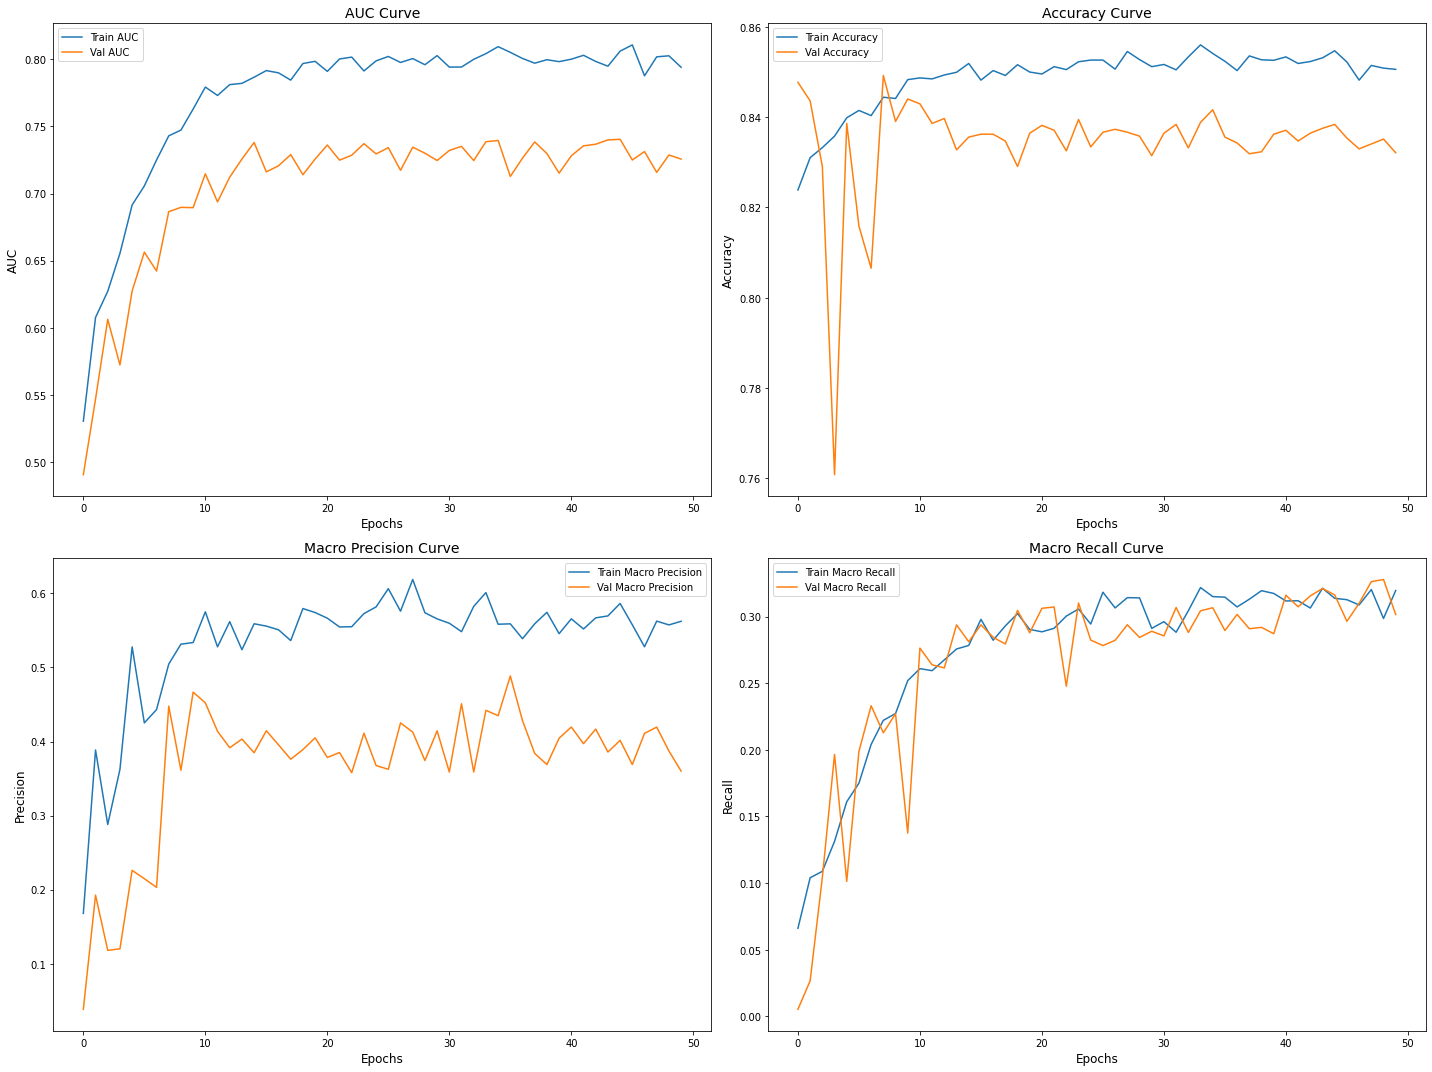

2025-04-10 12:22:41.207780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:22:51.104280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 388 of 1000
2025-04-10 12:22:53.789762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2025-04-10 12:23:09.793787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:23:17.676949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 399 of 1000


 4/37 [==>...........................] - ETA: 1s 

2025-04-10 12:23:19.207478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 27s 46ms/step

Classification Report:
              precision    recall  f1-score   support

           N       0.31      0.02      0.03       223
           D       0.23      0.25      0.24       103
           G       0.08      0.08      0.08        36
           C       0.05      0.06      0.05        36
           A       0.29      0.05      0.09        40
           H       0.00      0.00      0.00        17
           M       0.02      0.02      0.02        41
           O       0.33      0.25      0.29       189

   micro avg       0.21      0.13      0.16       685
   macro avg       0.16      0.09      0.10       685
weighted avg       0.25      0.13      0.14       685
 samples avg       0.11      0.11      0.10       685



/root/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


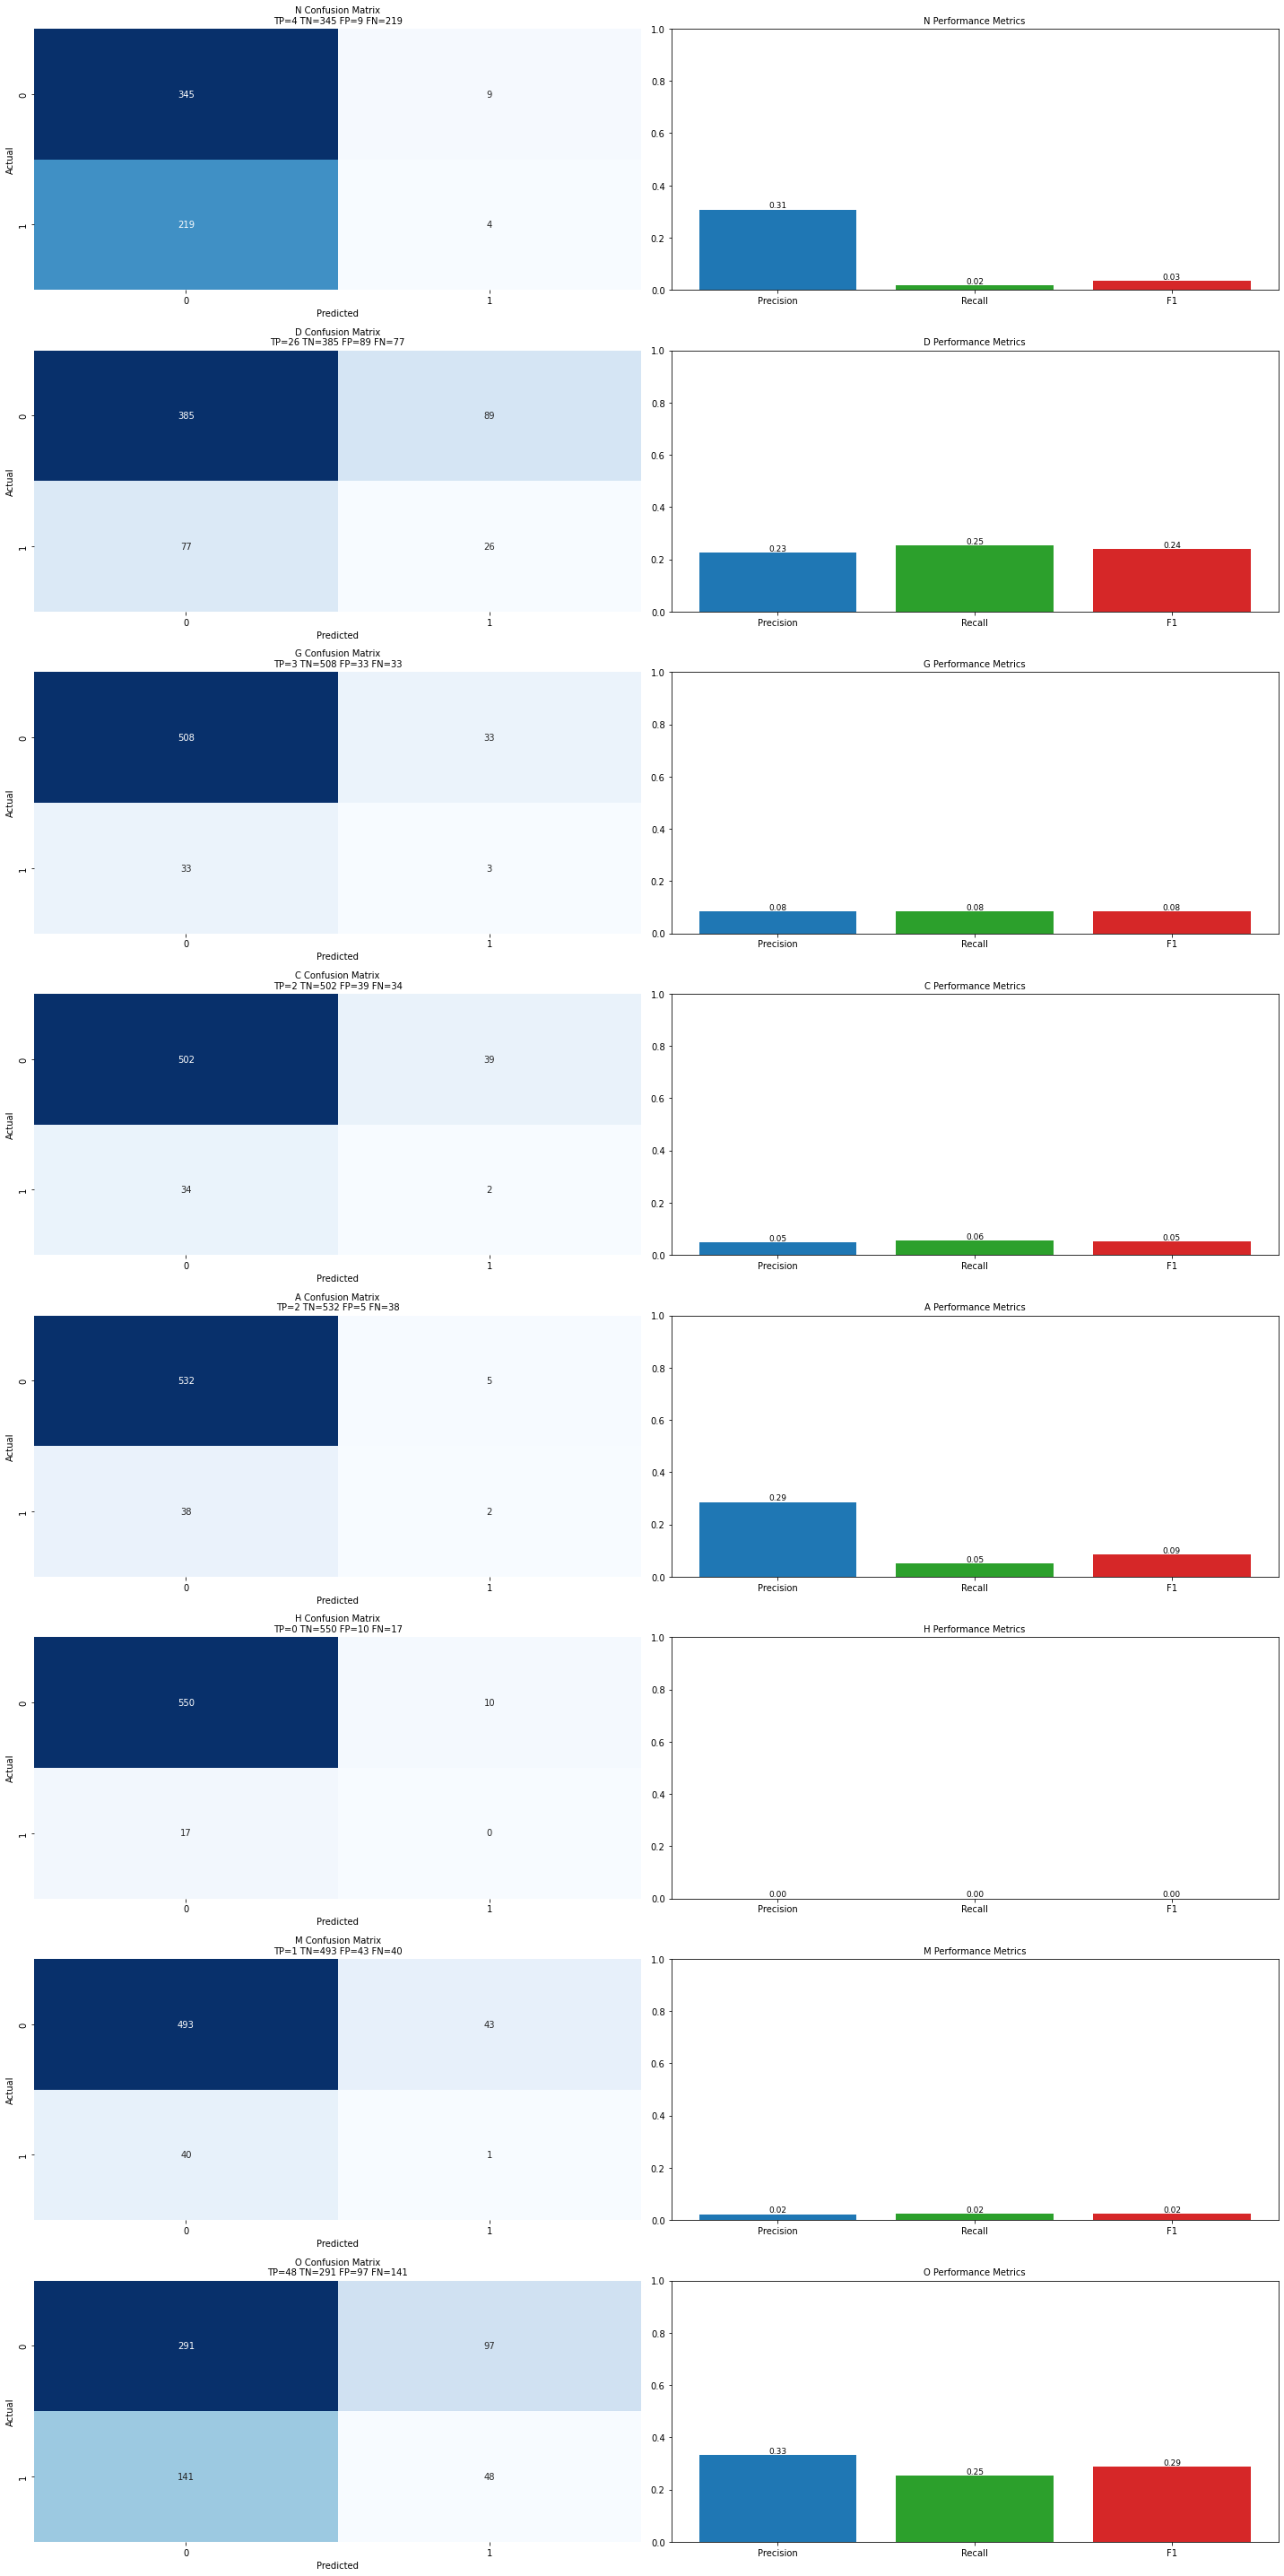

In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (244, 244)
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models_5"

# 医学图像预处理类（增强版）
class MedicalPreprocessor:
    def __init__(self):
        self.clip_limit = 3.0
        self.grid_size = (8, 8)
        
    def _circular_crop(self, img):
        """改进的圆形裁剪函数"""
        img_np = img.numpy().astype(np.uint8)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        
        # 自适应阈值处理
        blurred = cv2.GaussianBlur(gray, (9,9), 2)
        mean_val = np.mean(blurred)
        _, thresh = cv2.threshold(blurred, mean_val*0.8, 255, cv2.THRESH_BINARY_INV)
        
        # 形态学操作
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        # 轮廓检测
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return img_np
        
        largest_contour = max(contours, key=cv2.contourArea)
        
        # 椭圆/圆形检测
        if len(largest_contour) >= 5:
            ellipse = cv2.fitEllipse(largest_contour)
            (x,y), (a,b), angle = ellipse
            axes = (int(a*0.9), int(b*0.9))
        else:
            (x,y), radius = cv2.minEnclosingCircle(largest_contour)
            axes = (int(radius*0.9), int(radius*0.9))
            angle = 0
            
        # 创建掩模
        mask = np.zeros_like(gray)
        cv2.ellipse(mask, (int(x),int(y)), axes, angle, 0, 360, 255, -1)
        mask = cv2.erode(mask, np.ones((5,5)), iterations=1)
        
        # 应用掩模
        cropped = cv2.bitwise_and(img_np, img_np, mask=mask)
        return cv2.resize(cropped, IMAGE_SIZE)

    def _clahe_enhance(self, img):
        """CLAHE对比度增强"""
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.grid_size)
        enhanced_l = clahe.apply(l)
        return cv2.cvtColor(cv2.merge([enhanced_l, a, b]), cv2.COLOR_LAB2RGB)

    def _medical_enhance(self, img):
        """医学特化增强"""
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        # 非线性对比度调整
        l_float = l.astype(np.float32) / 255.0
        l_enhanced = np.power(l_float, 0.7) * 255
        l_enhanced = l_enhanced.astype(np.uint8)
        
        # 锐化处理
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        sharpened = cv2.filter2D(l_enhanced, -1, kernel)
        return cv2.cvtColor(cv2.merge([sharpened, a, b]), cv2.COLOR_LAB2RGB)

    def preprocess(self, img_path):
        """完整的预处理流程"""
        # 读取图像
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        
        # 执行圆形裁剪（使用py_function包装OpenCV处理）
        img = tf.py_function(
            func=lambda x: self._circular_crop(x),
            inp=[img],
            Tout=tf.uint8
        )
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        
        # CLAHE增强
        img = tf.py_function(
            func=lambda x: self._clahe_enhance(x.numpy()),
            inp=[img],
            Tout=tf.uint8
        )
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        
        # 中值滤波
        img = tfa.image.median_filter2d(img, filter_shape=3)
        
        # 医学增强
        img = tf.py_function(
            func=lambda x: self._medical_enhance(x.numpy()),
            inp=[img],
            Tout=tf.uint8
        )
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        
        # 数据增强
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        
        # 标准化
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = MedicalPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# 双流神经网络架构（保持不变）
def build_siamese_network():
    def create_base_network():
        base = tf.keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet'
        )
        x = layers.GlobalAveragePooling2D()(base.output)
        return Model(base.input, x)
    
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base_network = create_base_network()
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    merged = layers.Concatenate()([diff, attention])
    
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 训练流程（优化后）
def train_model():
    # 加载数据
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    # 数据集划分
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # 创建数据集
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    # 构建模型
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    # 加权损失函数
    def weighted_bce(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    # 评估指标
    metrics = [
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)],
        *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)]
    ]
    
    # 编译模型
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
    
    # 回调函数
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
    
    # 模型训练
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )
    
    # 保存模型
    os.makedirs(SAVE_DIR, exist_ok=True)
    model.save(os.path.join(SAVE_DIR, 'final_model'))
    model.save_weights(os.path.join(SAVE_DIR, 'final_weights.h5'))
    
    # 可视化分析
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 可视化函数（优化版）
def plot_training_metrics(history):
    plt.figure(figsize=(20, 15))
    
    # AUC曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    
    # 宏平均精确率
    plt.subplot(2, 2, 3)
    precision_values = [history.history[f'precision_{cls}'] for cls in CLASS_NAMES]
    mean_precision = np.mean(precision_values, axis=0)
    plt.plot(mean_precision, label='Train Macro Precision')
    val_precision = np.mean([history.history[f'val_precision_{cls}'] for cls in CLASS_NAMES], axis=0)
    plt.plot(val_precision, label='Val Macro Precision')
    plt.title('Macro Precision Curve', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.legend()
    
    # 宏平均召回率
    plt.subplot(2, 2, 4)
    recall_values = [history.history[f'recall_{cls}'] for cls in CLASS_NAMES]
    mean_recall = np.mean(recall_values, axis=0)
    val_recall = np.mean([history.history[f'val_recall_{cls}'] for cls in CLASS_NAMES], axis=0)
    plt.plot(mean_recall, label='Train Macro Recall')
    plt.plot(val_recall, label='Val Macro Recall')
    plt.title('Macro Recall Curve', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300)
    plt.show()

# 性能分析（优化版）
def analyze_performance(model, val_ds, class_names):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*5))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'{cls} Confusion Matrix\nTP={matrix[1,1]} TN={matrix[0,0]} FP={matrix[0,1]} FN={matrix[1,0]}', fontsize=10)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        plt.subplot(len(class_names), 2, 2*i+2)
        bars = plt.bar(['Precision', 'Recall', 'F1'], [precision, recall, f1], 
                      color=['#1f77b4', '#2ca02c', '#d62728'])
        plt.ylim(0, 1)
        plt.title(f'{cls} Performance Metrics', fontsize=10)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.2f}',
                    ha='center', va='bottom',
                    fontsize=9)
    
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300)
    plt.show()

# 执行训练
if __name__ == "__main__":
    model, history = train_model()

In [3]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import seaborn as sns
import os

# 配置参数
DATA_DIR = "Training_Dataset"
CSV_PATH = "Traning_Dataset.xlsx"
IMAGE_SIZE = (244, 244)                                                            
BATCH_SIZE = 16
CLASS_NAMES = ['N','D','G','C','A','H','M','O']
SAVE_DIR = "saved_models_6"

# HRNet配置参数
HRNET_CONFIG = {
    'stage1': {'num_modules': 1, 'num_branches': 1, 'block': 'BOTTLENECK', 'num_blocks': (4,), 'num_channels': (64,)},
    'stage2': {'num_modules': 1, 'num_branches': 2, 'block': 'BASIC', 'num_blocks': (4,4), 'num_channels': (32,64)},
    'stage3': {'num_modules': 4, 'num_branches': 3, 'block': 'BASIC', 'num_blocks': (4,4,4), 'num_channels': (32,64,128)},
    'stage4': {'num_modules': 3, 'num_branches': 4, 'block': 'BASIC', 'num_blocks': (4,4,4,4), 'num_channels': (32,64,128,256)}
}

# 医学图像预处理类
class MedicalPreprocessor:
    def __init__(self):
        self.clip_limit = 3.0
        self.grid_size = (8, 8)
        
    def _circular_crop(self, img):
        img_np = img.numpy().astype(np.uint8)
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        
        # 自适应阈值处理
        blurred = cv2.GaussianBlur(gray, (9,9), 2)
        mean_val = np.mean(blurred)
        _, thresh = cv2.threshold(blurred, mean_val*0.8, 255, cv2.THRESH_BINARY_INV)
        
        # 形态学操作
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        # 轮廓检测
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return img_np
        
        largest_contour = max(contours, key=cv2.contourArea)
        
        # 椭圆/圆形检测
        if len(largest_contour) >= 5:
            ellipse = cv2.fitEllipse(largest_contour)
            (x,y), (a,b), angle = ellipse
            axes = (int(a*0.9), int(b*0.9))
        else:
            (x,y), radius = cv2.minEnclosingCircle(largest_contour)
            axes = (int(radius*0.9), int(radius*0.9))
            angle = 0
            
        # 创建掩模
        mask = np.zeros_like(gray)
        cv2.ellipse(mask, (int(x),int(y)), axes, angle, 0, 360, 255, -1)
        mask = cv2.erode(mask, np.ones((5,5)), iterations=1)
        
        # 应用掩模
        cropped = cv2.bitwise_and(img_np, img_np, mask=mask)
        return cv2.resize(cropped, IMAGE_SIZE)

    def _clahe_enhance(self, img):
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.grid_size)
        enhanced_l = clahe.apply(l)
        return cv2.cvtColor(cv2.merge([enhanced_l, a, b]), cv2.COLOR_LAB2RGB)

    def _medical_enhance(self, img):
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l_float = l.astype(np.float32) / 255.0
        l_enhanced = np.power(l_float, 0.7) * 255
        l_enhanced = l_enhanced.astype(np.uint8)
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        sharpened = cv2.filter2D(l_enhanced, -1, kernel)
        return cv2.cvtColor(cv2.merge([sharpened, a, b]), cv2.COLOR_LAB2RGB)

    def preprocess(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        
        img = tf.py_function(self._circular_crop, [img], Tout=tf.uint8)
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        
        img = tf.py_function(lambda x: self._clahe_enhance(x.numpy()), [img], Tout=tf.uint8)
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        
        img = tfa.image.median_filter2d(img, filter_shape=3)
        
        img = tf.py_function(lambda x: self._medical_enhance(x.numpy()), [img], Tout=tf.uint8)
        img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
        
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        
        return tf.cast(img, tf.float32) / 255.0

# 双输入数据管道
def create_dataset(df):
    preprocessor = MedicalPreprocessor()
    
    def map_fn(left_path, right_path, labels):
        return (preprocessor.preprocess(left_path),
                preprocessor.preprocess(right_path)), labels
    
    dataset = tf.data.Dataset.from_tensor_slices((
        df['left_path'].values,
        df['right_path'].values,
        df[CLASS_NAMES].values.astype(np.float32)
    ))
    
    return dataset.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE) \
                 .shuffle(1000) \
                 .batch(BATCH_SIZE) \
                 .prefetch(tf.data.AUTOTUNE)

# HRNet构建模块
class HRModule(tf.keras.layers.Layer):
    def __init__(self, num_branches, blocks, num_channels):
        super().__init__()
        self.branches = []
        for i in range(num_branches):
            branch = tf.keras.Sequential([
                layers.Conv2D(num_channels[i], 3, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                *[BasicBlock(num_channels[i]) for _ in range(blocks[i])]
            ])
            self.branches.append(branch)
        
    def call(self, x):
        return [branch(x_i) for branch, x_i in zip(self.branches, x)]

class BasicBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += identity
        return self.relu(x)

def build_hrnet_base():
    inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    # Stem
    x = layers.Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Stage 1
    x = layers.Conv2D(256, 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Stage 2
    x = HRModule(num_branches=2, 
                blocks=HRNET_CONFIG['stage2']['num_blocks'], 
                num_channels=HRNET_CONFIG['stage2']['num_channels'])([x, layers.AveragePooling2D(2)(x)])
    
    # Stage 3
    x = HRModule(num_branches=3, 
                blocks=HRNET_CONFIG['stage3']['num_blocks'],
                num_channels=HRNET_CONFIG['stage3']['num_channels'])(
                    [x[0], x[1], layers.AveragePooling2D(2)(x[1])])
    
    # Stage 4
    x = HRModule(num_branches=4, 
                blocks=HRNET_CONFIG['stage4']['num_blocks'],
                num_channels=HRNET_CONFIG['stage4']['num_channels'])(
                    [x[0], x[1], x[2], layers.AveragePooling2D(2)(x[2])])
    
    # Feature fusion
    outputs = []
    for branch in x:
        outputs.append(layers.GlobalAveragePooling2D()(branch))
    final_output = layers.Concatenate()(outputs)
    
    return Model(inputs=inputs, outputs=final_output)

# 双流HRNet架构
def build_siamese_network():
    base_network = build_hrnet_base()
    
    left_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    right_input = layers.Input(shape=(*IMAGE_SIZE, 3))
    
    left_features = base_network(left_input)
    right_features = base_network(right_input)
    
    # 特征差异计算
    diff = layers.Subtract()([left_features, right_features])
    attention = layers.Attention()([left_features, right_features])
    
    merged = layers.Concatenate()([diff, attention])
    
    # 分类头
    x = layers.Dense(512, activation='swish')(merged)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(CLASS_NAMES), activation='sigmoid')(x)
    
    return Model(inputs=[left_input, right_input], outputs=outputs)

# 训练流程
def train_model():
    df = pd.read_excel(CSV_PATH)
    df['left_path'] = df['Left-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    df['right_path'] = df['Right-Fundus'].apply(lambda x: f"{DATA_DIR}/{x}")
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_ds = create_dataset(train_df)
    val_ds = create_dataset(val_df)
    
    model = build_siamese_network()
    class_weights = tf.constant([1.0, 2.5, 3.0, 2.0, 4.0, 5.0, 1.5, 1.2], dtype=tf.float32)
    
    def weighted_bce(y_true, y_pred):
        weights = tf.reduce_sum(class_weights * y_true, axis=1)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    
    metrics = [
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        *[tf.keras.metrics.Precision(name=f'precision_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)],
        *[tf.keras.metrics.Recall(name=f'recall_{cls}', class_id=i) 
          for i, cls in enumerate(CLASS_NAMES)]
    ]
    
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=2e-4, weight_decay=1e-5),
        loss=weighted_bce,
        metrics=metrics
    )
    
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_hrnet_model.h5',
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=70,
        callbacks=callbacks
    )
    
    os.makedirs(SAVE_DIR, exist_ok=True)
    model.save(os.path.join(SAVE_DIR, 'hrnet_final_model'))
    
    # 可视化函数（保持与之前相同）
    plot_training_metrics(history)
    analyze_performance(model, val_ds, CLASS_NAMES)
    
    return model, history

# 可视化函数
def plot_training_metrics(history):
    plt.figure(figsize=(20, 15))
    
    # AUC曲线
    plt.subplot(2, 2, 1)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve', fontsize=14)
    plt.legend()
    
    # 准确率曲线
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curve', fontsize=14)
    plt.legend()
    
    # 宏平均指标
    plt.subplot(2, 2, 3)
    macro_precision = np.mean([history.history[f'precision_{cls}'] for cls in CLASS_NAMES], axis=0)
    val_macro_precision = np.mean([history.history[f'val_precision_{cls}'] for cls in CLASS_NAMES], axis=0)
    plt.plot(macro_precision, label='Train Macro Precision')
    plt.plot(val_macro_precision, label='Val Macro Precision')
    plt.title('Macro Precision', fontsize=14)
    plt.legend()
    
    plt.subplot(2, 2, 4)
    macro_recall = np.mean([history.history[f'recall_{cls}'] for cls in CLASS_NAMES], axis=0)
    val_macro_recall = np.mean([history.history[f'val_recall_{cls}'] for cls in CLASS_NAMES], axis=0)
    plt.plot(macro_recall, label='Train Macro Recall')
    plt.plot(val_macro_recall, label='Val Macro Recall')
    plt.title('Macro Recall', fontsize=14)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('hrnet_training_metrics.png', dpi=300)
    plt.show()

# 性能分析
def analyze_performance(model, val_ds, class_names):
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred > 0.5, target_names=class_names))
    
    cm = multilabel_confusion_matrix(y_true, y_pred > 0.5)
    
    plt.figure(figsize=(20, len(class_names)*5))
    for i, (cls, matrix) in enumerate(zip(class_names, cm)):
        plt.subplot(len(class_names), 2, 2*i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{cls} Confusion Matrix')
        
        plt.subplot(len(class_names), 2, 2*i+2)
        precision = matrix[1,1] / (matrix[1,1] + matrix[0,1]) if (matrix[1,1] + matrix[0,1]) > 0 else 0
        recall = matrix[1,1] / (matrix[1,1] + matrix[1,0]) if (matrix[1,1] + matrix[1,0]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        plt.bar(['Precision', 'Recall', 'F1'], [precision, recall, f1])
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('hrnet_confusion_matrices.png', dpi=300)
    plt.show() 

if __name__ == "__main__":
    model, history = train_model()

Epoch 1/70


2025-04-10 12:25:28.157393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:25:37.705127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 391 of 1000
2025-04-10 12:25:48.276239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 651 of 1000
2025-04-10 12:25:57.620962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 972 of 1000
2025-04-10 12:26:00.595991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


145/145 [==============================] - ETA: 0s - loss: 1.0939 - auc: 0.4997 - accuracy: 0.8044 - precision_N: 0.3913 - precision_D: 0.1981 - precision_G: 0.0521 - precision_C: 0.0392 - precision_A: 0.0794 - precision_H: 0.0385 - precision_M: 0.0500 - precision_O: 0.3167 - recall_N: 0.0394 - recall_D: 0.2417 - recall_G: 0.0279 - recall_C: 0.0114 - recall_A: 0.0413 - recall_H: 0.0333 - recall_M: 0.0075 - recall_O: 0.2787

2025-04-10 12:27:09.178157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 193 of 1000
2025-04-10 12:27:17.313153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 394 of 1000
2025-04-10 12:27:19.630171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


NotImplementedError: 
Layer HRModule has arguments ['self', 'num_branches', 'blocks', 'num_channels']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config